<a href="https://colab.research.google.com/github/Patt-trick/servicescope/blob/main/notebooks/02%20-%20Model%20Development%20and%20Training/02_Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Development

This Notebook contains all information pertaining to the development of the models in the paper "Leveraging Temporal Graphs for Enhancing Transformer-based Predictive Process Monitoring" and was developed by Marc C. Hennig (mhennig@hm.edu). Requires the preprocessed event logs in the first file.

# Environment

Initialization of the environment runnable in Google Colab and contianing all dependency installations and global variables used in the paper.

## Dependency installation

### A. PIP Dependencies

In [1]:
!pip install ipdb keras==3.3.3 keras_nlp keras-tuner tensorboard-plugin-profile
#!pip freeze > requirements.txt

INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 60.3 MB/s

In [3]:
!pip install numpy==1.26.4

## Dependency Imports

In [1]:
# Python dependencies
import os
import sys
import re
import math
import datetime
import random
import json
import time
import shutil
import warnings
import functools
from pathlib import Path
from typing import List, Tuple, Union, Optional, Literal, Callable, Dict
from collections import namedtuple
from enum import Enum

# Debugging
import ipdb

# Colab dependencies
from google.colab import files, drive

# Basic dependencies
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels as sm

# Plotting dependencies
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Machine learning depenencies
import sklearn as sl
import sklearn.metrics

# Neural network dependencies
%load_ext tensorboard

import tensorflow as tf
from tensorflow.data import Dataset

import keras
import keras_nlp
import keras_tuner

from keras import backend as K

## Variables & Global Settings

In [2]:
# Assign a random seed for reproduceability
RANDOM_STATE = 1337

os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Keras backend
os.environ["KERAS_BACKEND"] = "tensorflow"

# Show all Pandas columns
pd.set_option("display.max_columns", None)

# Set Matplotlib and Seaborn color scheme
plt.rcParams["image.cmap"] = "Blues"
sns.set_palette("Blues")

# Masking is handled manually
warnings.filterwarnings("ignore", message=r"(absl:)?Layer '\w+' \(of type \w+\) was passed an input with a mask attached to it\. However, this layer does not support masking and will therefore destroy the mask information\. Downstream layers will not see the mask\.")
warnings.filterwarnings("ignore", message=r"(absl:)?You are explicitly setting `\w+` while the `\w+` have built-in mask, so the built-in mask is ignored\.")

In [3]:
# Google Drive folders
GDRIVE_INPUT_DIR = "/content/drive/My Drive/tgn/data/Split Datasets"
GDRIVE_OUTPUT_DIR = "/content/drive/My Drive/tgn/data/Output"

# Local Colab folders
UTIL_DIR = os.path.join(".", "Util")
DATA_DIR = os.path.join(".", "Data")
INPUT_DATA_DIR = os.path.join(DATA_DIR, "Input")
INPUT_DATA_BPIC2013_DIR = os.path.join(INPUT_DATA_DIR, "BPIC 2013")
INPUT_DATA_BPIC2014_DIR = os.path.join(INPUT_DATA_DIR, "BPIC 2014")
INTERIM_DATA_DIR = os.path.join(DATA_DIR, "Interim")
OUTPUT_DATA_DIR = os.path.join(DATA_DIR, "Output")
OUTPUT_LOG_DATA_DIR = os.path.join(OUTPUT_DATA_DIR, "Logs")

GRAPHIC_DIR = os.path.join(".", "Graphics")
MODEL_DIR = os.path.join(".", "Models")
MODEL_CHECKPOINT_DIR = os.path.join(MODEL_DIR, "Checkpoints")
MODEL_BACKUP_DIR = os.path.join(MODEL_DIR, "Backups")

Path(DATA_DIR).mkdir(exist_ok=True)
Path(INTERIM_DATA_DIR).mkdir(exist_ok=True)
Path(OUTPUT_DATA_DIR).mkdir(exist_ok=True)
Path(OUTPUT_LOG_DATA_DIR).mkdir(exist_ok=True)
Path(GRAPHIC_DIR).mkdir(exist_ok=True)
Path(MODEL_DIR).mkdir(exist_ok=True)
Path(MODEL_BACKUP_DIR).mkdir(exist_ok=True)
Path(MODEL_CHECKPOINT_DIR).mkdir(exist_ok=True)

In [4]:
EVENTLOG_CASE = "case:concept:name"
EVENTLOG_ACTIVITY = "concept:name"
EVENTLOG_TIMESTAMP = "time:timestamp"
EVENTLOG_GROUP = "org:group"
EVENTLOG_RESOURCE = "org:resource"
EVENTLOG_CASE_PREFIX = "case:"
EVENTLOG_LABEL_PREFIX = "label:"

TOKEN_PAD = "[PAD]"
TOKEN_PAD_NUM = -1.0
TOKEN_OOV = "[OOV]"
TOKEN_NA = "[NA]"
TOKEN_EOC = "[EOC]"

DEFAULT_LEARNING_RATE = 0.00003
DEFAULT_MIN_LEARNING_RATE = 1e-6

DEFAULT_WARMUP_EPOCHS = 10
DEFAULT_EPOCHS = 200
DEFAULT_BATCH_SIZE = 64

TARGET_NEXT_ACTIVITY = "next_activity"
TARGET_NEXT_TIME = "next_time"
TARGET_REMAINING_TIME = "remaining_time"

DEFAULT_REMAINING_TIME_OUTPUT = "remaining_time"
DEFAULT_NEXT_ACTIVITY_OUTPUT = "next_activity"
DEFAULT_NEXT_TIME_OUTPUT = "next_time"

## Data Import

### A: Import from Google Drive

In [5]:
drive.mount("/content/drive")

!cp -r "$GDRIVE_INPUT_DIR" "$INPUT_DATA_DIR"

drive.flush_and_unmount()

Mounted at /content/drive


### B: Upload from Local Machine

In [ ]:
#uploaded = files.upload()

#for filename in uploaded.keys():
#  target = os.path.join(INPUT_DATA_DIR, filename)
#  !mv "$filename" "$target"

#del uploaded

## Common Functions

In [6]:
def df_write_files(df: pd.DataFrame, filename: str, index: bool = False) -> None:
  df.to_csv(f"{filename}.csv", index=index)
  df.to_pickle(f"{filename}.pkl.gz")
  try:
    df.reset_index().to_feather(f"{filename}.feather")
  except Exception as e:
    print(f"Skipping feather: {e}")
  try:
    df.to_parquet(f"{filename}.parquet", index=index)
  except Exception as e:
    print(f"Skipping parquet: {e}")

### Dataset Functions

In [7]:
def ds_write_files(ds: tf.data.Dataset, filename: str, compression: Optional[str] = 'zip') -> None:
  ds.save(filename, compression='GZIP')
  shutil.make_archive(
      filename,
      format=compression,
      root_dir=filename
  )

def ds_find_static_attrs(ds: tf.data.Dataset) -> List[str]:
  input, _ = ds.element_spec

  stat_attrs = []
  for key, value in input.items():
    if 1 == value.shape.num_elements():
      stat_attrs.append(key)

  return stat_attrs

def ds_find_dynamic_attrs(ds: tf.data.Dataset) -> List[str]:
  input, _ = ds.element_spec

  dyn_attrs = []
  for key, value in input.items():
    if 1 < value.shape.num_elements():
      dyn_attrs.append(key)

  return dyn_attrs

def ds_find_max_seq_len(ds: tf.data.Dataset) -> int:
  input, _ = ds.element_spec

  dyn_attrs = ds_find_dynamic_attrs(ds)
  dyn_attr_lens = set()
  for dyn_attr in dyn_attrs:
    dyn_attr_lens.add(input[dyn_attr].shape[0])

  if len(dyn_attr_lens) > 1:
    raise ValueError(f"Different sequence lengths for different attributes {dyn_attr_lens}.")

  return dyn_attr_lens.pop()

def ds_calculate_class_weights(ds: tf.data.Dataset, y_key: str = TARGET_NEXT_ACTIVITY) -> dict:
  y_train = np.concatenate([y[y_key] for x, y in ds], axis=0).flatten()

  class_weights = sl.utils.class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
  )
  return dict(enumerate(class_weights))

def ds_rename_attr(ds: tf.data.Dataset, old_attr: str, new_attr: str, copy: bool = False) -> tf.data.Dataset:

  def ds_rename_attr_map_helper(inputs, outputs):
    inputs[new_attr] = inputs[old_attr]
    if not copy:
      inputs.pop(old_attr)

    return inputs, outputs

  return ds.map(ds_rename_attr_map_helper, num_parallel_calls=tf.data.AUTOTUNE)

def ds_desequentialize_dynamic_attrs(ds: tf.data.Dataset, dynamic_attrs: Optional[Union[List[str], str]] = None, strategy: Literal['last', 'first', 'mean', 'median'] = 'last', activity_attr: str = "activity", pad_token: str = TOKEN_PAD) -> tf.data.Dataset:
  if dynamic_attrs is None:
    dynamic_attrs = ds_find_dynamic_attrs(ds)
  elif isinstance(dynamic_attrs, str):
    dynamic_attrs = [dynamic_attrs]


  def ds_desequentialize_map_helper(inputs, outputs):
    # Find the current sequence length by looking for the padding token in the 'activity' attribute
    seq_len = tf.argmax(tf.equal(inputs[activity_attr], pad_token), axis=-1)
    for attr in dynamic_attrs:
      if 'last' == strategy:
        inputs[attr] = [inputs[attr][seq_len - 1]]
      elif 'first' == strategy:
        inputs[attr] = [inputs[attr][0]]
      elif 'mean' == strategy:
        inputs[attr] = [tf.reduce_mean(inputs[attr][:seq_len], axis=0)]
      elif 'median' == strategy:
        inputs[attr] = [tfp.stats.percentile(inputs[attr][:seq_len], 50)]
      else:
        raise ValueError(f"Unknown strategy {strategy}")

    return inputs, outputs

  return ds.map(ds_desequentialize_map_helper, num_parallel_calls=tf.data.AUTOTUNE)

def ds_sequentialize_static_attrs(ds: tf.data.Dataset, static_attrs: Optional[Union[List[str], str]] = None, activity_attr: str = "activity", pad_token: str = TOKEN_PAD, pad_token_num = int(TOKEN_PAD_NUM)) -> tf.data.Dataset:
  if static_attrs is None:
    static_attrs = ds_find_static_attrs(ds)
  elif isinstance(static_attrs, str):
    static_attrs = [static_attrs]

  max_seq_len = ds_find_max_seq_len(ds)

  def ds_sequentialize_map_helper(inputs, outputs):
    # Find the current sequence length by looking for the padding token in the 'activity' attribute
    # Assumes 'activity' is a dynamic attribute holding the sequence
    seq_len = tf.argmax(tf.equal(inputs[activity_attr], pad_token), axis=-1)

    for attr in static_attrs:
      # Repeat static attribute for the sequence length and pad to the max sequence length
      attr_val_repeated = tf.repeat(inputs[attr], repeats=seq_len, axis=0)
      paddings = [[0, max_seq_len - seq_len]]
      pad_const = pad_token_num if attr_val_repeated.dtype.is_numeric else pad_token
      attr_val_padded = tf.pad(attr_val_repeated, paddings, 'CONSTANT', constant_values=pad_const)
      inputs[attr] = attr_val_padded
      inputs[attr].set_shape((seq_len,))

    return inputs, outputs

  return ds.map(ds_sequentialize_map_helper, num_parallel_calls=tf.data.AUTOTUNE)

def ds_window_dynamic_attrs(ds: tf.data.Dataset, window: int, activity_attr: str = "activity", pad_token: str = TOKEN_PAD, pad_token_num = int(TOKEN_PAD_NUM)) -> tf.data.Dataset:
  max_seq_len = ds_find_max_seq_len(ds)
  dyn_attrs = ds_find_dynamic_attrs(ds)

  if max_seq_len <= window:
    return ds

  def ds_window_map_helper(inputs, outputs):
    # Find the current sequence length by looking for the padding token in the 'activity' attribute. Assumes 'activity' is a dynamic attribute holding the sequence and all dynamic attributes are of equal length
    seq_len = tf.argmax(tf.equal(inputs[activity_attr], pad_token), axis=-1)
    begin = tf.math.maximum(tf.zeros((), tf.int64), seq_len - window)
    end = begin + window

    for attr in dyn_attrs:
      inputs[attr] = inputs[attr][begin:end]
      shape = tuple([window] + inputs[attr].shape.as_list()[1:])
      inputs[attr].set_shape(shape)

    return inputs, outputs

  return ds.map(ds_window_map_helper, num_parallel_calls=tf.data.AUTOTUNE)

def ds_to_single_target(ds: tf.data.Dataset, target_attr: str) -> tf.data.Dataset:
  return ds.map(lambda inputs, outputs: (inputs, outputs[target_attr]), num_parallel_calls=tf.data.AUTOTUNE)

def ds_find_target_classes(ds: tf.data.Dataset, target_attr: str) -> List[str]:
  return np.unique(np.concatenate([y[target_attr] for x, y in ds], axis=0).flatten())

def ds_sparse_target_to_onehot(ds: tf.data.Dataset, target_attr: str) -> tf.data.Dataset:
  num_classes = len(ds_find_target_classes(ds, target_attr))
  return ds.map(lambda inputs, outputs: (inputs, keras.utils.to_categorical(outputs[target_attr], num_classes=num_classes)), num_parallel_calls=tf.data.AUTOTUNE)

def ds_cache_and_batch(ds: tf.data.Dataset, batch_size: int = DEFAULT_BATCH_SIZE, cache_file: Optional[str] = None, shuffle: bool = False) -> tf.data.Dataset:
  if cache_file is not None:
    ds = ds.cache(filename=cache_file)
  else:
    ds = ds.cache()

  # Build the cache
  _ = list(ds.as_numpy_iterator())

  if shuffle:
    ds = ds.shuffle(len(ds))

  return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

def ds_filter_length(ds: tf.data.Dataset, min: int = 0, max: int = float('inf'), activity_attr: str = "activity", pad_token: str = TOKEN_PAD) -> tf.data.Dataset:
  if min > max:
    raise ValueError(f"min {min} must be smaller than the max {max}")
  if max < 0:
    raise ValueError(f"max {max} must be a positive number")

  def ds_filter_length_helper(inputs, outputs):
    seq_len = keras.ops.argmax(keras.ops.equal(inputs[activity_attr], pad_token), axis=-1)
    gte = keras.ops.greater_equal(seq_len, min)
    lt = keras.ops.less(seq_len, max)
    return keras.ops.logical_and(gte, lt)

  ds = ds.filter(ds_filter_length_helper)

  ds_len = 0
  for _ in ds:
    ds_len += 1

  ds = ds.apply(tf.data.experimental.assert_cardinality(ds_len))

  return ds


### Model Functions

#### Tensorflow

In [8]:
class LayerNameMixin:
  """A mixin class that provides functionality to generate unique layer names.

    This class is designed to be used in conjunction with Keras models.

    Author:
        Marc C. Hennig (mhennig@hm.edu)
    """
  def _generate_layer_name(self, prefix: str, suffix: Optional[str]):
    """Generates a unique layer name based on the given prefix and suffix.

      The method ensures that the generated name is unique among the existing layer names
      in the `self.layers` collection. If the combination of prefix and suffix already
      exists, it appends a numerical suffix to make the name unique.

      Args:
          prefix (str): The base prefix for the layer name.
          suffix (Optional[str]): An optional suffix to append to the prefix. If None, only the prefix is used.

      Returns:
          str: A unique layer name that does not conflict with existing layer names.

      Example:
          If `prefix` is "conv" and `suffix` is "1", and "conv_1" already exists,
          the method will return "conv_1_1" (or the next available unique name).
    """
    layer_names = set(layer.name for layer in self.layers)

    name = prefix if suffix is None else f"{prefix}_{suffix}"

    if name in layer_names:
      i = 1
      while f"{name}_{i}" in layer_names:
        i += 1
      name = f"{name}_{i}"

    return name

In [9]:
class BaseModelMixin:
  """
    A mixin class that provides default configurations for machine learning models,
    including optimizers, loss functions, metrics, and callbacks.

    This class is designed to be extended by specific model types (e.g., regression,
    binary classification, multiclass classification) to provide default behaviors tailored to those tasks.

    Author:
        Marc C. Hennig (mhennig@hm.edu)
  """
  @property
  def default_optimizer(self) -> keras.Optimizer:
    #return keras.optimizers.AdamW(learning_rate=self.default_learning_rate, weight_decay=0.0003, clipnorm=1.0)
    return keras.optimizers.AdamW(learning_rate=self.default_learning_rate, weight_decay=0.01, clipnorm=3.0)

  def is_regression(self, activation: str) -> bool:
    return True if activation in ['linear', 'relu'] else False

  def is_binary_classification(self, activation: str) -> bool:
    return True if activation in ['sigmoid'] else False

  def is_multiclass_classification(self, activation: str) -> bool:
    return True if activation in ['softmax'] else False

  @property
  def default_monitor_metric(self):
    return 'val_loss'

  @property
  def default_learning_rate(self) -> Union[float, keras.optimizers.schedules.LearningRateSchedule]:
    return keras.optimizers.schedules.CosineDecay(
      initial_learning_rate=3e-5,
      decay_steps=TRAIN_STEPS_EPOCH*10
    )

  def find_default_loss(self, activation: str) -> keras.losses.Loss:
    if self.is_regression(activation):
      return self.default_regression_loss
    elif self.is_binary_classification(activation):
      return self.default_binary_classification_loss
    elif self.is_multiclass_classification(activation):
      return self.default_multiclass_classification_loss
    else:
      raise ValueError(f"Unknown activation {activation}")

  def find_default_metrics(self, activation: str) -> List[keras.metrics.Metric]:
    if self.is_regression(activation):
      return self.default_regression_metrics
    elif self.is_binary_classification(activation):
      return self.default_binary_classification_metrics
    elif self.is_multiclass_classification(activation):
      return self.default_multiclass_classification_metrics
    else:
      raise ValueError(f"Unknown activation {activation}")

  @property
  def default_regression_loss(self) -> keras.losses.Loss:
    return keras.losses.LogCosh()

  @property
  def default_binary_classification_loss(self) -> keras.losses.Loss:
    return keras.losses.BinaryCrossentropy()

  @property
  def default_multiclass_classification_loss(self) -> keras.losses.Loss:
    return keras.losses.SparseCategoricalCrossentropy()

  @property
  def default_regression_metrics(self) -> List[keras.metrics.Metric]:
    return [
        keras.metrics.MeanAbsoluteError(),
        keras.metrics.MeanSquaredError(),
        keras.metrics.RootMeanSquaredError(),
        keras.metrics.MeanSquaredLogarithmicError(),
        keras.metrics.MeanAbsolutePercentageError(),
        keras.metrics.LogCoshError(),
    ]

  @property
  def default_binary_classification_metrics(self) -> List[keras.metrics.Metric]:
    return [
        keras.metrics.Accuracy(),
        keras.metrics.SparseCategoricalAccuracy(),
        keras.metrics.F1Score(name="f1_score"),
        keras.metrics.AUC(curve="ROC", name='roc_auc'),
        keras.metrics.AUC(curve="PR", name='pr_auc'),
        keras.metrics.BinaryCrossentropy(),
    ]

  @property
  def default_multiclass_classification_metrics(self) -> List[keras.metrics.Metric]:
    return [
        keras.metrics.SparseCategoricalAccuracy(),
        keras.metrics.F1Score(average='macro', name="f1_score_macro"),
        keras.metrics.F1Score(average='micro', name="f1_score_micro"),
        keras.metrics.F1Score(average='weighted', name="f1_score_weighted"),
        keras.metrics.SparseCategoricalCrossentropy(),
    ]

  def default_callbacks(
    self,
    log_file: Optional[str] = None,
    tensorboard_dir: Optional[str] = None,
    backup_dir: Optional[str] = None,
    checkpoint_file: Optional[str] = None,
    **kwargs
  ) -> List[keras.callbacks.Callback]:

    callbacks = []
    #callbacks.append(keras.callbacks.ReduceLROnPlateau(patience=5, min_lr=DEFAULT_MIN_LEARNING_RATE, factor=0.5 monitor=self.default_monitor_metric))

    if log_file is not None:
      callbacks.append(keras.callbacks.CSVLogger(
        filename=log_file if log_file.endswith(".csv") else f"{log_file}.csv",
        separator=";",
        append=backup_dir is not None,
      ))

    if checkpoint_file is not None:
      callbacks.append(keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_file,
        monitor=self.default_monitor_metric,
        save_best_only=True,
        save_weights_only=False,
        mode='auto',
        save_freq='epoch',
        verbose=1,
      ))

    if tensorboard_dir is not None:
      callbacks.append(keras.callbacks.TensorBoard(
        log_dir=tensorboard_dir,
        update_freq='epoch',
        histogram_freq=5,
        embeddings_freq=5,
        write_graph=True,
        write_images=True,
        #profile_batch='10,30',
      ))

    if backup_dir is not None:
      callbacks.append(keras.callbacks.BackupAndRestore(
        backup_dir,
        save_freq='epoch',
        delete_checkpoint=False,
      ))

    callbacks = callbacks + [
      keras.callbacks.TerminateOnNaN(),
      keras.callbacks.EarlyStopping(
        monitor=self.default_monitor_metric,
        mode='auto',
        patience=10,
        verbose=1,
        restore_best_weights=True,
        start_from_epoch=0,
      ),
    ]
    return callbacks

  __author__ = "Marc C. Hennig"

class RegressionModelMixin(BaseModelMixin):
  """A mixin class for regression models. Extends `BaseModelMixin` to provide
    default loss and metrics for regression tasks.

    Author:
      Marc C. Hennig (mhennig@hm.edu)
   """
  @property
  def default_loss(self) -> keras.losses.Loss:
    return self.default_regression_loss

  @property
  def default_metrics(self) -> List[keras.metrics.Metric]:
    return self.default_regression_metrics

class MulticlassModelMixin(BaseModelMixin):
  """A mixin class for multiclass classification models. Extends `BaseModelMixin` to provide
    default loss and metrics for multiclass classification tasks.

    Author:
      Marc C. Hennig (mhennig@hm.edu)
  """
  @property
  def default_loss(self) -> keras.losses.Loss:
    return self.default_multiclass_classification_loss

  @property
  def default_metrics(self) -> List[keras.metrics.Metric]:
    return self.default_multiclass_classification_metrics

class BinaryclassModelMixin(BaseModelMixin):
  """A mixin class for binary classification models. Extends `BaseModelMixin` to provide
    default loss and metrics for multiclass classification tasks.

    Author:
      Marc C. Hennig (mhennig@hm.edu)
  """
  @property
  def default_loss(self) -> keras.losses.Loss:
    return self.default_binary_classification_loss

  @property
  def default_metrics(self) -> List[keras.metrics.Metric]:
    return self.default_binary_classification_metrics

def get_default_callbacks(
    log_file: Optional[str] = None,
    tensorboard_dir: Optional[str] = None,
    backup_dir: Optional[str] = None,
    checkpoint_file: Optional[str] = None,
  ) -> List[keras.callbacks.Callback]:

    def learning_rate_scheduler(epoch: int, learning_rate: float):
      if learning_rate_warmup is not None and epoch <= learning_rate_warmup.warmup_epochs:
        return learning_rate_warmup(epoch, learning_rate)
      elif learning_rate_decay is not None:
        return learning_rate_decay(epoch, learning_rate)
      else:
        return learning_rate

    callbacks = []
    if log_file is not None:
      callbacks.append(keras.callbacks.CSVLogger(
        filename=log_file if log_file.endswith(".csv") else f"{log_file}.csv",
        separator=";",
        append=backup_dir is not None,
      ))

    if checkpoint_file is not None:
      callbacks.append(keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_file,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='auto',
        save_freq='epoch',
        verbose=1,
      ))

    if tensorboard_dir is not None:
      callbacks.append(keras.callbacks.TensorBoard(
        log_dir=tensorboard_dir,
        update_freq='epoch',
        histogram_freq=5,
        embeddings_freq=5,
        write_graph=True,
        write_images=True,
        #profile_batch='10,30',
      ))

    if backup_dir is not None:
      callbacks.append(keras.callbacks.BackupAndRestore(
        backup_dir,
        save_freq='epoch',
        delete_checkpoint=False,
      ))
    callbacks = callbacks + [
      keras.callbacks.TerminateOnNaN(),
      keras.callbacks.LearningRateScheduler(learning_rate_scheduler, verbose=1),
      keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='auto',
        patience=20,
        verbose=1,
        restore_best_weights=True,
        start_from_epoch=20,
      ),
    ]
    return callbacks


In [10]:
def model_visualize_history(model: keras.Model, history = None):
  if history is not None:
    history = history.history
  else:
    history = model.history.history

  for metric in [key for key in history.keys() if not key.startswith('val_')]:
    if metric.startswith(TARGET_NEXT_ACTIVITY):
      title = TARGET_NEXT_ACTIVITY.replace("_", " ").title()
      y_label = metric.replace(TARGET_NEXT_ACTIVITY, '').replace("_", " ").title()
    elif metric.startswith(TARGET_NEXT_TIME):
      title = TARGET_NEXT_TIME.replace("_", " ").title()
      y_label = metric.replace(TARGET_NEXT_TIME, '').replace("_", " ").title()
    elif metric.startswith(TARGET_REMAINING_TIME):
      title = TARGET_REMAINING_TIME.replace("_", " ").title()
      y_label = metric.replace(TARGET_REMAINING_TIME, '').replace("_", " ").title()
    else:
      title = ""
      y_label = metric.replace("_", " ").title()

    plt.plot(history[metric])
    if f"val_{metric}" in history:
      plt.plot(history[f"val_{metric}"])

    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel("Epoch")
    if f"val_{metric}" in history:
      plt.legend(["train", "test"], loc='upper left')
    plt.tight_layout()
    plt.savefig(
        os.path.join(GRAPHIC_DIR, f"{model.name}_{metric}.svg"),
        bbox_inches='tight'
    )
    plt.show()

def model_regression_report(model: keras.Model, ds: tf.data.Dataset, target: str, archive: bool = False):
  y_true = np.concatenate([y[target] for x, y in ds], axis=0).flatten()
  y_pred = model.predict(ds)

  if len(model.output_names) > 1:
    target_idx = model.output_names.index(target)
    y_pred = y_pred[target_idx]

  y_pred = y_pred.flatten()
  result = {
      "MAE": float(sl.metrics.mean_absolute_error(y_true, y_pred)),
      "MSE": float(sl.metrics.mean_squared_error(y_true, y_pred)),
      "RMSE": float(sl.metrics.root_mean_squared_error(y_true, y_pred)),
      "MEDAE": float(sl.metrics.median_absolute_error(y_true, y_pred)),
      "MAPE": float(sl.metrics.mean_absolute_percentage_error(y_true, y_pred)),
  }

  if y_true.min() >= 0 and y_pred.min() >= 0:
    result.update({
      "MSLE": float(sl.metrics.mean_squared_log_error(y_true, y_pred)),
      "RMSLE": float(sl.metrics.root_mean_squared_log_error(y_true, y_pred)),
    })

  filename_prefix = model.name if target in model_name else f"{model.name}_{target}"

  try:
    if archive:
      np.savez_compressed(os.path.join(OUTPUT_DATA_DIR, f"{filename_prefix}.npz"), ground_truth=y_true.astype(float), predictions=y_true.astype(float), allow_pickle=False)
    else:
      np.save(os.path.join(OUTPUT_DATA_DIR, f"{filename_prefix}_predictions.npy"), y_pred.astype(float), allow_pickle=False)
      np.save(os.path.join(OUTPUT_DATA_DIR, f"{filename_prefix}_groundtruth.npy"), y_true.astype(float), allow_pickle=False)
  except Exception as e:
    print(f"Failed to save predicitons: {e}")

  print("\t\t".join(result.keys()))
  print("\t\t".join(["%.4f" % result for result in result.values()]))

  with open(os.path.join(OUTPUT_DATA_DIR, f"{filename_prefix}_regression_report.json"), 'w') as file:
    json.dump(result, file)

  return result

def model_classification_report(model: keras.Model, ds: tf.data.Dataset, target: str, archive: bool = False):
  y_true = np.concatenate([y[target] for x, y in ds], axis=0).flatten()
  y_pred = model.predict(ds)

  if len(model.output_names) > 1:
    target_idx = model.output_names.index(target)
    y_pred = y_pred[target_idx]

  filename_prefix = model.name if target in model_name else f"{model.name}_{target}"

  try:
    if archive:
      np.savez_compressed(os.path.join(OUTPUT_DATA_DIR, f"{filename_prefix}.npz"), ground_truth=y_true.astype(float), predictions=y_true.astype(float), allow_pickle=False)
    else:
      np.save(os.path.join(OUTPUT_DATA_DIR, f"{filename_prefix}_predictions.npy"), y_pred.astype(float), allow_pickle=False)
      np.save(os.path.join(OUTPUT_DATA_DIR, f"{filename_prefix}_groundtruth.npy"), y_true.astype(float), allow_pickle=False)

  except Exception as e:
    print(f"Failed to save predictions: {e}")

  y_pred = np.argmax(y_pred, axis=1)

  print(sl.metrics.classification_report(y_true, y_pred, digits=4))
  report = sl.metrics.classification_report(y_true, y_pred, digits=4, output_dict=True)

  report.update({
      "balanced_accuracy": sl.metrics.balanced_accuracy_score(y_true, y_pred),
  })

  with open(os.path.join(OUTPUT_DATA_DIR, f"{filename_prefix}_classification_report.json"), 'w') as file:
    json.dump(report, file)

  confusion_matrix = sl.metrics.confusion_matrix(y_true, y_pred)
  confusion_disp = sl.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
  confusion_disp.plot()
  plt.title("Confusion Matrix")
  plt.savefig(os.path.join(GRAPHIC_DIR, f"{filename_prefix}_confusion_matrix.svg"))
  plt.show()

def model_save_files(model: keras.Model, ds: tf.data.Dataset = None):
  history = model.history.history
  with open(os.path.join(OUTPUT_DATA_DIR, f"{model.name}_history.json"), 'w') as file:
    json.dump(history, file)

  model.save(
      os.path.join(MODEL_DIR, f"{model.name}.keras"),
      overwrite=True
  )

  if ds is not None:
    evaluation = model.evaluate(
        ds,
        return_dict=True,
        verbose=1,
    )
    with open(os.path.join(OUTPUT_DATA_DIR, f"{model.name}_evaluation.json"), 'w') as file:
      json.dump(evaluation, file)

  keras.utils.plot_model(
    model,
    to_file=os.path.join(GRAPHIC_DIR, f"{model.name}.png"),
    show_shapes=True,
    show_dtype=True,
    show_layer_names=False,
    dpi=400,
    show_layer_activations=True,
  )
  try:
    keras.utils.plot_model(
      model,
      to_file=os.path.join(GRAPHIC_DIR, f"{model.name}.svg"),
      show_shapes=True,
      show_dtype=True,
      show_layer_names=False,
      show_layer_activations=True,
    )
  except:
    pass

### Model Comparison

In [ ]:
def evaluate_regression(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
  if y_true.ndim > 1:
      y_true = np.argmax(y_true, axis=1)
  if y_pred.ndim > 1:
      y_pred = np.argmax(y_pred, axis=1)

  def logcosh_error(y_true, y_pred):
    error = np.subtract(y_pred, y_true)
    return np.mean(np.log((np.exp(error) + np.exp(-error))/2))

  return {
    'mae': sl.metrics.mean_absolute_error(y_true, y_pred),
    'mse': sl.metrics.mean_squared_error(y_true, y_pred),
    'rmse': sl.metrics.root_mean_squared_error(y_true, y_pred),
    'mape': sl.metrics.mean_absolute_percentage_error(y_true, y_pred),
    'msle': sl.metrics.mean_squared_log_error(y_true, y_pred),
    'medae': sl.metrics.median_absolute_error(y_true, y_pred),
    'logcosh': logcosh_error(y_true, y_pred),
    'max_error': sl.metrics.max_error(y_true, y_pred),
  }

def evaluate_multiclass_classification(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
  if y_true.ndim > 1:
      y_true = np.argmax(y_true, axis=1)
  if y_pred.ndim > 1:
      y_pred = np.argmax(y_pred, axis=1)

  return {
    'accuracy': sl.metrics.accuracy_score(y_true, y_pred),
    'accuracy_balanced': sl.metrics.balanced_accuracy_score(y_true, y_pred),
    'accuracy_balanced_adjusted': sl.metrics.balanced_accuracy_score(y_true, y_pred, adjusted=True),
    'f1_micro': sl.metrics.f1_score(y_true, y_pred, average='micro'),
    'f1_macro': sl.metrics.f1_score(y_true, y_pred, average='macro'),
    'f1_weighted': sl.metrics.f1_score(y_true, y_pred, average='weighted'),
    'precision_micro': sl.metrics.precision_score(y_true, y_pred, average='micro', zero_division='warn'),
    'precision_macro': sl.metrics.precision_score(y_true, y_pred, average='macro'),
    'precision_weighted': sl.metrics.precision_score(y_true, y_pred, average='weighted'),
    'recall_micro': sl.metrics.recall_score(y_true, y_pred, average='micro'),
    'recall_macro': sl.metrics.recall_score(y_true, y_pred, average='macro'),
    'recall_weighted': sl.metrics.recall_score(y_true, y_pred, average='weighted'),
  }

In [ ]:
def regression_paired_differences(y_true: np.ndarray, y_pred_model_1: np.ndarray, y_pred_model_2: np.ndarray, error_type: Literal['absolute', 'squared'] = 'absolute') -> np.ndarray:
  if 'absolute' == error_type:
    model_1_errors = np.abs(y_true - y_pred_model_1)
    model_2_errors = np.abs(y_true - y_pred_model_2)
  elif 'squared' == error_type:
    model_1_errors = np.square(y_true - y_pred_model_1)
    model_2_errors = np.square(y_true - y_pred_model_2)

  paired_differences = model_2_errors - model_1_errors # Positive means model 1 is better
  return paired_differences

def classification_paired_differences(y_true: np.ndarray, y_pred_model_1: np.ndarray, y_pred_model_2: np.ndarray) -> np.ndarray:
  if y_true.ndim > 1:
      y_true = np.argmax(y_true, axis=1)

  model_1_probs_correct = y_probs_model_1[np.arange(len(y_true)), y_true]
  model_2_probs_correct = y_probs_model_2[np.arange(len(y_true)), y_true]

  # Calculate paired differences in confidence for the true class
  paired_differences = model_1_probs_correct - model_2_probs_correct

  return paired_differences

def regression_bootstrap_twosided_confidence_intervals(y_true: np.ndarray, y_pred_model_1: np.ndarray, y_pred_model_2: np.ndarray, metric: Callable[[np.ndarray, np.ndarray], np.ndarray] = sl.metrics.mean_absolute_error, n_iterations: int = 10000, alpha: float = 0.05) -> Tuple[float, float]:
  return bootstrap_twosided_confidence_intervals(y_true, y_pred_model_1, y_pred_model_2, metric, n_iterations, alpha)

def classification_bootstrap_twosided_confidence_intervals(y_true: np.ndarray, y_pred_model_1: np.ndarray, y_pred_model_2: np.ndarray, metric: Callable[[np.ndarray, np.ndarray], np.ndarray] = sl.metrics.accuracy_score, n_iterations: int = 10000, alpha: float = 0.05) -> Tuple[float, float]:
  return bootstrap_twosided_confidence_intervals(y_true, y_pred_model_1, y_pred_model_2, metric, n_iterations, alpha)

def bootstrap_twosided_confidence_intervals(y_true: np.ndarray, y_pred_model_1: np.ndarray, y_pred_model_2: np.ndarray, metric: Callable[[np.ndarray, np.ndarray], np.ndarray], n_iterations: int = 10000, alpha: float = 0.05) -> Tuple[float, float]:
  sample_size = len(y_true)

  boot_diffs = []
  for _ in range(n_iterations):
    # Resample indices with replacement
    indices = np.random.choice(range(sample_size), size=sample_size, replace=True)

    y_true_sample = y_true[indices]
    y_pred_1_sample = y_pred_model_1[indices]
    y_pred_2_sample = y_pred_model_2[indices]

    metric_1 = metric(y_true_sample, y_pred_1_sample)
    metric_2 = metric(y_true_sample, y_pred_2_sample)

    boot_diffs.append(metric_1 - metric_2)

  lower = np.percentile(boot_diffs, 100 * alpha / 2)
  upper = np.percentile(boot_diffs, 100 * (1 - alpha / 2))

  return lower, upper

def bootstrap_paired_differences_twosided_confidence_interval(paired_differences: np.ndarray, n_iterations: int = 10000, alpha: float = 0.05) -> Tuple[float, float]:
  sample_size = len(paired_differences)

  boot_means = []
  for _ in range(n_iterations):
    # Resample indices with replacement
    indices = np.random.choice(paired_differences, size=sample_size, replace=True)

    paired_diff_sample = np.random.choice(paired_differences, size=len(paired_differences), replace=True)
    boot_means.append(np.mean(paired_diff_sample))

  lower = np.percentile(boot_means, 100 * alpha / 2)
  upper = np.percentile(boot_means, 100 * (1 - alpha / 2))

  return lower, upper

def test_mcnemar(y_true: np.ndarray, y_pred_model_1: np.ndarray, y_pred_model_2: np.ndarray, exact: bool = True) -> Tuple[float, float]:
  if y_true.ndim > 1:
      y_true = np.argmax(y_true, axis=1)
  if y_pred_model_1.ndim > 1:
      y_pred_model_1 = np.argmax(y_pred_model_1, axis=1)
  if y_pred_model_2.ndim > 1:
      y_pred_model_2 = np.argmax(y_pred_model_2, axis=1)

  # Build the contingency table
  a = np.sum((y_true == y_pred_model_1) & (y_true == y_pred_model_2)) # both correct
  b = np.sum((y_true == y_pred_model_1) & (y_true != y_pred_model_2)) # m1 correct, m2 incorrect
  c = np.sum((y_true != y_pred_model_1) & (y_true == y_pred_model_2)) # m1 incorrect, m2 correct
  d = np.sum((y_true != y_pred_model_1) & (y_true != y_pred_model_2)) # both incorrect

  table = np.array([[a, b],
                    [c, d]])

  stat, p_value = sm.stats.contingency_tables.mcnemar(contingency_table, exact=exact)

  # Effect sizes
  prop_diff = (b - c) / n
  odds_ratio = b / c if c != 0 else np.nan
  cohen_g = (b - c) / (b + c) if (b + c) != 0 else np.nan

  return {
    "test_statistic": stat,
    "p_value": p_value,
    "contingency_table": table,
    "proportion_difference": prop_diff,
    "odds_ratio": odds_ratio,
    "cohens_g": cohen_g,
  }

def test_wilcoxon_signed_rank(paired_differences: np.ndarray) -> Tuple[float, float]:
  stat, p_value = sp.stats.wilcoxon(paired_differences, alternative='two-sided')

  n = len(paired_differences)
  mean_w = n * (n + 1) / 4
  std_w = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)

  # Calculate the z-score using the Wilcoxon test statistic
  z_score = (stat - mean_w) / std_w

  # Calculate Rosenthal's r effect size
  effect_size = abs(z_score) / np.sqrt(n)

  return {
    "test_statistic": stat,
    "p_value": p_value,
    "z_score": z_score,
    "rosenthals_r": effect_size,
  }

def interpret_effect_size(effect_size: float) -> Literal['negligible', 'small', 'medium', 'large']:
  if effect_size < 0.1:
    effect_interpretation = "negligible"
  elif effect_size < 0.3:
    effect_interpretation = "small"
  elif effect_size < 0.5:
    effect_interpretation = "medium"
  else:
    effect_interpretation = "large"

  return effect_interpretation

def visualize_paired_differences(
    paired_differences: np.ndarray,
    confidence_level: float = 0.95,
    ci_lower: Optional[float] = None,
    ci_upper: Optional[float] = None,
    name_model_1: str = "Model 1",
    name_model_2: str = "Model 2"
  ):
  mean_diff = np.mean(paired_differences)
  median_diff = np.median(paired_differences)

  # Create visualization
  plt.figure(figsize=(12, 6))

  # Main histogram
  plt.hist(paired_differences, bins='auto', density=True, alpha=0.7, color='skyblue', edgecolor='black')

  # Add kernel density estimate
  kde = sp.stats.gaussian_kde(paired_differences)
  x_range = np.linspace(min(paired_differences), max(paired_differences), 200)
  plt.plot(x_range, kde(x_range), 'r-', lw=2, label='KDE')

  # Reference lines
  plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5, label="No difference")
  plt.axvline(x=mean_diff, color='green', linestyle='-', label="Mean")
  plt.axvline(x=median_diff, color='blue', linestyle='-', label="Median")

  # Confidence interval
  if ci_lower is not None and ci_upper is not None:
    plt.axvspan(ci_lower, ci_upper, alpha=0.2, color='green', label=f'{confidence_level*100:.0f}% CI')

  plt.xlabel(f"Performance Difference ({name_model_1} - {name_model_2})")
  plt.ylabel("Density")
  plt.title("Distribution of Paired Differences")
  plt.legend()
  plt.grid(True, alpha=0.3)


## General Layers

In [11]:
@keras.saving.register_keras_serializable()
class MinMaxScaler(keras.src.layers.preprocessing.tf_data_layer.TFDataLayer):
  """ Implementation of a MinMax scaler layer for Keras/Tensorflow preprocessing.

  The code is based on the Keras implementation of a norm layer (https://github.com/keras-team/keras/blob/v3.3.3/keras/src/layers/preprocessing/normalization.py) and the scikit-learn implementation (https://github.com/scikit-learn/scikit-learn/blob/6a0838c41/sklearn/preprocessing/_data.py#L288).

  Author:
      Marc C. Hennig (mhennig@hm.edu)
  """
  def __init__(
    self,
    axis: Optional[int] = -1,
    feature_range: Tuple[float, float] = (0, 1),
    min: Optional[float] = None,
    max: Optional[float] = None,
    **kwargs
  ):
    super().__init__(**kwargs)

    # Set `min` and `max` if passed.
    if feature_range is None or len(feature_range) != 2:
      raise ValueError(f"Feature range must be a tuple of length 2. Received feature_range={feature_range}")
    elif feature_range[0] >= feature_range[1]:
      raise ValueError(f"Feature range minimum must be less than the maximum. Received feature_range={feature_range}")
    else:
      feature_range_min, feature_range_max = feature_range

    # Standardize `axis` to a tuple.
    if axis is None:
      axis = ()
    elif isinstance(axis, int):
      axis = (axis,)
    else:
      axis = tuple(axis)

    self.axis = axis

    self.input_min = min
    self.input_max = max

    self.min = None
    self.max = None

    self.input_feature_range_min = feature_range_min
    self.input_feature_range_max = feature_range_max

    self.feature_range_min = None
    self.feature_range_max = None

    self.supports_masking = True
    self._build_input_shape = None

  def build(self, input_shape):
    if input_shape is None:
      return

    ndim = len(input_shape)
    self._build_input_shape = input_shape

    if any(a < -ndim or a >= ndim for a in self.axis):
      raise ValueError(f"All `axis` values must be in the range [-ndim, ndim). Received inputs with ndim={ndim}, while axis={self.axis}")

    # Axes to be kept, replacing negative values with positive equivalents.
    # Sorted to avoid transposing axes.
    self._keep_axis = tuple(sorted([d if d >= 0 else d + ndim for d in self.axis]))
    # All axes to be kept should have known shape.
    for d in self._keep_axis:
      if input_shape[d] is None:
        raise ValueError(f"All `axis` values to be kept must have a known shape. Received axis={self.axis}, inputs.shape={input_shape}, with unknown axis at index {d}")

    # Axes to be reduced.
    self._reduce_axis = tuple(d for d in range(ndim) if d not in self._keep_axis)
    # 1 if an axis should be reduced, 0 otherwise.
    self._reduce_axis_mask = [0 if d in self._keep_axis else 1 for d in range(ndim)]
    # Broadcast any reduced axes.
    self._broadcast_shape = [input_shape[d] if d in self._keep_axis else 1 for d in range(ndim)]
    min_max_shape = tuple(input_shape[d] for d in self._keep_axis)
    self.min_max_shape = min_max_shape

    self.feature_range_min = keras.ops.convert_to_tensor(self.input_feature_range_min)
    self.feature_range_max = keras.ops.convert_to_tensor(self.input_feature_range_max)

    if self.input_min is None:
      self.adapt_min = self.add_weight(
        name="min",
        shape=min_max_shape,
        initializer="zeros",
        trainable=False,
      )
      self.min = keras.ops.reshape(self.adapt_min, self._broadcast_shape)
    else:
      self.min = keras.ops.reshape(keras.ops.convert_to_tensor(self.input_min), self._broadcast_shape)

    if self.input_max is None:
      self.adapt_max = self.add_weight(
        name="max",
        shape=min_max_shape,
        initializer="zeros",
        trainable=False,
      )
      self.max = keras.ops.reshape(self.adapt_max, self._broadcast_shape)

    else:
      self.max = keras.ops.reshape(keras.ops.convert_to_tensor(self.input_max), self._broadcast_shape)

    self.min = keras.ops.cast(self.min, self.compute_dtype)
    self.max = keras.ops.cast(self.max, self.compute_dtype)

    self.built = True

  def adapt(self, data):
    if isinstance(data, np.ndarray) or keras.ops.is_tensor(data):
      input_shape = data.shape
    elif isinstance(data, tf.data.Dataset):
      input_shape = tuple(data.element_spec.shape)
      if len(input_shape) == 1:
        # Batch dataset if it isn't batched
        data = data.batch(128)
      input_shape = tuple(data.element_spec.shape)
    else:
      raise ValueError(f"Unsupported data type: {type(data)}")

    if not self.built:
      self.build(input_shape)
    else:
      for d in self._keep_axis:
        if input_shape[d] != self._build_input_shape[d]:
          raise ValueError(f"The layer was built with input_shape={self._build_input_shape}, but adapt() is being called with data with an incompatible shape, data.shape={input_shape}")

    if isinstance(data, np.ndarray):
      total_min = np.min(data, axis=self._reduce_axis)
      total_max = np.max(data, axis=self._reduce_axis)
    elif keras.ops.is_tensor(data):
      total_min = keras.ops.min(data, axis=self._reduce_axis)
      total_max = keras.ops.max(data, axis=self._reduce_axis)
    elif isinstance(data, tf.data.Dataset):
      total_min = keras.ops.full(self._broadcast_shape, data.element_spec.dtype.max)
      total_max = keras.ops.full(self._broadcast_shape, data.element_spec.dtype.min)
      for batch in data:
        batch = keras.ops.convert_to_tensor(batch, dtype=self.compute_dtype)

        batch_min = keras.ops.min(batch, axis=self._reduce_axis)
        batch_max = keras.ops.max(batch, axis=self._reduce_axis)

        total_min = keras.ops.minimum(total_min, batch_min)
        total_max = keras.ops.maximum(total_max, batch_max)
    else:
      raise ValueError(f"Unsupported data type: {type(data)}")

    self.adapt_min.assign(total_min)
    self.adapt_max.assign(total_max)
    self.finalize_state()

  def finalize_state(self):
    if self.input_min is not None or self.input_max is not None or not self.built:
      return

    # In the adapt case, we make constant tensors for mean and variance with
    # proper broadcast shape and dtype each time `finalize_state` is called.
    self.min = keras.ops.reshape(self.adapt_min, self._broadcast_shape)
    self.min = keras.ops.cast(self.min, self.compute_dtype)
    self.max = keras.ops.reshape(self.adapt_max, self._broadcast_shape)
    self.max = keras.ops.cast(self.max, self.compute_dtype)

  def call(self, inputs):
    # This layer can be called in tf.data
    # even with another backend after it has been adapted.
    # However it must use backend-native logic for adapt().
    if self.min is None or self.max is None:
      # May happen when in tf.data when mean/var was passed explicitly
      raise ValueError("You must call `.build(input_shape)` on the layer before using it.")

    inputs = self.backend.numpy.convert_to_tensor(inputs, dtype=self.compute_dtype)
    # Ensure the weights are in the correct backend. Without this, it is
    # possible to cause breakage when using this layer in tf.data.
    #min = self.convert_weight(self.min)
    #max = self.convert_weight(self.max)
    min = self.min
    max = self.max

    #feature_range_min = self.convert_weight(self.feature_range_min)
    #feature_range_max = self.convert_weight(self.feature_range_max)
    feature_range_min = self.feature_range_min
    feature_range_max = self.feature_range_max


    inputs_std = self.backend.numpy.divide(
     self.backend.numpy.subtract(inputs, min),
     self.backend.numpy.subtract(max, min)
    )

    return self.backend.numpy.add(
        self.backend.numpy.multiply(
          inputs_std,
          self.backend.numpy.subtract(feature_range_max, feature_range_min)
    ), feature_range_min)

  def compute_output_shape(self, input_shape):
    return input_shape

  def get_config(self):
    config = super().get_config()
    config.update(
      {
        "axis": self.axis,
        "invert": self.invert,
        "mean": np.array(self.input_mean).tolist(),
        "variance": np.array(self.input_variance).tolist(),
      }
    )
    return config

  def load_own_variables(self, store):
    super().load_own_variables(store)
    # Ensure that we call finalize_state after variable loading.
    self.finalize_state()

  def get_build_config(self):
    if self._build_input_shape:
      return {"input_shape": self._build_input_shape}

  def build_from_config(self, config):
    if config:
      self.build(config["input_shape"])

In [12]:
@keras.saving.register_keras_serializable()
class MeanScaler(keras.src.layers.preprocessing.tf_data_layer.TFDataLayer):
  """ Implementation of a Mean scaler layer for Keras/Tensorflow preprocessing.

  The code is based on the Keras implementation of a norm layer (https://github.com/keras-team/keras/blob/v3.3.3/keras/src/layers/preprocessing/normalization.py) and the scikit-learn implementation (https://github.com/scikit-learn/scikit-learn/blob/6a0838c41/sklearn/preprocessing/_data.py#L288).

  Author:
      Marc C. Hennig (mhennig@hm.edu)
  """
  def __init__(
    self,
    axis: Optional[int] = -1,
    mean: Optional[float] = None,
    **kwargs
  ):
    super().__init__(**kwargs)

    # Standardize `axis` to a tuple.
    if axis is None:
      axis = ()
    elif isinstance(axis, int):
      axis = (axis,)
    else:
      axis = tuple(axis)

    self.axis = axis

    self.input_mean = mean

    self.supports_masking = True
    self._build_input_shape = None

  def build(self, input_shape):
    if input_shape is None:
      return

    ndim = len(input_shape)
    self._build_input_shape = input_shape

    if any(a < -ndim or a >= ndim for a in self.axis):
      raise ValueError(f"All `axis` values must be in the range [-ndim, ndim). Received inputs with ndim={ndim}, while axis={self.axis}")

    # Axes to be kept, replacing negative values with positive equivalents.
    # Sorted to avoid transposing axes.
    self._keep_axis = tuple(sorted([d if d >= 0 else d + ndim for d in self.axis]))
    # All axes to be kept should have known shape.
    for d in self._keep_axis:
      if input_shape[d] is None:
        raise ValueError(f"All `axis` values to be kept must have a known shape. Received axis={self.axis}, inputs.shape={input_shape}, with unknown axis at index {d}")

    # Axes to be reduced.
    self._reduce_axis = tuple(d for d in range(ndim) if d not in self._keep_axis)
    # 1 if an axis should be reduced, 0 otherwise.
    self._reduce_axis_mask = [0 if d in self._keep_axis else 1 for d in range(ndim)]
    # Broadcast any reduced axes.
    self._broadcast_shape = [input_shape[d] if d in self._keep_axis else 1 for d in range(ndim)]
    min_max_shape = tuple(input_shape[d] for d in self._keep_axis)
    self.min_max_shape = min_max_shape

    if self.input_mean is None:
      self.adapt_mean = self.add_weight(
        name="mean",
        shape=min_max_shape,
        initializer="zeros",
        trainable=False,
      )
      self.mean = keras.ops.reshape(self.adapt_mean, self._broadcast_shape)
    else:
      self.mean = keras.ops.reshape(keras.ops.convert_to_tensor(self.input_mean), self._broadcast_shape)

    self.mean = keras.ops.cast(self.mean, self.compute_dtype)

    self.built = True


  def adapt(self, data):
    if isinstance(data, np.ndarray) or keras.ops.is_tensor(data):
      input_shape = data.shape
    elif isinstance(data, tf.data.Dataset):
      input_shape = tuple(data.element_spec.shape)
      if len(input_shape) == 1:
        # Batch dataset if it isn't batched
        data = data.batch(128)
      input_shape = tuple(data.element_spec.shape)
    else:
      raise ValueError(f"Unsupported data type: {type(data)}")

    if not self.built:
      self.build(input_shape)
    else:
      for d in self._keep_axis:
        if input_shape[d] != self._build_input_shape[d]:
          raise ValueError(f"The layer was built with input_shape={self._build_input_shape}, but adapt() is being called with data with an incompatible shape, data.shape={input_shape}")

    if isinstance(data, np.ndarray):
      total_mean = np.mean(data, axis=self._reduce_axis)
    elif keras.ops.is_tensor(data):
      total_mean = keras.ops.mean(data, axis=self._reduce_axis)
    elif isinstance(data, tf.data.Dataset):
      total_mean = keras.ops.zeros(self._mean_and_var_shape)
      total_count = 0
      for batch in data:
        batch = keras.ops.convert_to_tensor(batch, dtype=self.compute_dtype)

        batch_mean = keras.ops.mean(batch, axis=self._reduce_axis)

        if self._reduce_axis:
          batch_reduce_shape = (batch.shape[d] for d in self._reduce_axis)
          batch_count = math.prod(batch_reduce_shape)
        else:
          batch_count = 1

        total_count += batch_count
        batch_weight = float(batch_count) / total_count
        existing_weight = 1.0 - batch_weight
        total_mean = total_mean * existing_weight + batch_mean * batch_weight
    else:
      raise ValueError(f"Unsupported data type: {type(data)}")


    self.adapt_mean.assign(total_mean)
    self.finalize_state()

  def finalize_state(self):
    if self.input_mean is not None or not self.built:
      return

    # In the adapt case, we make constant tensors for mean and variance with
    # proper broadcast shape and dtype each time `finalize_state` is called.
    self.mean = keras.ops.reshape(self.adapt_mean, self._broadcast_shape)
    self.mean = keras.ops.cast(self.mean, self.compute_dtype)

  def call(self, inputs):
    # This layer can be called in tf.data
    # even with another backend after it has been adapted.
    # However it must use backend-native logic for adapt().
    if self.mean is None:
      raise ValueError("You must call `.build(input_shape)` on the layer before using it.")

    inputs = self.backend.numpy.convert_to_tensor(inputs, dtype=self.compute_dtype)
    # Ensure the weights are in the correct backend. Without this, it is
    # possible to cause breakage when using this layer in tf.data.
    # mean = self.convert_weight(self.mean)
    mean = self.mean

    return self.backend.numpy.divide(
        inputs,
        mean
    )

  def compute_output_shape(self, input_shape):
    return input_shape

  def get_config(self):
    config = super().get_config()
    config.update(
      {
        "axis": self.axis,
        "mean": np.array(self.input_mean).tolist(),
      }
    )
    return config

  def load_own_variables(self, store):
    super().load_own_variables(store)
    # Ensure that we call finalize_state after variable loading.
    self.finalize_state()

  def get_build_config(self):
    if self._build_input_shape:
      return {"input_shape": self._build_input_shape}

  def build_from_config(self, config):
    if config:
      self.build(config["input_shape"])

### GLU and GRN Layers

In [13]:
@keras.saving.register_keras_serializable()
class GatedLinearUnit(keras.Layer):
  """A Gated Linear Unit layer implementation for Keras. Based on the Temporal Fusion Transformer of Lim et al. 2019 (https://arxiv.org/abs/1912.09363).

    This layer applies a gating mechanism to the input, where the output is the elementwise product of a linear transformation of the input and a gated (typically sigmoid) transformation of the input.

    Args:
        units (int): The dimension of the output space.
        gate_activation (str, optional): Activation function for the gate. Defaults to 'sigmoid'.
        kernel_initializer (Union[str, keras.Initializer], optional): Initializer for the kernel weights. Defaults to 'glorot_uniform'.
        bias_initializer (Union[str, keras.Initializer], optional): Initializer for the bias vector. Defaults to 'zeros'.
        kernel_regularizer (Optional[Union[str, keras.Regularizer]], optional): Regularizer for kernel weights. Defaults to 'l2'.
        bias_regularizer (Optional[Union[str, keras.Regularizer]], optional): Regularizer for bias vector. Defaults to None.
        activity_regularizer (Optional[Union[str, keras.Regularizer]], optional): Regularizer for layer output. Defaults to None.
        kernel_constraint (Optional[Union[str, keras.constraints.Constraint]], optional): Constraint for kernel weights. Defaults to None.
        bias_constraint (Optional[Union[str, keras.constraints.Constraint]], optional): Constraint for bias vector. Defaults to None.

    Author:
        Marc C. Hennig (mhennig@hm.edu)
    """
  def __init__(self,
    units: int,
    gate_activation: str = 'sigmoid',
    kernel_initializer: Union[str, keras.Initializer] = 'glorot_uniform',
    bias_initializer: Union[str, keras.Initializer] = 'zeros',
    kernel_regularizer: Optional[Union[str, keras.Regularizer]] = 'l2',
    bias_regularizer: Optional[Union[str, keras.Regularizer]] = None,
    activity_regularizer: Optional[Union[str, keras.Regularizer]] = None,
    kernel_constraint: Optional[Union[str, keras.constraints.Constraint]] = None,
    bias_constraint: Optional[Union[str, keras.constraints.Constraint]] = None,
    **kwargs
  ):
    super().__init__(**kwargs)
    self.linear = keras.layers.Dense(
      units=units,
      kernel_initializer=kernel_initializer,
      bias_initializer=bias_initializer,
      kernel_regularizer=kernel_regularizer,
      bias_regularizer=bias_regularizer,
      activity_regularizer=activity_regularizer,
      kernel_constraint=kernel_constraint,
      bias_constraint=bias_constraint,
    )
    self.gate = keras.layers.Dense(
      units=units,
      activation=gate_activation,
      kernel_initializer=kernel_initializer,
      bias_initializer=bias_initializer,
      kernel_regularizer=kernel_regularizer,
      bias_regularizer=bias_regularizer,
      activity_regularizer=activity_regularizer,
      kernel_constraint=kernel_constraint,
      bias_constraint=bias_constraint,
    )

  def call(self, inputs):
    return self.linear(inputs) * self.gate(inputs)

@keras.saving.register_keras_serializable()
class GatedResidualNetwork(keras.Layer):
  """A Gated Residual Network layer implementation for Keras. Based on the Temporal Fusion Transformer of Lim et al. 2019 (https://arxiv.org/abs/1912.09363).

    This layer implements a residual connection with a gating mechanism. It consists of
    a non-linear transformation followed by a linear transformation, with dropout and
    layer normalization applied to the output.

    Args:
        units (int): The dimension of the output space.
        dropout (float, optional): Dropout rate. Defaults to 0.0.
        non_linear_activation (str, optional): Activation function for non-linear transformation. Defaults to 'elu'.
        glu_activation (str, optional): Activation function for the gating mechanism. Defaults to 'sigmoid'.
        kernel_initializer (Union[str, keras.Initializer], optional): Initializer for kernel weights. Defaults to 'glorot_uniform'.
        bias_initializer (Union[str, keras.Initializer], optional): Initializer for bias vectors. Defaults to 'zeros'.
        kernel_regularizer (Optional[Union[str, keras.Regularizer]], optional): Regularizer for kernel weights. Defaults to 'l2'.
        bias_regularizer (Optional[Union[str, keras.Regularizer]], optional): Regularizer for bias vectors. Defaults to None.
        activity_regularizer (Optional[Union[str, keras.Regularizer]], optional): Regularizer for layer output. Defaults to None.
        kernel_constraint (Optional[Union[str, keras.constraints.Constraint]], optional): Constraint for kernel weights. Defaults to None.
        bias_constraint (Optional[Union[str, keras.constraints.Constraint]], optional): Constraint for bias vectors. Defaults to None.

    Author:
        Marc C. Hennig (mhennig@hm.edu)
    """
  def __init__(
    self,
    units: int,
    dropout: float = 0.0,
    non_linear_activation: str = 'elu',
    glu_activation: str = 'sigmoid',
    kernel_initializer: Union[str, keras.Initializer] = 'glorot_uniform',
    bias_initializer: Union[str, keras.Initializer] = 'zeros',
    kernel_regularizer: Optional[Union[str, keras.Regularizer]] = 'l2',
    bias_regularizer: Optional[Union[str, keras.Regularizer]] = None,
    activity_regularizer: Optional[Union[str, keras.Regularizer]] = None,
    kernel_constraint: Optional[Union[str, keras.constraints.Constraint]] = None,
    bias_constraint: Optional[Union[str, keras.constraints.Constraint]] = None,
    **kwargs
  ):
    super().__init__(**kwargs)
    self.units = units
    self.dropout = dropout
    self.non_linear_activation = non_linear_activation
    self.glu_activation = glu_activation

    self.kernel_initializer = kernel_initializer
    self.bias_initializer = bias_initializer
    self.kernel_regularizer = kernel_regularizer
    self.bias_regularizer = bias_regularizer
    self.activity_regularizer = activity_regularizer
    self.kernel_constraint = kernel_constraint
    self.bias_constraint = bias_constraint

  def build(self, input_shape: Tuple[int, int]):
    self.projection_dim = input_shape[-1]

    self.non_linear_dense = keras.layers.Dense(
      self.units,
      activation=self.non_linear_activation,
      kernel_initializer=self.kernel_initializer,
      bias_initializer=self.bias_initializer,
      kernel_regularizer=self.kernel_regularizer,
      bias_regularizer=self.bias_regularizer,
      activity_regularizer=self.activity_regularizer,
      kernel_constraint=self.kernel_constraint,
      bias_constraint=self.bias_constraint,
    )
    self.linear_dense = keras.layers.Dense(
      self.units,
      activation='linear',
      kernel_initializer=self.kernel_initializer,
      bias_initializer=self.bias_initializer,
      kernel_regularizer=self.kernel_regularizer,
      bias_regularizer=self.bias_regularizer,
      activity_regularizer=self.activity_regularizer,
      kernel_constraint=self.kernel_constraint,
      bias_constraint=self.bias_constraint,
    )
    self.dense_dropout = keras.layers.Dropout(self.dropout)
    self.gated_linear_unit = GatedLinearUnit(
      self.units,
      self.glu_activation,
      kernel_initializer=self.kernel_initializer,
      bias_initializer=self.bias_initializer,
      kernel_regularizer=self.kernel_regularizer,
      bias_regularizer=self.bias_regularizer,
      activity_regularizer=self.activity_regularizer,
      kernel_constraint=self.kernel_constraint,
      bias_constraint=self.bias_constraint,
    )

    if self.projection_dim != self.units:
      self.projection = keras.layers.Dense(
        self.units,
        kernel_initializer=self.kernel_initializer,
        bias_initializer=self.bias_initializer,
        kernel_regularizer=self.kernel_regularizer,
        bias_regularizer=self.bias_regularizer,
        activity_regularizer=self.activity_regularizer,
        kernel_constraint=self.kernel_constraint,
        bias_constraint=self.bias_constraint,
      )
    else:
      self.projection = keras.layers.Identity()

    self.layer_norm = keras.layers.LayerNormalization()

    self.built = True

  def call(self, inputs):
    x = self.non_linear_dense(inputs)
    x = self.linear_dense(x)
    x = self.dense_dropout(x)

    x = self.projection(inputs) + self.gated_linear_unit(x)
    x = self.layer_norm(x)
    return x

@keras.saving.register_keras_serializable()
class VariableSelectionNetwork(keras.layers.Layer):
  """A Variable Selection Network layer implementation for Keras. Based on the Temporal Fusion Transformer of Lim et al. 2019 (https://arxiv.org/abs/1912.09363).

    This layer implements a network that learns to select the most relevant variables
    from a set of input features. It uses multiple Gated Residual Networks to process
    each input feature and combines them using learned weights.

    Args:
        units (int): The dimension of the output space.
        dropout (float, optional): Dropout rate. Defaults to 0.0.
        grn_activation (str, optional): Activation function for the Gated Residual Networks.
            Defaults to 'elu'.
        grn_depth (int, optional): Number of Gated Residual Network layers to stack.
            Defaults to 0.
        glu_activation (str, optional): Activation function for the Gated Linear Units.
            Defaults to 'sigmoid'.
        kernel_initializer (Union[str, keras.Initializer], optional): Initializer for kernel weights.
            Defaults to 'glorot_uniform'.
        bias_initializer (Union[str, keras.Initializer], optional): Initializer for bias vectors.
            Defaults to 'zeros'.
        kernel_regularizer (Optional[Union[str, keras.Regularizer]], optional): Regularizer for kernel weights.
            Defaults to 'l2'.
        bias_regularizer (Optional[Union[str, keras.Regularizer]], optional): Regularizer for bias vectors.
            Defaults to None.
        activity_regularizer (Optional[Union[str, keras.Regularizer]], optional): Regularizer for layer output.
            Defaults to None.
        kernel_constraint (Optional[Union[str, keras.constraints.Constraint]], optional): Constraint for kernel weights.
            Defaults to None.
        bias_constraint (Optional[Union[str, keras.constraints.Constraint]], optional): Constraint for bias vectors.
            Defaults to None.

    Author:
        Marc C. Hennig (mhennig@hm.edu)
    """
  def __init__(
    self,
    units: int,
    dropout: float = 0.0,
    grn_activation: str = 'elu',
    grn_depth: int = 0,
    glu_activation: str = 'sigmoid',
    kernel_initializer: Union[str, keras.Initializer] = 'glorot_uniform',
    bias_initializer: Union[str, keras.Initializer] = 'zeros',
    kernel_regularizer: Optional[Union[str, keras.Regularizer]] = 'l2',
    bias_regularizer: Optional[Union[str, keras.Regularizer]] = None,
    activity_regularizer: Optional[Union[str, keras.Regularizer]] = None,
    kernel_constraint: Optional[Union[str, keras.constraints.Constraint]] = None,
    bias_constraint: Optional[Union[str, keras.constraints.Constraint]] = None,
    **kwargs
  ):
    super().__init__(**kwargs)

    self.units = units
    self.dropout = dropout
    self.grn_activation = grn_activation
    self.grn_depth = grn_depth
    self.glu_activation = glu_activation

    self.kernel_initializer = kernel_initializer
    self.bias_initializer = bias_initializer
    self.kernel_regularizer = kernel_regularizer
    self.bias_regularizer = bias_regularizer
    self.activity_regularizer = activity_regularizer
    self.kernel_constraint = kernel_constraint
    self.bias_constraint = bias_constraint

  def build(self, input_shape: List[Tuple[int, int]]):
    self.num_feats = len(input_shape)

    self.gated_res_nets = []
    for feat_i in range(self.num_feats):
      grn = keras.models.Sequential()
      for _ in range(self.grn_depth):
        grn.add(GatedResidualNetwork(
          input_shape[feat_i][-1],
          self.dropout,
          self.grn_activation,
          self.glu_activation,
          kernel_initializer=self.kernel_initializer,
          bias_initializer=self.bias_initializer,
          kernel_regularizer=self.kernel_regularizer,
          bias_regularizer=self.bias_regularizer,
          activity_regularizer=self.activity_regularizer,
          kernel_constraint=self.kernel_constraint,
          bias_constraint=self.bias_constraint,
        ))

      grn.add(GatedResidualNetwork(
        self.units,
        self.dropout,
        self.grn_activation,
        self.glu_activation,
        kernel_initializer=self.kernel_initializer,
        bias_initializer=self.bias_initializer,
        kernel_regularizer=self.kernel_regularizer,
        bias_regularizer=self.bias_regularizer,
        activity_regularizer=self.activity_regularizer,
        kernel_constraint=self.kernel_constraint,
        bias_constraint=self.bias_constraint,
      ))
      self.gated_res_nets.append(grn)

    self.gated_res_net_concat = GatedResidualNetwork(
      self.units,
      self.dropout,
      self.grn_activation,
      self.glu_activation,
      kernel_initializer=self.kernel_initializer,
      bias_initializer=self.bias_initializer,
      kernel_regularizer=self.kernel_regularizer,
      bias_regularizer=self.bias_regularizer,
      activity_regularizer=self.activity_regularizer,
      kernel_constraint=self.kernel_constraint,
      bias_constraint=self.bias_constraint,
    )
    self.dense = keras.layers.Dense(units=self.num_feats, activation='linear')
    self.softmax = keras.layers.Softmax()

    self.built = True

  def call(self, inputs, mask=None):
    v = keras.layers.concatenate(inputs)
    v = self.gated_res_net_concat(v)
    v = self.dense(v)
    v = self.softmax(v, mask=mask)
    v = keras.ops.expand_dims(v, axis=-1)

    x = []
    for i, input in enumerate(inputs):
      x.append(self.gated_res_nets[i](input))

    x = keras.ops.stack(x, axis=1)

    outputs = keras.ops.squeeze(
      keras.ops.matmul(keras.ops.swapaxes(v, 1, 2), x),
      axis=1,
    )
    return outputs

### Embedding Layers

In [14]:
@keras.saving.register_keras_serializable()
class StringEmbedding(keras.Layer):
  def __init__(
    self,
    embed_dim: int,
    vocab: List[str],
    embed_init: Union[str, keras.Initializer] = 'glorot_uniform',
    mask_zero: bool = True,
    num_oov_indices: int = 1,
    mask_token: str = "[PAD]",
    oov_token: str = "[UNK]",
    output_mode: str = 'int',
    pad_to_max_tokens: bool = False,
    name: Optional[str] = None,
  ):
    super().__init__(name=name)

    self.embed_dim = embed_dim
    self.vocab = vocab
    self.embed_init = embed_init
    self.mask_zero = mask_zero
    self.num_oov_indices = num_oov_indices
    self.mask_token = mask_token
    self.oov_token = oov_token
    self.output_mode = output_mode
    self.pad_to_max_tokens = pad_to_max_tokens

    self.lookup = keras.layers.StringLookup(
      num_oov_indices=self.num_oov_indices,
      mask_token=self.mask_token,
      oov_token=self.oov_token,
      output_mode=self.output_mode,
      pad_to_max_tokens=self.pad_to_max_tokens,
    )
    self.lookup.adapt(self.vocab)

    self.embedding = keras.layers.Embedding(
      input_dim=len(self.lookup.get_vocabulary()),
      output_dim=self.embed_dim,
      embeddings_initializer=self.embed_init,
      mask_zero=self.mask_zero,
    )

  def build(self, input_shape):
    self.built = True

  def get_config(self):
    base_config = super().get_config()
    config = {
      "embed_dim": self.embed_dim,
      "vocab": json.dumps(np.array(self.vocab).tolist()),
      "embed_init": self.embed_init,
      "mask_zero": self.mask_zero,
      "num_oov_indices": self.num_oov_indices,
      "mask_token": self.mask_token,
      "oov_token": self.oov_token,
      "output_mode": self.output_mode,
      "pad_to_max_tokens": self.pad_to_max_tokens,
      "name": self.name,
    }
    return {**base_config, **config}

  @classmethod
  def from_config(cls, config):
    embed_dim = config["embed_dim"]
    vocab = json.loads(config["vocab"])
    embed_init = config["embed_init"]
    mask_zero = config["mask_zero"]
    num_oov_indices = config["num_oov_indices"]
    mask_token = config["mask_token"]
    oov_token = config["oov_token"]
    output_mode = config["output_mode"]
    pad_to_max_tokens = config["pad_to_max_tokens"]
    name = config["name"]
    return cls(embed_dim, vocab, embed_init, mask_zero, num_oov_indices, mask_token, oov_token, output_mode, pad_to_max_tokens, name)

  def compute_mask(self, input, mask=None):
    input = self.lookup(input)
    return self.embedding.compute_mask(input, mask=mask)

  def call(self, inputs):
    x = self.lookup(inputs)
    x = self.embedding(x)
    return x

In [15]:
@keras.saving.register_keras_serializable()
class NumericalEmbedding(keras.Layer):
  def __init__(
    self,
    embed_dim: int,
    vocab: List[float] = [],
    kernel_init: Union[str, keras.Initializer] = 'glorot_uniform',
    bias_init: Union[str, keras.Initializer] = 'zeros',
    mask_token: Optional[float] = -1.0,
    name: Optional[str] = None,
  ):
    super().__init__(name=name)

    self.embed_dim = embed_dim
    self.vocab = vocab
    self.kernel_init = kernel_init
    self.bias_init = bias_init
    self.mask_token = mask_token

    if self.vocab is not None and len(self.vocab) > 0:
      self.norm = keras.layers.Normalization()
      self.norm.adapt(self.vocab)
    else:
      self.norm = keras.layers.Identity()

    if self.mask_token is not None:
      self.masking = keras.layers.Masking(mask_value=self.mask_token)
    else:
      self.masking = keras.layers.Identity()

    self.dense = keras.layers.Dense(
      units=self.embed_dim,
      activation='linear',
      kernel_initializer=self.kernel_init,
      bias_initializer=self.bias_init,
    )

  def build(self, input_shape):
    self.built = True

  def get_config(self):
    base_config = super().get_config()
    config = {
      "embed_dim": self.embed_dim,
      "vocab": None if self.vocab is None else json.dumps(np.array(self.vocab, dtype='float32').tolist()),
      "kernel_init": self.kernel_init,
      "bias_init": self.bias_init,
      "mask_token": self.mask_token,
      "name": self.name,
    }
    return {**base_config, **config}

  @classmethod
  def from_config(cls, config):
    embed_dim = config["embed_dim"]
    vocab = None if config["vocab"] is None else json.loads(config["vocab"])
    kernel_init = config["kernel_init"]
    bias_init = config["bias_init"]
    mask_token = config["mask_token"]
    name = config["name"]
    return cls(embed_dim, vocab, kernel_init, bias_init, mask_token, name)

  def compute_mask(self, inputs, mask=None):
    x = keras.ops.expand_dims(inputs, axis=-1)
    x = self.norm(x)
    return self.masking.compute_mask(x, mask=mask)

  def call(self, inputs):
    x = keras.ops.expand_dims(inputs, axis=-1)
    x = self.norm(x)
    x = self.masking(x)
    return self.dense(x)

In [16]:
@keras.saving.register_keras_serializable()
class TemporalEncoding(keras.layers.Layer):
  """ Implementation of a timestamp positional encoding oriented on the paper "Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting" (https://github.com/zhouhaoyi/Informer2020/blob/main/models/embed.py)
  """
  def __init__(
    self,
    embed_init: Union[str, keras.Initializer] = 'uniform',
    embed_reg: Optional[keras.Regularizer] = None,
    embed_con: Optional[keras.constraints.Constraint] = None,
  ):
    super().__init__()

    self.embed_init = embed_init
    self.embed_reg = embed_reg
    self.embed_con = embed_con

    self.month_vocab_len = 13
    self.yearday_vocab_len = 367
    self.day_vocab_len = 32
    self.weekday_vocab_len = 7
    self.hour_vocab_len = 24
    self.min_vocab_len = 60
    self.sec_vocab_len = 60

  def build(self, input_shape: List[Tuple[int, int]]):
    self.embed_dim = input_shape[-1]

    self.month_embedding = keras.layers.Embedding(
      input_dim=self.month_vocab_len,
      output_dim=self.embed_dim,
      embeddings_initializer=self.embed_init,
      embeddings_regularizer=self.embed_reg,
      embeddings_constraint=self.embed_con,
      mask_zero=False,
      name="month_embedding",
    )

    self.yearday_embedding = keras.layers.Embedding(
      input_dim=self.yearday_vocab_len,
      output_dim=self.embed_dim,
      embeddings_initializer=self.embed_init,
      embeddings_regularizer=self.embed_reg,
      embeddings_constraint=self.embed_con,
      mask_zero=False,
      name="dayinyear_embedding",
    )

    self.day_embedding = keras.layers.Embedding(
      input_dim=self.day_vocab_len,
      output_dim=self.embed_dim,
      embeddings_initializer=self.embed_init,
      embeddings_regularizer=self.embed_reg,
      embeddings_constraint=self.embed_con,
      mask_zero=False,
      name="dayinmonth_embedding",
    )

    self.weekday_embedding = keras.layers.Embedding(
      input_dim=self.weekday_vocab_len,
      output_dim=self.embed_dim,
      embeddings_initializer=self.embed_init,
      embeddings_regularizer=self.embed_reg,
      embeddings_constraint=self.embed_con,
      mask_zero=False,
      name="weekday_embedding",
    )

    self.hour_embedding = keras.layers.Embedding(
      input_dim=self.hour_vocab_len,
      output_dim=self.embed_dim,
      embeddings_initializer=self.embed_init,
      embeddings_regularizer=self.embed_reg,
      embeddings_constraint=self.embed_con,
      mask_zero=False,
      name="hour_embedding",
    )

    self.min_embedding = keras.layers.Embedding(
      input_dim=self.min_vocab_len,
      output_dim=self.embed_dim,
      embeddings_initializer=self.embed_init,
      embeddings_regularizer=self.embed_reg,
      embeddings_constraint=self.embed_con,
      mask_zero=False,
      name="minute_embedding",
    )

    self.sec_embedding = keras.layers.Embedding(
      input_dim=self.sec_vocab_len,
      output_dim=self.embed_dim,
      embeddings_initializer=self.embed_init,
      embeddings_regularizer=self.embed_reg,
      embeddings_constraint=self.embed_con,
      mask_zero=False,
      name="second_embedding",
    )

  def call(self, inputs, inputs_month=None, inputs_yearday=None, inputs_day=None, inputs_weekday=None, inputs_hour=None, inputs_minute=None, inputs_second=None):
    x_month = 0 if inputs_month is None else self.month_embedding(inputs_month)
    x_yearday = 0 if inputs_yearday is None else self.yearday_embedding(inputs_yearday)
    x_day = 0 if inputs_day is None else self.day_embedding(inputs_day)
    x_weekday = 0 if inputs_weekday is None else self.weekday_embedding(inputs_weekday)
    x_hour = 0 if inputs_hour is None else self.hour_embedding(inputs_hour)
    x_minute = 0 if inputs_minute is None else self.minute_embedding(inputs_minute)
    x_second = 0 if inputs_second is None else self.sec_embedding(inputs_second)

    return x_month + x_yearday + x_day + x_weekday + x_hour + x_minute + x_second

## RNN

### ProcessLSTM

In [17]:
class BaseProcessRNN(keras.Model, LayerNameMixin, BaseModelMixin):
  """A base RNN model for process mining tasks with shared and task-specific layers. Provides a structured and more flexible reimplementation of the work by Tax et al. 2017 (https://github.com/verenich/ProcessSequencePrediction).

  The default parameters represent the original model architecture with its hyperparameters.

  This model implements a neural architecture for process mining that combines:
  - Multiple input features (activities, temporal features)
  - Shared RNN layers for common feature extraction
  - Task-specific RNN layers for different prediction tasks
  - Configurable normalization and feed-forward layers

  Args:
      max_case_len (int): Maximum length of process cases/sequences
      activity_vocab (List[str]): Vocabulary of possible process activities
      output_dict (Dict[str, dict]): Configuration for output layers. Format: {"task_name": {"units": int, "activation": str}}, Example: {"remaining_time": {'units': 1, 'activation': 'relu'}, "next_activity": {'units': 10, 'activation': 'softmax'}}
      activity_encoding_type (str, optional): Type of activity encoding. Options: "embedding" or "one_hot". Defaults to "one_hot"
      activity_embedding_dim (int): Dimension for activity embeddings. Only used if activity_encoding_type is "embedding". Defaults to 16
      time_encoding_type (str, optional): Type of time feature encoding. Options: "mean", "minmax", or "normal". Defaults to "mean"
      interval_since_last_event_vocab (List[float], optional): Vocabulary for time intervals
      hour_of_day_vocab (List[float], optional): Vocabulary for hour features
      day_of_week_vocab (List[float], optional): Vocabulary for day of week features
      rnn_units_shared (List[int]): Units in each shared RNN layer. Defaults to [100]
      rnn_units_nonshared (List[int]): Units in each task-specific RNN layer. Defaults to [100]
      rnn_type (str): Type of RNN cell. Options: "lstm", "gru", "rnn". Defaults to "lstm"
      rnn_bidirectional (bool): Whether to use bidirectional RNNs. Defaults to False
      rnn_activation (str): Activation function for RNN cells. Defaults to "tanh"
      rnn_recurrent_activation (str): Recurrent activation for LSTM/GRU. Defaults to "sigmoid"
      rnn_go_backwards (bool): Whether to process sequence backwards. Defaults to False
      rnn_unroll (bool): Whether to unroll RNN computation. Defaults to False
      rnn_recurrent_dropout (float): Dropout rate for recurrent connections. Defaults to 0.0
      rnn_dropout (float): Dropout rate for RNN inputs. Defaults to 0.0
      ff_dims (List[int]): Units in each feed-forward layer. Defaults to []
      ff_activation (str): Activation for feed-forward layers. Defaults to "relu"
      ff_dropout (float): Dropout rate for feed-forward layers. Defaults to 0.0
      norm_type (str, optional): Type of normalization. Options: "layer" or "batch". Defaults to "batch"
      norm_epsilon (float): Small constant for numerical stability. Defaults to 0.001
      norm_center (bool): Whether to subtract mean in normalization. Defaults to True
      norm_scale (bool): Whether to multiply by gamma in normalization. Defaults to True
      numeric_mask_token (float): Token used for masking numeric values. Defaults to TOKEN_PAD_NUM
      mask_token (str): Token used for masking categorical values. Defaults to TOKEN_PAD
      oov_token (str): Token used for out-of-vocabulary values. Defaults to TOKEN_OOV

  Author:
      Marc C. Hennig (mhennig@hm.edu)
  """
  def __init__(
    self,
    max_case_len: int,
    activity_vocab: List[str],
    output_dict: Dict[str, dict],
    activity_encoding_type: Optional[Literal['embedding', 'one_hot']] = 'one_hot',
    activity_embedding_dim: int = 16,
    time_encoding_type: Optional[Literal['mean','minmax', 'normal']] = 'mean',
    interval_since_last_event_vocab: Optional[List[float]] = None,
    hour_of_day_vocab: Optional[List[float]] = None,
    day_of_week_vocab: Optional[List[float]] = None,
    rnn_units_shared: List[int] = [100],
    rnn_units_nonshared: List[int] = [100],
    rnn_type: Literal['lstm', 'gru', 'rnn'] = 'lstm',
    rnn_bidirectional: bool = False,
    rnn_activation: str = 'tanh',
    rnn_recurrent_activation: str = 'sigmoid',
    rnn_go_backwards: bool = False,
    rnn_unroll: bool = False,
    rnn_recurrent_dropout: float = 0.0,
    rnn_dropout: float = 0.0,

    ff_dims: List[int] = [],
    ff_activation: str = 'relu',
    ff_dropout: float = 0.0,

    norm_type: Optional[Literal['layer', 'batch']] = 'batch',
    norm_epsilon: float = 0.001,
    norm_center: bool = True,
    norm_scale: bool = True,

    numeric_mask_token: float = TOKEN_PAD_NUM,
    mask_token: str = TOKEN_PAD,
    oov_token: str = TOKEN_OOV,
    **kwargs
  ):
    super().__init__(**kwargs)

    self.max_case_len = max_case_len
    self.output_dict = output_dict
    self.activity_vocab = activity_vocab
    self.activity_encoding_type = activity_encoding_type
    self.activity_embedding_dim = activity_embedding_dim

    self.rnn_units_shared = rnn_units_shared
    self.rnn_units_nonshared = rnn_units_nonshared
    self.rnn_type = rnn_type

    self.rnn_activation = rnn_activation
    self.rnn_recurrent_activation = rnn_recurrent_activation
    self.rnn_bidirectional = rnn_bidirectional
    self.rnn_go_backwards = rnn_go_backwards
    self.rnn_unroll = rnn_unroll
    self.rnn_recurrent_dropout = rnn_recurrent_dropout
    self.rnn_dropout = rnn_dropout

    self.norm_type = norm_type
    self.norm_epsilon = norm_epsilon
    self.norm_center = norm_center
    self.norm_scale = norm_scale

    self.ff_dims = ff_dims
    self.ff_activation = ff_activation
    self.ff_dropout = ff_dropout

    self.numeric_mask_token = numeric_mask_token
    self.mask_token = mask_token
    self.oov_token = oov_token

    self.activity_encoding = self._build_activity_encoding_layer()

    self.time_encoding_type = time_encoding_type
    self.interval_since_last_event_encoding = self._build_time_encoding_layer(vocab=interval_since_last_event_vocab, name="interval_since_last_event")
    self.hour_of_day_encoding = self._build_time_encoding_layer(vocab=hour_of_day_vocab, name="hour_of_day")
    self.day_of_week_encoding = self._build_time_encoding_layer(vocab=day_of_week_vocab, name="day_of_week")

    self.shared_rnns = self._build_hard_shared_rnn_layer()

    self.non_shared_rnns = []
    self.ffns = []
    self.outputs = []
    for output_name, output_config in self.output_dict.items():
      self.non_shared_rnns.append(self._build_soft_shared_rnn_layer(name=output_name))
      self.ffns.append(self._build_ffn_layer(name=output_name))
      self.outputs.append(keras.layers.Dense(units=output_config['units'], activation=output_config['activation'], name=output_name))

  @property
  def default_loss(self) -> Dict[str, keras.Loss]:
    return {k: self.find_default_loss(v['activation']) for k, v in self.output_dict.items()}

  @property
  def default_metrics(self) -> Dict[str, List[keras.Metric]]:
    return {k: self.find_default_metrics(v['activation']) for k, v in self.output_dict.items()}

  @property
  def default_learning_rate(self) -> Union[float, keras.optimizers.schedules.LearningRateSchedule]:
    return 0.002

  @property
  def default_optimizer(self) -> keras.optimizers.Optimizer:
    return keras.optimizers.Nadam(learning_rate=self.default_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, weight_decay=0.004, clipvalue=3)

  @property
  def default_regression_loss(self) -> keras.Loss:
    return keras.losses.MeanAbsoluteError()

  def _build_time_encoding_layer(self, vocab: Optional[List[float]] = None, name: Optional[str] = None, **kwargs) -> keras.layers.Layer:
    """Builds a time encoding layer based on the specified encoding type.

    Args:
        vocab (List[float], optional): Vocabulary of time values for adaptation
        name (str, optional): Name prefix for the layer
        **kwargs: Additional keyword arguments passed to the layers

    Returns:
        keras.layers.Layer: Sequential layer for time feature encoding

    Raises:
        NotImplementedError: If time_encoding_type is not one of [None, "mean", "minmax", "normal"]
    """
    name = self._generate_layer_name(f"time_encoding_{self.time_encoding_type}", name)
    layer = keras.models.Sequential([keras.layers.Masking(self.numeric_mask_token)], name=name)

    if self.time_encoding_type == None:
      layer.add(keras.layers.Identity(name=name))
    elif 'mean' == self.time_encoding_type:
      lookup = MeanScaler(axis=None)
      lookup.adapt(vocab)
      layer.add(lookup)
    elif 'minmax' == self.time_encoding_type:
      lookup = MinMaxScaler(axis=None)
      lookup.adapt(vocab)
      layer.add(lookup)
    elif 'normal' == self.time_encoding_type:
      lookup = keras.layers.Normalization(axis=None)
      lookup.adapt(vocab)
      layer.add(lookup)
    else:
      raise NotImplementedError(f"Unknown time encoding type {self.time_encoding_type}")

    layer.add(keras.layers.Reshape((-1, 1)))

    return layer

  def _build_activity_encoding_layer(self, name: Optional[str] = None, **kwargs) -> keras.layers.Layer:
    """Builds an activity encoding layer based on the specified encoding type.

    Args:
        name (str, optional): Name prefix for the layer
        **kwargs: Additional keyword arguments passed to the layers

    Returns:
        keras.layers.Layer: Layer for activity encoding (Identity, OneHot, or Embedding)

    Raises:
        NotImplementedError: If activity_encoding_type is not one of [None, "one_hot", "embedding"]
    """
    name = self._generate_layer_name(f"activity_encoding_{self.activity_encoding_type}", name)

    if self.activity_encoding_type is None:
      layer = keras.layers.Identity(name=name)
    elif 'one_hot' == self.activity_encoding_type:
      lookup = keras.layers.StringLookup(
        mask_token=self.mask_token,
        oov_token=self.oov_token,
        output_mode='one_hot',
        pad_to_max_tokens=False,
      )
      lookup.adapt(self.activity_vocab)

      # Workaround: https://github.com/keras-team/keras/issues/19191#issuecomment-2077711036
      lookup.build()
      layer = keras.models.Sequential([
        keras.layers.Reshape((-1, 1), dtype='string'),
        keras.layers.TimeDistributed(lookup)
      ], name=name)

    elif 'embedding' == self.activity_encoding_type:
      lookup = keras.layers.StringLookup(
        mask_token=self.mask_token,
        oov_token=self.oov_token,
        output_mode='int',
        pad_to_max_tokens=False,
      )
      lookup.adapt(self.activity_vocab)

      layer = keras.models.Sequential([
        lookup,
        keras.layers.Embedding(
          input_dim=len(lookup.get_vocabulary()),
          output_dim=self.activity_embedding_dim,
          mask_zero=True,
        )
      ], name=name)
    else:
      raise NotImplementedError(f"Unknown activity encoding type {self.activity_encoding_type}")

    return layer

  def _build_hard_shared_rnn_layer(self, name: Optional[str] = None, **kwargs) -> keras.Layer:
    """Builds the shared RNN layers used across all tasks (hard parameter sharing).

    Args:
        name (str, optional): Name prefix for the layer
        **kwargs: Additional keyword arguments passed to the layers

    Returns:
        keras.Layer: Sequential model containing shared RNN layers with normalization
    """
    name = self._generate_layer_name(f"hardsharing_{self.rnn_type}", name)
    layer = keras.models.Sequential(name=name)

    for units in self.rnn_units_shared:
      layer.add(self._build_rnn_layer(units, return_sequences=True))
      layer.add(self._build_norm_layer())

    return layer

  def _build_soft_shared_rnn_layer(self, name: Optional[str] = None, **kwargs) -> keras.Layer:
    """Builds task-specific RNN layers (soft parameter sharing).

    Args:
        name (str, optional): Name prefix for the layer
        **kwargs: Additional keyword arguments passed to the layers

    Returns:
        keras.Layer: Sequential model containing task-specific RNN layers with normalization
    """
    name = self._generate_layer_name(f"softsharing_{self.rnn_type}", name)
    layer = keras.models.Sequential(name=name)

    for i, units in enumerate(self.rnn_units_nonshared):
      return_sequences = False if i == len(self.rnn_units_nonshared) - 1 else True

      layer.add(self._build_rnn_layer(units, return_sequences=return_sequences))
      layer.add(self._build_norm_layer())

    return layer

  def _build_rnn_layer(self, units: int, **kwargs) -> keras.Layer:
    """Builds a single RNN layer based on the specified RNN type.

    Args:
        units (int): Number of output units
        **kwargs: Additional keyword arguments passed to the RNN layer

    Returns:
        keras.Layer: RNN layer (LSTM, SimpleRNN, or GRU)

    Raises:
        NotImplementedError: If rnn_type is not one of ["lstm", "rnn", "gru"]
    """
    if 'lstm' == self.rnn_type:
      layer = keras.layers.LSTM(
        units=units,
        activation=self.rnn_activation,
        recurrent_activation=self.rnn_recurrent_activation,
        dropout=self.rnn_dropout,
        recurrent_dropout=self.rnn_recurrent_dropout,
        unroll=self.rnn_unroll,
        go_backwards=self.rnn_go_backwards,
        seed=RANDOM_STATE,
        **kwargs
      )
    elif 'rnn' == self.rnn_type:
      layer = keras.layers.SimpleRNN(
        units=units,
        activation=self.rnn_activation,
        dropout=self.rnn_dropout,
        recurrent_dropout=self.rnn_recurrent_dropout,
        unroll=self.rnn_unroll,
        go_backwards=self.rnn_go_backwards,
        seed=RANDOM_STATE,
        **kwargs
      )
    elif 'gru' == self.rnn_type:
      layer = keras.layers.GRU(
        units=units,
        activation=self.rnn_activation,
        recurrent_activation=self.rnn_recurrent_activation,
        dropout=self.rnn_dropout,
        recurrent_dropout=self.rnn_recurrent_dropout,
        unroll=self.rnn_unroll,
        go_backwards=self.rnn_go_backwards,
        seed=RANDOM_STATE,
        **kwargs
      )
    else:
      raise NotImplementedError(f"Unknown RNN type {self.rnn_type}")

    if self.rnn_bidirectional:
      layer = keras.layers.Bidirectional(layer)

    return layer

  def _build_norm_layer(self, **kwargs) -> keras.Layer:
    """Builds a normalization layer based on the specified normalization type.

    Args:
        **kwargs: Additional keyword arguments passed to the normalization layer

    Returns:
        keras.Layer: Normalization layer (BatchNorm, LayerNorm, or Identity)

    Raises:
        NotImplementedError: If norm_type is not one of [None, "batch", "layer"]
    """
    if self.norm_type is None:
      layer = keras.layers.Identity()
    elif self.norm_type == 'batch':
      layer = keras.layers.BatchNormalization(
        epsilon=self.norm_epsilon,
        center=self.norm_center,
        scale=self.norm_scale,
        **kwargs
      )
    elif self.norm_type == 'layer':
      layer = keras.layers.LayerNormalization(
        epsilon=self.norm_epsilon,
        center=self.norm_center,
        scale=self.norm_scale,
        **kwargs
      )
    else:
      raise NotImplementedError(f"Unknown normalization type {self.norm_type}")

    return layer

  def _build_ffn_layer(self, name: Optional[str] = None, **kwargs) -> keras.layers.Layer:
    """Builds feed-forward layers with optional dropout.

    Args:
        name (str, optional): Name prefix for the layer
        **kwargs: Additional keyword arguments passed to the layers

    Returns:
        keras.layers.Layer: Sequential model containing feed-forward layers
    """
    name = self._generate_layer_name("ffn", name)
    layer = keras.models.Sequential([keras.layers.Identity()], name=name)

    for ff_dim in self.ff_dims:
      layer.add(keras.layers.Dense(units=ff_dim, activation=self.ff_activation))
      layer.add(keras.layers.Dropout(self.ff_dropout))

    return layer

  def build_graph(self) -> keras.Model:
    """Builds and returns a Keras Model instance with the defined architecture.

    Returns:
        keras.Model: Compiled model with defined inputs and outputs
    """
    in_activity = keras.layers.Input(shape=(self.max_case_len,), name="activity", dtype='string')
    in_interval_since_last_event = keras.layers.Input(shape=(self.max_case_len,), name="time_timestamp_elapsedprev", dtype='float32')
    in_hour_of_day = keras.layers.Input(shape=(self.max_case_len,), name="time_timestamp_hour_raw", dtype='float32')
    in_day_of_week = keras.layers.Input(shape=(self.max_case_len,), name="time_timestamp_weekday_raw", dtype='float32')

    inputs = {
        "activity": in_activity,
        "time_timestamp_elapsedprev": in_interval_since_last_event,
        "time_timestamp_hour_raw": in_hour_of_day,
        "time_timestamp_weekday_raw": in_day_of_week,
    }

    return keras.Model(inputs=inputs, outputs=self.call(in_activity, in_interval_since_last_event, in_hour_of_day, in_day_of_week), name=self.name)

  def call(self, inputs, inputs_interval_since_last_event, inputs_hour_of_day, inputs_day_of_week, training=False):
    """Forward pass of the model.

    Args:
        inputs: Activity input tensor
        inputs_interval_since_last_event: Time interval input tensor
        inputs_hour_of_day: Hour of day input tensor
        inputs_day_of_week: Day of week input tensor
        training (bool, optional): Whether in training mode. Defaults to False

    Returns:
        List[tf.Tensor]: List of output tensors for each task
    """
    x_activity = self.activity_encoding(inputs)
    x_interval = self.interval_since_last_event_encoding(inputs_interval_since_last_event)
    x_hour = self.hour_of_day_encoding(inputs_hour_of_day)
    x_day = self.day_of_week_encoding(inputs_day_of_week)

    x = keras.layers.concatenate([x_activity, x_interval, x_hour, x_day])

    x = self.shared_rnns(x)

    x_outputs = []
    for rnn, ffn, out in zip(self.non_shared_rnns, self.ffns, self.outputs, strict=True):
      x_out = rnn(x)
      x_out = ffn(x_out)
      x_out = out(x_out)
      x_outputs.append(x_out)

    return x_outputs


In [18]:
lstm = BaseProcessRNN(
    max_case_len=3,
    activity_vocab=['a', 'b', 'c'],
    interval_since_last_event_vocab=np.array([1,2,3]),
    hour_of_day_vocab=np.array([1,2,3]),
    day_of_week_vocab=np.array([1,2,3]),
    output_dict={"remaining_time": {'units': 1, 'activation': 'relu'}, "next_activity": {'units': 10, 'activation': 'softmax'}},
    activity_encoding_type='one_hot'
)

lstm = lstm.build_graph()
lstm.summary()

Model: "base_process_rnn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ activity            │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_timestamp_ela… │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_timestamp_hou… │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_timestamp_wee… │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activity_encoding_… │ (None, 3, 4)      │          0 │ activity[0][0]    │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_encoding_mean… │ (None, 3, 1)      │          1 │ time_timestamp_e… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_encoding_mean… │ (None, 3, 1)      │          1 │ time_timestamp_h… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_encoding_mean… │ (None, 3, 1)      │          1 │ time_timestamp_w… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3, 7)      │          0 │ activity_encodin… │
│ (Concatenate)       │                   │            │ time_encoding_me… │
│                     │                   │            │ time_encoding_me… │
│                     │                   │            │ time_encoding_me… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hardsharing_lstm    │ (None, 3, 100)    │     43,600 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softsharing_lstm_r… │ (None, 100)       │     80,800 │ hardsharing_lstm… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softsharing_lstm_n… │ (None, 100)       │     80,800 │ hardsharing_lstm… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_remaining_time  │ (None, 100)       │          0 │ softsharing_lstm… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_next_activity   │ (None, 100)       │          0 │ softsharing_lstm… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ remaining_time      │ (None, 1)         │        101 │ ffn_remaining_ti… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ next_activity       │ (None, 10)        │      1,010 │ ffn_next_activit… │
│ (Dense)             │                   │            │                 

 Total params: 206,314 (805.91 KB)

 Trainable params: 205,711 (803.56 KB)

 Non-trainable params: 603 (2.36 KB)

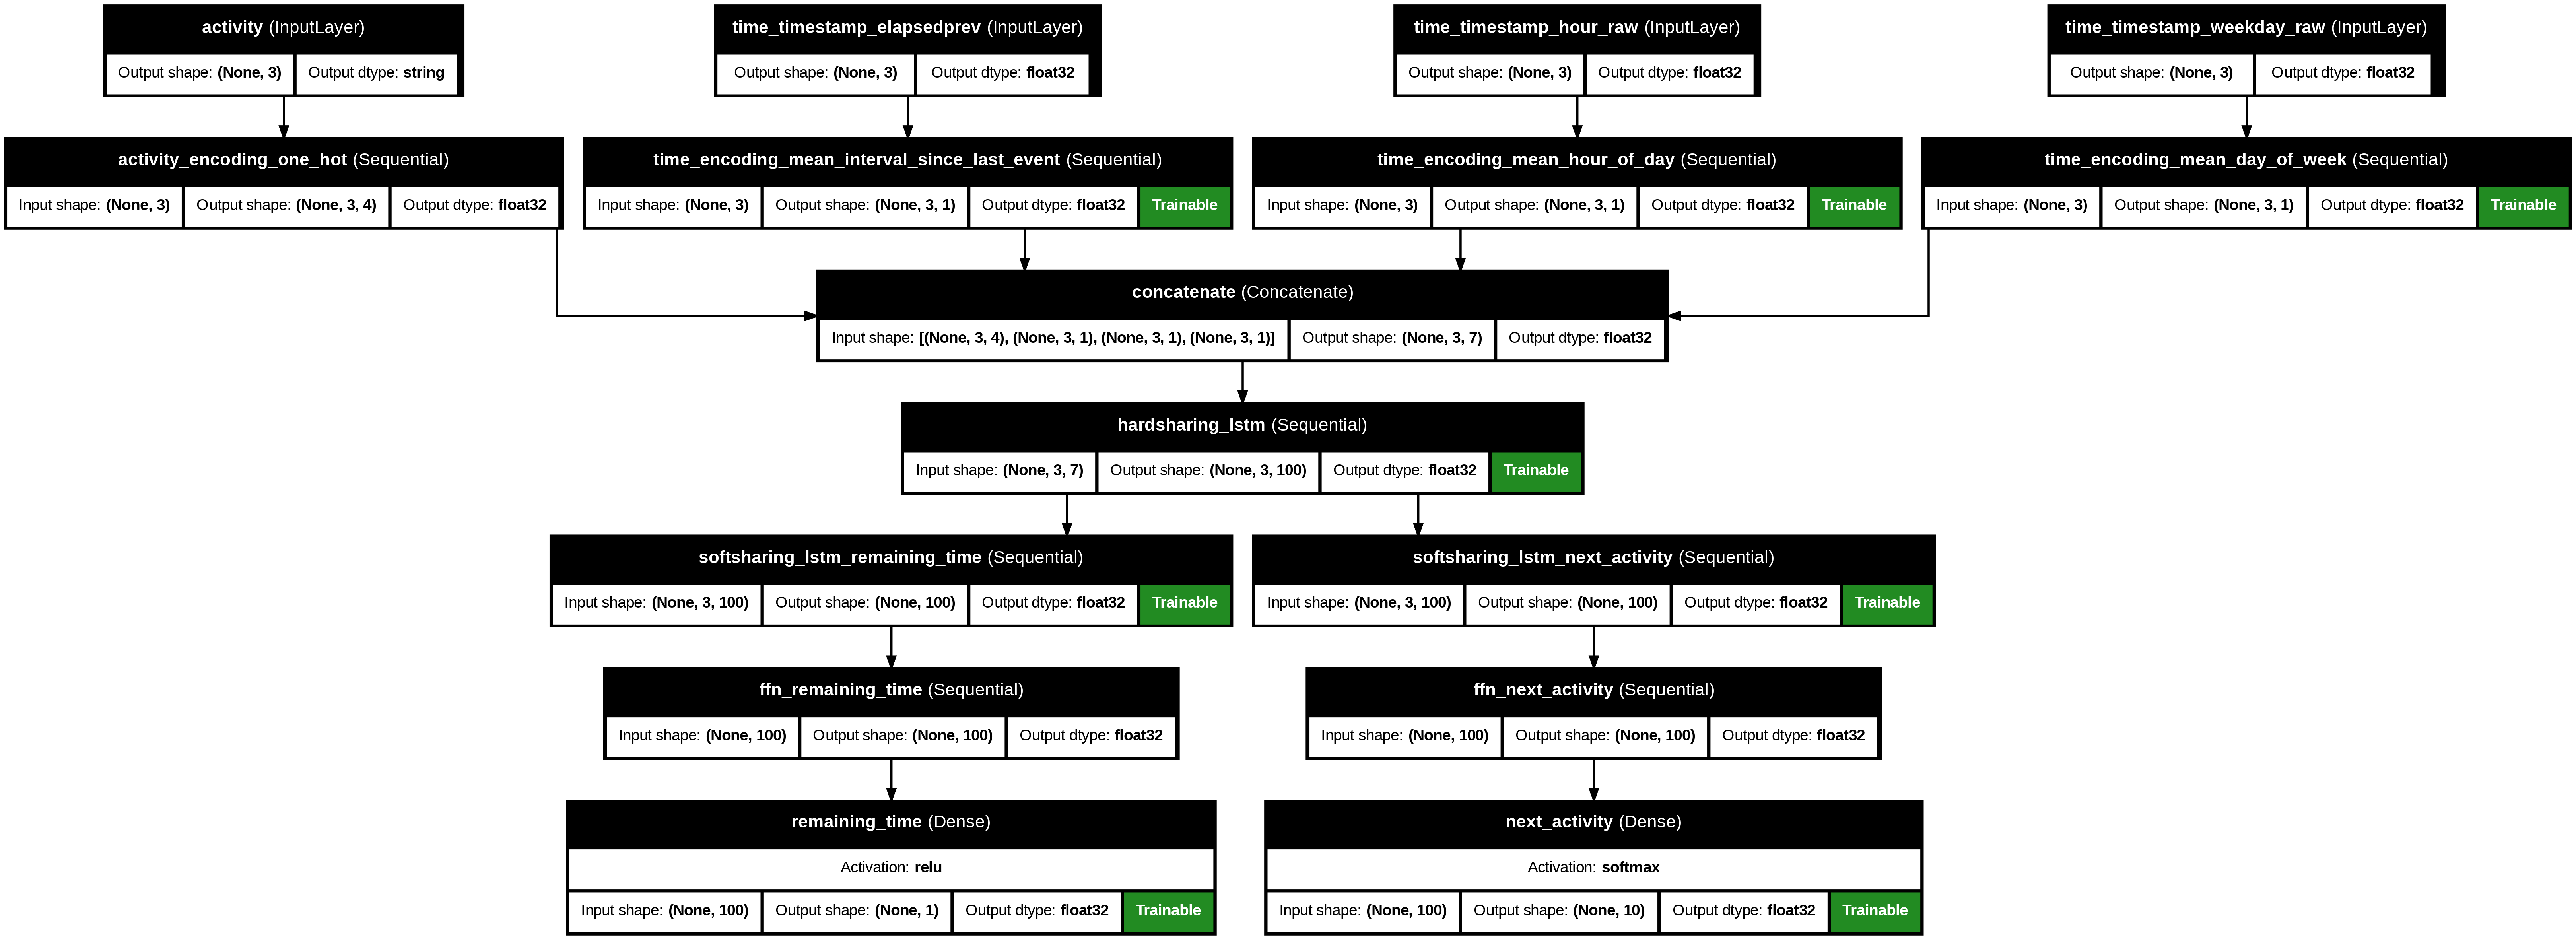

In [19]:
keras.utils.plot_model(
  lstm,
  show_shapes=True,
  show_dtype=True,
  show_layer_names=True,
  expand_nested=True,
  show_layer_activations=True,
  show_trainable=True,
)


## Transformer

### ProcessTransformer

In [20]:
class BaseProcessTransformer(keras.Model, LayerNameMixin, BaseModelMixin):
  """A base Transformer model for process mining tasks with shared and task-specific layers. Provides a structured and more flexible reimplementation of the work by Bukhsh et al. 2021 (https://github.com/Zaharah/processtransformer).

  The default parameters represent the original model architecture with its hyperparameters.

  This model implements a neural architecture for process mining that combines:
  - Multiple input features (activities, temporal features)
  - Positional encodings for sequence information
  - Shared Transformer encoder layers for common feature extraction
  - Task-specific Transformer encoder layers for different prediction tasks
  - Configurable desequentialization and feed-forward layers

  The architecture follows a multi-task learning approach where lower layers are shared
  across all tasks while upper layers are task-specific. The model processes sequential
  data using self-attention mechanisms and can handle variable-length sequences up to
  max_case_len.

  Args:
      max_case_len (int): Maximum length of process cases/sequences
      output_dict (Dict[str, dict]): Configuration for output layers. Format: {"task_name": {"units": int, "activation": str}} Example: {"remaining_time": {'units': 1, 'activation': 'relu'}, "next_activity": {'units': 10, 'activation': 'softmax'}}
      activity_vocab (List[str]): Vocabulary of possible process activities
      activity_encoding_type (str, optional): Type of activity encoding. Currently only supports "embedding". Defaults to "embedding"
      time_encoding_type (str, optional): Type of time feature encoding. Options: "mean", "minmax", or "normal". Defaults to "mean"
      interval_since_last_event_vocab (List[float], optional): Vocabulary for time intervals
      hour_of_day_vocab (List[float], optional): Vocabulary for hour features
      day_of_week_vocab (List[float], optional): Vocabulary for day of week features
      activity_embedding_dim (int): Dimension for activity embeddings. Defaults to 36
      pos_encoding_type (str, optional): Type of positional encoding. Options: "sincos", "learned", "rotary", or "temporal". Defaults to "learned"
      enc_heads_shared (List[int]): Number of attention heads in each shared encoder layer. Defaults to [4]
      enc_ff_dims_shared (List[int]): Feed-forward dimensions in each shared encoder layer. Defaults to [64]
      enc_heads_nonshared (List[int]): Number of attention heads in task-specific layers. Defaults to []
      enc_ff_dims_nonshared (List[int]): Feed-forward dimensions in task-specific layers. Defaults to []
      enc_dropout (float): Dropout rate for encoder layers. Defaults to 0.0
      enc_activation (str): Activation function for encoder layers. Defaults to "relu"
      enc_normalize_first (bool): Whether to apply normalization before attention and feed-forward layers. Defaults to False
      deseq_type (str): Method to convert sequences to fixed-size vectors. Options: "maxpool", "avgpool", "flatten". Defaults to "maxpool"
      ff_dims (List[int]): Units in each final feed-forward layer. Defaults to [32, 128]
      ff_dropout (float): Dropout rate for final feed-forward layers. Defaults to 0.0
      ff_activation (str): Activation for final feed-forward layers. Defaults to "relu"
      numeric_mask_token (float): Token used for masking numeric values. Defaults to TOKEN_PAD_NUM
      mask_token (str): Token used for masking categorical values. Defaults to TOKEN_PAD
      oov_token (str): Token used for out-of-vocabulary values. Defaults to TOKEN_OOV

  Raises:
      ValueError: If enc_heads_shared or enc_ff_dims_shared is empty

  Author:
      Marc C. Hennig (mhennig@hm.edu)
  """
  def __init__(
    self,
    max_case_len: int,
    output_dict: Dict[str, dict],
    activity_vocab: List[str],
    activity_encoding_type: Optional[Literal['embedding']] = 'embedding',
    time_encoding_type: Optional[Literal['mean', 'minmax', 'normal']] = 'mean',
    interval_since_last_event_vocab: Optional[List[float]] = None,
    hour_of_day_vocab: Optional[List[float]] = None,
    day_of_week_vocab: Optional[List[float]] = None,
    activity_embedding_dim: int = 36,
    pos_encoding_type: Optional[Literal['sincos', 'learned', 'rotary', 'temporal']] = 'learned',
    enc_heads_shared: List[int] = [4],
    enc_ff_dims_shared: List[int] = [64],
    enc_heads_nonshared: List[int] = [],
    enc_ff_dims_nonshared: List[int] = [],
    enc_dropout: float = 0.0,
    enc_activation: str = 'relu',
    enc_normalize_first: bool = False,
    deseq_type: Literal['maxpool', 'avgpool', 'flatten'] = 'maxpool',
    ff_dims: List[int] = [32, 128],
    ff_dropout: float = 0.0,
    ff_activation: str = 'relu',
    numeric_mask_token: float = TOKEN_PAD_NUM,
    mask_token: str = TOKEN_PAD,
    oov_token: str = TOKEN_OOV,
    **kwargs
  ):
    super().__init__(**kwargs)
    if not len(enc_heads_shared) > 0 or not len(enc_ff_dims_shared) > 0:
      raise ValueError(f"enc_heads_nonshared and enc_ff_dim_nonshared must be at least 1")

    self.max_case_len = max_case_len
    self.output_dict = output_dict

    self.activity_encoding_type = activity_encoding_type
    self.activity_vocab = activity_vocab
    self.activity_embedding_dim = activity_embedding_dim

    self.time_encoding_type = time_encoding_type
    self.pos_encoding_type = pos_encoding_type

    self.enc_heads_shared = enc_heads_shared
    self.enc_ff_dims_shared = enc_ff_dims_shared
    self.enc_heads_nonshared = enc_heads_nonshared
    self.enc_ff_dims_nonshared = enc_ff_dims_nonshared
    self.enc_dropout = enc_dropout
    self.enc_activation = enc_activation
    self.enc_normalize_first = enc_normalize_first

    self.deseq_type = deseq_type

    self.ff_dims = ff_dims
    self.ff_dropout = ff_dropout
    self.ff_activation = ff_activation

    self.numeric_mask_token = numeric_mask_token
    self.mask_token = mask_token
    self.oov_token = oov_token

    self.activity_encoding = self._build_activity_encoding_layer()
    self.interval_since_last_event_encoding = self._build_time_encoding_layer(vocab=interval_since_last_event_vocab, name="interval_since_last_event")
    self.hour_of_day_encoding = self._build_time_encoding_layer(vocab=hour_of_day_vocab, name="hour_of_day")
    self.day_of_week_encoding = self._build_time_encoding_layer(vocab=day_of_week_vocab, name="day_of_week")

    self.pos_encoding = self._build_positional_encoding_layer()

    self.shared_encoder = self._build_hard_shared_transformer_encoder_layer()

    self.non_shared_encoders = []
    self.deseqs = []
    self.ff_layers = []
    self.outputs = []
    for output_name, output_config in self.output_dict.items():
      self.non_shared_encoders.append(self._build_soft_shared_transformer_encoder_layer(name=output_name))
      self.deseqs.append(self._build_desequentialization_layer(name=output_name))
      self.ff_layers.append(self._build_ffn_layer(name=output_name))
      self.outputs.append(keras.layers.Dense(
          units=output_config['units'],
          activation=output_config['activation'],
          name=output_name
      ))

  @property
  def default_loss(self) -> Dict[str, keras.Loss]:
    return {k: self.find_default_loss(v['activation']) for k, v in self.output_dict.items()}

  @property
  def default_metrics(self) -> Dict[str, List[keras.Metric]]:
    return {k: self.find_default_metrics(v['activation']) for k, v in self.output_dict.items()}

  @property
  def default_learning_rate(self) -> Union[float, keras.optimizers.schedules.LearningRateSchedule]:
    return 0.001

  @property
  def default_optimizer(self) -> keras.optimizers.Optimizer:
    return keras.optimizers.Adam(learning_rate=self.default_learning_rate)

  @property
  def default_regression_loss(self) -> keras.Loss:
    return keras.losses.LogCosh()

  def _build_activity_encoding_layer(self, name: Optional[str] = None, **kwargs) -> keras.layers.Layer:
    """Builds an activity encoding layer based on the specified encoding type.

    Currently only supports embedding-based encoding, which converts activity names
    to dense vectors of fixed dimensionality.

    Args:
        name (str, optional): Name prefix for the layer
        **kwargs: Additional keyword arguments passed to the layers

    Returns:
        keras.layers.Layer: Layer for activity encoding

    Raises:
        NotImplementedError: If activity_encoding_type is not "embedding"
    """
    name = self._generate_layer_name(f"activity_encoding_{self.activity_encoding_type}", name)

    if self.activity_encoding_type is None:
      layer = keras.layers.Identity(name=name)
    elif 'embedding' == self.activity_encoding_type:
      lookup = keras.layers.StringLookup(
        mask_token=self.mask_token,
        oov_token=self.oov_token,
        output_mode='int',
        pad_to_max_tokens=False,
      )
      lookup.adapt(self.activity_vocab)

      layer = keras.models.Sequential([
        lookup,
        keras.layers.Embedding(
          input_dim=len(lookup.get_vocabulary()),
          output_dim=self.activity_embedding_dim,
          mask_zero=True,
        )],
        name=name,
      )
    else:
      raise NotImplementedError(f"Unknown activity encoding type {self.activity_encoding_type}")

    return layer

  def _build_time_encoding_layer(self, vocab: Optional[List[float]] = None, name: Optional[str] = None, **kwargs) -> keras.layers.Layer:
    """Builds a time encoding layer based on the specified encoding type.

    Args:
        vocab (List[float], optional): Vocabulary of time values for adaptation
        name (str, optional): Name prefix for the layer
        **kwargs: Additional keyword arguments passed to the layers

    Returns:
        keras.layers.Layer: Sequential layer for time feature encoding

    Raises:
        NotImplementedError: If time_encoding_type is not one of [None, "mean", "minmax", "normal"]
    """
    name = self._generate_layer_name(f"time_encoding_{self.time_encoding_type}", name)
    layer = keras.models.Sequential([keras.layers.Masking(self.numeric_mask_token)], name=name)

    if self.time_encoding_type is None:
      layer.add(keras.layers.Identity(name=name))
    elif 'mean' == self.time_encoding_type:
      lookup = MeanScaler(axis=None)
      lookup.adapt(vocab)
      layer.add(lookup)
    elif 'minmax' == self.time_encoding_type:
      lookup = MinMaxScaler(axis=None)
      lookup.adapt(vocab)
      layer.add(lookup)
    elif 'normal' == self.time_encoding_type:
      lookup = keras.layers.Normalization(axis=None)
      lookup.adapt(vocab)
      layer.add(lookup)
    else:
      raise NotImplementedError(f"Unknown time encoding type {self.time_encoding_type}")

    return layer

  def _build_positional_encoding_layer(self, **kwargs) -> keras.layers.Layer:
    """Builds a positional encoding layer to inject sequence order information.

    Supports multiple types of positional encodings:
    - sincos: Sinusoidal position encoding (Vaswani et al., 2017)
    - learned: Trainable position embeddings
    - rotary: Rotary position embeddings (Su et al., 2021)
    - temporal: Time-aware position encoding (not implemented)

    Args:
        **kwargs: Additional keyword arguments passed to the position encoding layer

    Returns:
        keras.layers.Layer: Positional encoding layer

    Raises:
        NotImplementedError: If pos_encoding_type is "temporal" or unknown
    """
    if self.pos_encoding_type is None:
      layer = keras.layers.Identity()
    elif 'sincos' == self.pos_encoding_type:
      layer = keras_nlp.layers.SinePositionEncoding(**kwargs)
    elif 'learned' == self.pos_encoding_type:
      layer = keras_nlp.layers.PositionEmbedding(sequence_length=self.max_case_len, **kwargs)
    elif 'rotary' == self.pos_encoding_type:
      layer = keras_nlp.layers.RotaryEmbedding(**kwargs)
    elif 'temporal' == self.pos_encoding_type:
      raise NotImplementedError(f"Temporal positional encoding is not yet implemented")
    else:
      raise NotImplementedError(f"Unknown positional encoding type {self.pos_encoding_type}")

    return layer

  def _build_desequentialization_layer(self, name: Optional[str] = None, **kwargs) -> keras.layers.Layer:
    """Builds a layer to convert variable-length sequences to fixed-size vectors.

    Supports multiple pooling strategies:
    - maxpool: Global max pooling across the sequence
    - avgpool: Global average pooling across the sequence
    - flatten: Flattens the entire sequence (preserves all information but loses
      sequence invariance)

    Args:
        name (str, optional): Name prefix for the layer
        **kwargs: Additional keyword arguments passed to the layer

    Returns:
        keras.layers.Layer: Desequentialization layer

    Raises:
        NotImplementedError: If deseq_type is unknown
    """
    name = self._generate_layer_name(f"{self.deseq_type}", name)

    if 'maxpool' == self.deseq_type:
      layer = keras.layers.GlobalMaxPooling1D(name=name, **kwargs)
    elif 'avgpool' == self.deseq_type:
      layer = keras.layers.GlobalAveragePooling1D(name=name, **kwargs)
    elif 'flatten' == self.deseq_type:
      layer = keras.layers.Flatten(name=name, **kwargs)
    else:
      raise NotImplementedError(f"Unknown desequentialization type {self.deseq_type}")

    return layer

  def _build_hard_shared_transformer_encoder_layer(self, name: Optional[str] = None, **kwargs) -> List[keras.Layer]:
    """Builds the shared Transformer encoder layers used across all tasks.

    Creates a stack of Transformer encoder layers with specified number of attention
    heads and feed-forward dimensions. These layers learn general process patterns
    shared across all prediction tasks.

    Args:
        name (str, optional): Name prefix for the layer
        **kwargs: Additional keyword arguments passed to TransformerEncoder

    Returns:
        List[keras.Layer]: List of shared Transformer encoder layers
    """
    name = self._generate_layer_name(f"hardsharing_transformer_encoder", name)
    layer = keras.models.Sequential(name=name)

    for num_heads, ff_dim in zip(self.enc_heads_shared, self.enc_ff_dims_shared, strict=True):
      layer.add(keras_nlp.layers.TransformerEncoder(
          intermediate_dim=ff_dim,
          num_heads=num_heads,
          dropout=self.enc_dropout,
          activation=self.enc_activation,
          normalize_first=self.enc_normalize_first,
          **kwargs
      ))

    return layer

  def _build_soft_shared_transformer_encoder_layer(self, name: Optional[str] = None, **kwargs) -> keras.Layer:
    """Builds task-specific Transformer encoder layers.

    Creates a stack of Transformer encoder layers that are specific to each prediction
    task, allowing specialization for different objectives.

    Args:
        name (str, optional): Name prefix for the layer
        **kwargs: Additional keyword arguments passed to TransformerEncoder

    Returns:
        keras.Layer: Sequential model containing task-specific Transformer encoder layers
    """
    name = self._generate_layer_name(f"softsharing_transformer_encoder", name)
    layer = keras.models.Sequential([keras.layers.Identity()], name=name)

    for num_heads, ff_dim in zip(self.enc_heads_nonshared, self.enc_ff_dims_nonshared, strict=True):
      layer.add(keras_nlp.layers.TransformerEncoder(
          intermediate_dim=ff_dim,
          num_heads=num_heads,
          dropout=self.enc_dropout,
          activation=self.enc_activation,
          normalize_first=self.enc_normalize_first,
          **kwargs
      ))

    return layer

  def _build_ffn_layer(self, name: Optional[str] = None, **kwargs) -> keras.layers.Layer:
    """Builds feed-forward layers with optional dropout.

    Args:
        name (str, optional): Name prefix for the layer
        **kwargs: Additional keyword arguments passed to the layers

    Returns:
        keras.layers.Layer: Sequential model containing feed-forward layers
    """
    name = self._generate_layer_name("ffn", name)
    layer = keras.models.Sequential(name=name)

    for ff_dim in self.ff_dims:
      layer.add(keras.layers.Dense(units=ff_dim, activation=self.ff_activation))
      layer.add(keras.layers.Dropout(self.ff_dropout))

    return layer

  def build_graph(self) -> keras.Model:
    """Builds and returns a Keras Model instance with the defined architecture.

    Returns:
        keras.Model: Compiled model with defined inputs and outputs
    """
    in_activity = keras.layers.Input(shape=(self.max_case_len,), name="activity", dtype='string')
    in_interval_since_last_event = keras.layers.Input(shape=(1,), name="time_timestamp_elapsedprev", dtype='float32')
    in_hour_of_day = keras.layers.Input(shape=(1,), name="time_timestamp_hour_raw", dtype='float32')
    in_day_of_week = keras.layers.Input(shape=(1,), name="time_timestamp_weekday_raw", dtype='float32')

    inputs = {
        "activity": in_activity,
        "time_timestamp_elapsedprev": in_interval_since_last_event,
        "time_timestamp_hour_raw": in_hour_of_day,
        "time_timestamp_weekday_raw": in_day_of_week,
    }

    return keras.Model(inputs=[in_activity, in_interval_since_last_event, in_hour_of_day, in_day_of_week], outputs=self.call(in_activity, in_interval_since_last_event, in_hour_of_day, in_day_of_week), name=self.name)

  def call(self, inputs, inputs_interval_since_last_event, inputs_hour_of_day, inputs_day_of_week, training=False):
    x_activity = self.activity_encoding(inputs)
    x_interval = self.interval_since_last_event_encoding(inputs_interval_since_last_event)
    x_hour = self.hour_of_day_encoding(inputs_hour_of_day)
    x_day = self.day_of_week_encoding(inputs_day_of_week)

    if self.pos_encoding_type is None or 'rotary' == self.pos_encoding_type:
      x_activity = self.pos_encoding(x_activity)
    elif 'learned' == self.pos_encoding_type or 'sincos' == self.pos_encoding_type:
      x_activity = keras.layers.add([self.pos_encoding(x_activity), x_activity])
    else:
      raise NotImplementedError(f"Unknown positional encoding type {self.pos_encoding_type}")

    x_activity = self.shared_encoder(x_activity)

    x_outputs = []
    for encoder, deseq, ff_layer, output in zip(self.non_shared_encoders, self.deseqs, self.ff_layers, self.outputs, strict=True):
      x_nonshared = encoder(x_activity)
      x_nonshared = deseq(x_nonshared)
      x_nonshared = keras.layers.concatenate([x_nonshared, x_interval, x_hour, x_day])
      x_nonshared = ff_layer(x_nonshared)
      x_outputs.append(output(x_nonshared))

    return x_outputs

In [21]:
trans = BaseProcessTransformer(
    max_case_len=10,
    activity_vocab=['a', 'b', 'c'],
    interval_since_last_event_vocab=np.array([1,2,3]),
    hour_of_day_vocab=np.array([1,2,3]),
    day_of_week_vocab=np.array([1,2,3]),
    output_dict={"remaining_time": {'units': 1, 'activation': 'relu'}, "next_activity": {'units': 10, 'activation': 'softmax'}},
)

trans = trans.build_graph()
trans.summary()

Model: "base_process_transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ activity            │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activity_encoding_… │ (None, 10, 36)    │        180 │ activity[0][0]    │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, 10, 36)    │        360 │ activity_encodin… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 36)    │          0 │ position_embeddi… │
│                     │                   │            │ activity_encodin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hardsharing_transf… │ (None, 10, 36)    │     10,180 │ add[0][0]         │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softsharing_transf… │ (None, 10, 36)    │          0 │ hardsharing_tran… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_timestamp_ela… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_timestamp_hou… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_timestamp_wee… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softsharing_transf… │ (None, 10, 36)    │          0 │ hardsharing_tran… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool_remaining_… │ (None, 36)        │          0 │ softsharing_tran… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_encoding_mean… │ (None, 1)         │          1 │ time_timestamp_e… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_encoding_mean… │ (None, 1)         │          1 │ time_timestamp_h… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_encoding_mean… │ (None, 1)         │          1 │ time_timestamp_w… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool_next_activ… │ (None, 36)        │          0 │ softsharing_tran… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 39)        │          0 │ maxpool_remainin… │
│ (Concatenate)       │                   │            │ time_encoding_me… │
│                     │                   │            │ time_encoding_me… │
│                     │                   │            │ time_encoding_me

 Total params: 23,150 (90.43 KB)

 Trainable params: 23,147 (90.42 KB)

 Non-trainable params: 3 (12.00 B)

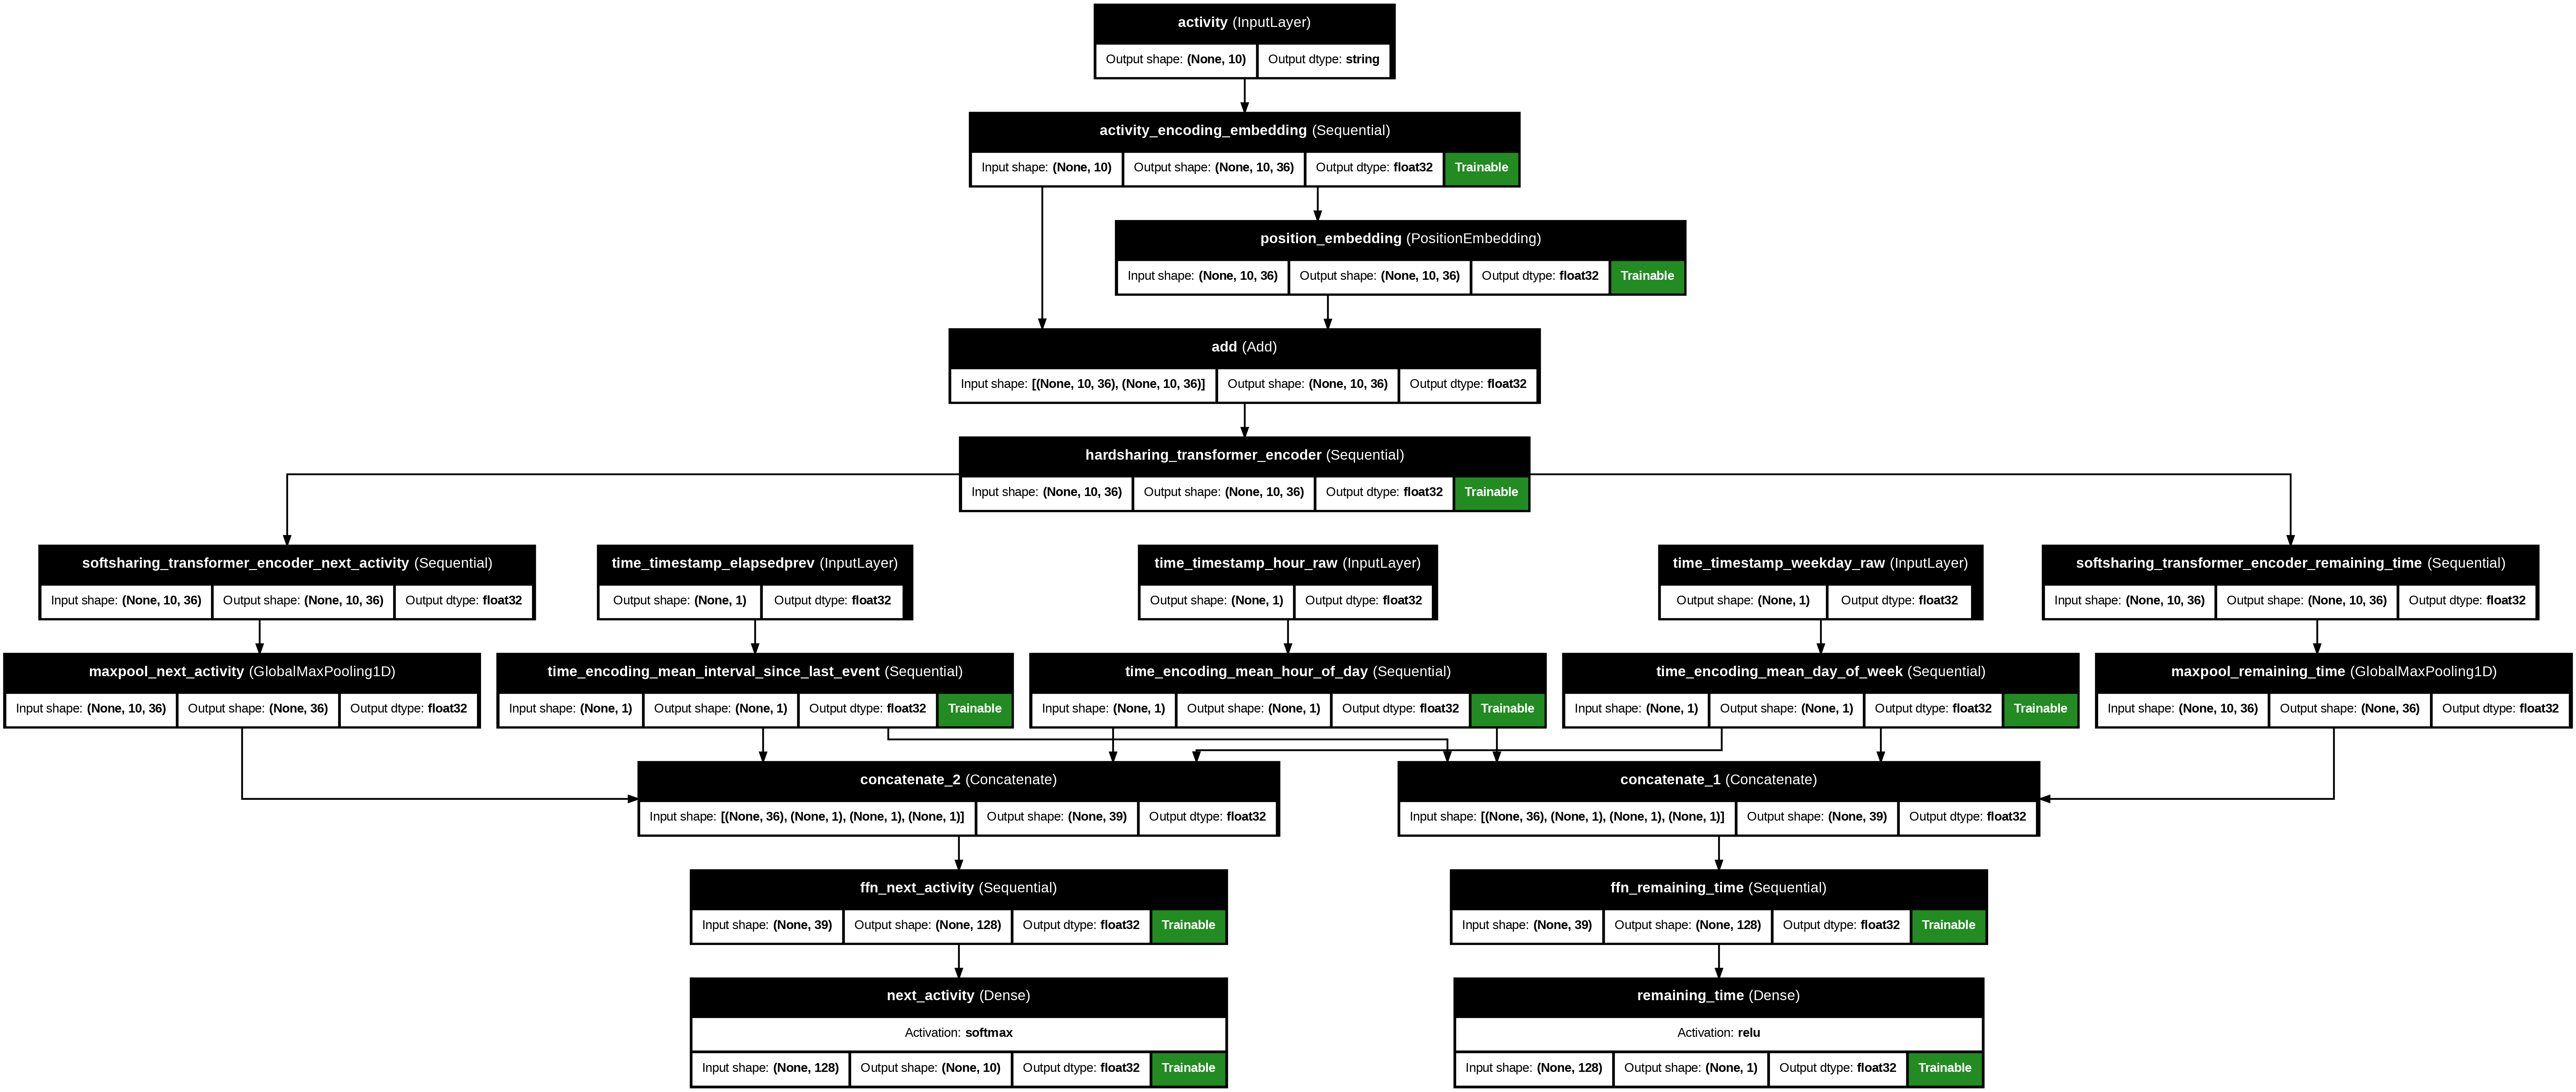

In [22]:
keras.utils.plot_model(
  trans,
  show_shapes=True,
  show_dtype=True,
  show_layer_names=True,
  expand_nested=True,
  show_layer_activations=True,
  show_trainable=True,
)


### Custom Hierarchical Transformer

#### Dynamic Attribute Selection Network

In [23]:
@keras.saving.register_keras_serializable()
class DynamicAttributeSelectionNetwork(keras.Layer):
  """A custom Keras layer that implements a dynamic attribute selection mechanism using
    transformer decoders and a variable selection network (VSN) or other flattening strategies. Based on the work of Hennig 2025.

    This layer is designed to process sequential data and dynamically select relevant attributes
    based on the input sequence. It supports multiple flattening strategies, including VSN,
    average pooling, max pooling, and standard flattening.

    Attributes:
        dec_num_heads (int): Number of attention heads in the transformer decoder.
        dec_ff_dim (int): Intermediate dimension of the feedforward network in the transformer decoder.
        var_units (int): Number of units in the variable selection network (VSN) or GRN layers.
        var_dropout (float): Dropout rate for the variable selection network (VSN) or GRN layers.
        var_activation (str): Activation function for the variable selection network (VSN) or GRN layers.
        dec_depth (int): Number of transformer decoder layers.
        dec_dropout (float): Dropout rate for the transformer decoder layers.
        dec_activation (str): Activation function for the transformer decoder layers.
        dec_layer_norm_epsilon (float): Epsilon value for layer normalization in the transformer decoder.
        dec_kernel_init (Union[str, keras.Initializer]): Kernel initializer for the transformer decoder.
        dec_bias_init (Union[str, keras.Initializer]): Bias initializer for the transformer decoder.
        dec_normalize_first (bool): Whether to normalize inputs before attention and feedforward layers.
        grn_depth (int): Number of Gated Residual Network (GRN) layers in the flattening module.
        grn_dropout (float): Dropout rate for the GRN layers.
        grn_activation (str): Activation function for the GRN layers.
        glu_activation (str): Activation function for the Gated Linear Unit (GLU) in GRN layers.
        flattening (Literal['vsn', 'avg_pool', 'max_pool', 'flatten']): Flattening strategy to use.

    Author:
        Marc C. Hennig (mhennig@hm.edu)
    """
  def __init__(
    self,
    dec_num_heads: int,
    dec_ff_dim: int,
    var_units: int,
    var_dropout: float = 0.0,
    var_activation: str = 'elu',
    dec_depth: int = 1,
    dec_dropout: float = 0.0,
    dec_activation: str = 'relu',
    dec_layer_norm_epsilon: float = 1e-05,
    dec_kernel_init: Union[str, keras.Initializer] = 'glorot_uniform',
    dec_bias_init: Union[str, keras.Initializer] = 'zeros',
    dec_normalize_first: bool = False,
    grn_depth: int = 0,
    grn_dropout: float = 0.0,
    grn_activation: str = 'elu',
    glu_activation: str = 'sigmoid',
    flattening: Literal['vsn', 'avg_pool', 'max_pool', 'flatten'] = 'vsn',
    **kwargs
  ):
    super().__init__(**kwargs)

    self.dec_depth = dec_depth
    self.dec_num_heads = dec_num_heads
    self.dec_ff_dim = dec_ff_dim
    self.dec_dropout = dec_dropout
    self.dec_activation = dec_activation
    self.dec_layer_norm_epsilon = dec_layer_norm_epsilon
    self.dec_kernel_init = dec_kernel_init
    self.dec_bias_init = dec_bias_init
    self.dec_normalize_first = dec_normalize_first

    self.var_units = var_units
    self.var_dropout = var_dropout
    self.var_activation = var_activation

    self.grn_depth = grn_depth
    self.grn_dropout = grn_dropout
    self.grn_activation = grn_activation
    self.glu_activation = glu_activation

    self.flattening = flattening

  def build(self, input_shape: Tuple[int, int]):
    self.max_feat_len = input_shape[-1]
    self.max_seq_len = input_shape[-2]

    self.decoders = []
    for i in range(self.dec_depth):
      dec = keras_nlp.layers.TransformerDecoder(
        num_heads=self.dec_num_heads,
        intermediate_dim=self.dec_ff_dim,
        dropout=self.dec_dropout,
        activation=self.dec_activation,
        layer_norm_epsilon=self.dec_layer_norm_epsilon,
        kernel_initializer=self.dec_kernel_init,
        bias_initializer=self.dec_bias_init,
        normalize_first=self.dec_normalize_first,
      )
      self.decoders.append(dec)

    if 'vsn' == self.flattening:
      self.flatten = VariableSelectionNetwork(
        units=self.var_units,
        dropout=self.var_dropout,
        grn_depth=self.grn_depth,
        grn_activation=self.var_activation,
        glu_activation=self.glu_activation,
    )
    elif 'avg_pool' == self.flattening:
      self.flatten = keras.models.Sequential()
      self.flatten.add(keras.layers.GlobalAveragePooling1D(data_format='channels_last'))
      for _ in range(self.grn_depth):
        self.flatten.add(GatedResidualNetwork(
            units=self.max_feat_len,
            dropout=self.var_dropout,
            non_linear_activation=self.var_activation,
            glu_activation=self.glu_activation,
        ))
      self.flatten.add(GatedResidualNetwork(self.var_units, self.var_dropout, self.var_activation, self.glu_activation))
    elif 'max_pool' == self.flattening:
      self.flatten = keras.models.Sequential()
      self.flatten.add(keras.layers.GlobalMaxPooling1D(data_format='channels_last'))
      for _ in range(self.grn_depth):
        self.flatten.add(GatedResidualNetwork(
            units=self.max_feat_len,
            dropout=self.var_dropout,
            non_linear_activation=self.var_activation,
            glu_activation=self.glu_activation,
        ))
      self.flatten.add(GatedResidualNetwork(self.var_units, self.var_dropout, self.var_activation, self.glu_activation))
    elif 'flatten' == self.flattening:
      self.flatten = keras.models.Sequential()
      self.flatten.add(keras.layers.Flatten(data_format='channels_last'))
      for _ in range(self.grn_depth):
        self.flatten.add(GatedResidualNetwork(
            units=self.max_feat_len * self.max_seq_len,
            dropout=self.var_dropout,
            non_linear_activation=self.var_activation,
            glu_activation=self.glu_activation,
        ))
      self.flatten.add(GatedResidualNetwork(self.var_units, self.var_dropout, self.var_activation, self.glu_activation))

  def call(self, encoder_seq, decoder_seq, encoder_padding_mask=None, decoder_padding_mask=None):
    x = decoder_seq
    for dec in self.decoders:
      x = dec(
        decoder_sequence=x,
        decoder_padding_mask=decoder_padding_mask,
        encoder_sequence=encoder_seq,
        encoder_padding_mask=encoder_padding_mask,
        use_causal_mask=False,
      )

    if 'vsn' == self.flattening:
      x = keras.ops.unstack(x, axis=-2)
      x = self.flatten(x, mask=encoder_padding_mask)
    else:
      x = self.flatten(x)

    return x

#### Static Attribute Selection Network

In [24]:
@keras.saving.register_keras_serializable()
class StaticAttributeSelectionNetwork(keras.Layer):
  """A custom Keras layer that implements a static attribute selection mechanism using
    Gated Residual Networks (GRNs) and a Variable Selection Network (VSN).

    This layer is designed to process multiple input sequences (attributes) and dynamically
    select relevant features using a combination of GRNs and VSN. It is particularly useful
    for tasks involving multi-modal or multi-attribute data.

    Attributes:
        var_units (int): Number of units in the Variable Selection Network (VSN) and GRNs.
        var_dropout (float): Dropout rate for the Variable Selection Network (VSN) and GRNs.
        var_activation (str): Activation function for the Variable Selection Network (VSN).
        grn_dim (Optional[Union[int, List[int]]]): Dimensions of the Gated Residual Networks (GRNs).
        grn_dropout (float): Dropout rate for the GRNs.
        grn_activation (str): Activation function for the GRNs.
        glu_activation (str): Activation function for the Gated Linear Unit (GLU) in GRNs.

    Author:
        Marc C. Hennig (mhennig@hm.edu)
  """
  def __init__(
    self,
    var_units: int,
    var_dropout: float = 0.0,
    var_activation: str = 'elu',
    grn_depth: int = 0,
    grn_dropout: float = 0.0,
    grn_activation: str = 'elu',
    glu_activation: str = 'sigmoid',
    **kwargs
  ):
    super().__init__(**kwargs)

    self.var_units = var_units
    self.var_dropout = var_dropout
    self.var_activation = var_activation

    self.grn_depth = grn_depth
    self.grn_dropout = grn_dropout
    self.grn_activation = grn_activation
    self.glu_activation = glu_activation

  def build(self, input_shape: List[Tuple[int, int, int]]):
    self.num_attrs = len(input_shape)

    self.var_selection_net = VariableSelectionNetwork(
      units=self.var_units,
      dropout=self.var_dropout,
      grn_depth=self.grn_depth,
      grn_activation=self.var_activation,
      glu_activation=self.glu_activation,
    )

  def call(self, inputs):
    x = [keras.ops.squeeze(input, axis=-2) for input in inputs]
    x = self.var_selection_net(x, mask=keras.ops.ones(self.num_attrs, dtype=bool))
    return x


#### Activity & Timestamp Encoder Network

In [25]:
@keras.saving.register_keras_serializable()
class ActivityEncoderNetwork(keras.Layer):
  """A custom Keras layer that implements an activity encoder network using transformer encoders,
    Gated Residual Networks (GRNs), and a Variable Selection Network (VSN). Provides an implementation of the work by Hennig (2024).

    This layer is designed to process sequential data (e.g., activity sequences) and encode it
    into a meaningful representation. It combines transformer encoders for sequence modeling,
    GRNs for feature processing, and a VSN for dynamic feature selection.

    Attributes:
        enc_num_heads (Union[int, List[int]]): Number of attention heads in the transformer encoders.
        enc_ff_dim (Union[int, List[int]]): Intermediate dimension of the feedforward network in the transformer encoders.
        var_units (int): Number of units in the Variable Selection Network (VSN) and GRNs.
        enc_dropout (float): Dropout rate for the transformer encoders.
        enc_activation (str): Activation function for the transformer encoders.
        enc_layer_norm_epsilon (float): Epsilon value for layer normalization in the transformer encoders.
        enc_kernel_init (Union[str, keras.Initializer]): Kernel initializer for the transformer encoders.
        enc_bias_init (Union[str, keras.Initializer]): Bias initializer for the transformer encoders.
        enc_normalize_first (bool): Whether to normalize inputs before attention and feedforward layers.
        var_dropout (float): Dropout rate for the Variable Selection Network (VSN) and GRNs.
        var_activation (str): Activation function for the Variable Selection Network (VSN).
        grn_dim (Optional[Union[int, List[int]]]): Dimensions of the Gated Residual Networks (GRNs).
        grn_dropout (float): Dropout rate for the GRNs.
        grn_activation (str): Activation function for the GRNs.
        glu_activation (str): Activation function for the Gated Linear Unit (GLU) in GRNs.

    Author:
        Marc C. Hennig (mhennig@hm.edu)
    """
  def __init__(
    self,
    enc_num_heads: int,
    enc_ff_dim: int,
    var_units: int,
    enc_depth: int = 1,
    enc_dropout: float = 0.0,
    enc_activation: str ='relu',
    enc_layer_norm_epsilon: float = 1e-05,
    enc_kernel_init: Union[str, keras.Initializer] = 'glorot_uniform',
    enc_bias_init: Union[str, keras.Initializer] ='zeros',
    enc_normalize_first: bool = False,
    var_dropout: float = 0.0,
    var_activation: str = 'elu',
    grn_depth: int = 0,
    grn_dropout: float = 0.0,
    grn_activation: str = 'elu',
    glu_activation: str = 'sigmoid',
    flattening: Literal['vsn', 'avg_pool', 'max_pool', 'flatten'] = 'vsn',
    **kwargs,
  ):
    super().__init__(**kwargs)

    self.enc_depth = enc_depth
    self.enc_num_heads = enc_num_heads
    self.enc_ff_dim = enc_ff_dim
    self.enc_dropout = enc_dropout
    self.enc_activation = enc_activation
    self.enc_layer_norm_epsilon = enc_layer_norm_epsilon
    self.enc_kernel_init = enc_kernel_init
    self.enc_bias_init = enc_bias_init
    self.enc_normalize_first = enc_normalize_first

    self.var_units = var_units
    self.var_dropout = var_dropout
    self.var_activation = var_activation

    self.grn_depth = grn_depth
    self.grn_dropout = grn_dropout
    self.grn_activation = grn_activation
    self.glu_activation = glu_activation

    self.flattening = flattening

  def build(self, input_shape):
    self.max_feat_len = input_shape[-1]
    self.max_seq_len = input_shape[-2]

    self.encoders = []
    for _ in range(self.enc_depth):
      enc = keras_nlp.layers.TransformerEncoder(
        intermediate_dim=self.enc_ff_dim,
        num_heads=self.enc_num_heads,
        dropout=self.enc_dropout,
        activation=self.enc_activation,
        layer_norm_epsilon=self.enc_layer_norm_epsilon,
        kernel_initializer=self.enc_kernel_init,
        bias_initializer=self.enc_bias_init,
        normalize_first=self.enc_normalize_first,
      )
      self.encoders.append(enc)

    if 'vsn' == self.flattening:
      self.flatten = VariableSelectionNetwork(
        units=self.var_units,
        dropout=self.var_dropout,
        grn_depth=self.grn_depth,
        grn_activation=self.var_activation,
        glu_activation=self.glu_activation,
    )
    elif 'avg_pool' == self.flattening:
      self.flatten = keras.models.Sequential()
      self.flatten.add(keras.layers.GlobalAveragePooling1D(data_format='channels_last'))
      for _ in range(self.grn_depth):
        self.flatten.add(GatedResidualNetwork(
            units=self.max_feat_len,
            dropout=self.var_dropout,
            non_linear_activation=self.var_activation,
            glu_activation=self.glu_activation,
        ))
      self.flatten.add(GatedResidualNetwork(self.var_units, self.var_dropout, self.var_activation, self.glu_activation))
    elif 'max_pool' == self.flattening:
      self.flatten = keras.models.Sequential()
      self.flatten.add(keras.layers.GlobalMaxPooling1D(data_format='channels_last'))
      for _ in range(self.grn_depth):
        self.flatten.add(GatedResidualNetwork(
            units=self.max_feat_len,
            dropout=self.var_dropout,
            non_linear_activation=self.var_activation,
            glu_activation=self.glu_activation,
        ))
      self.flatten.add(GatedResidualNetwork(self.var_units, self.var_dropout, self.var_activation, self.glu_activation))
    elif 'flatten' == self.flattening:
      self.flatten = keras.models.Sequential()
      self.flatten.add(keras.layers.Flatten(data_format='channels_last'))
      for _ in range(self.grn_depth):
        self.flatten.add(GatedResidualNetwork(
            units=self.max_feat_len * self.max_seq_len,
            dropout=self.var_dropout,
            non_linear_activation=self.var_activation,
            glu_activation=self.glu_activation,
        ))
      self.flatten.add(GatedResidualNetwork(self.var_units, self.var_dropout, self.var_activation, self.glu_activation))

  def call(self, inputs, padding_mask=None, attention_mask=None):
    x_enc = inputs
    for enc in self.encoders:
      x_enc = enc(x_enc, padding_mask=padding_mask, attention_mask=attention_mask)

    if 'vsn' == self.flattening:
      x = keras.ops.unstack(x_enc, axis=-2)
      x = self.flatten(x, mask=padding_mask)
    else:
      x = self.flatten(x_enc)

    return x, x_enc

In [26]:
@keras.saving.register_keras_serializable()
class TimestampEncoderNetwork(keras.Layer):
  """Initializes the TimestampEncoderNetwork layer. Provides an implementation of the work by Hennig (2024).

    Args:
        enc_num_heads (Union[int, List[int]]): Number of attention heads in the transformer encoders.
        enc_ff_dim (Union[int, List[int]]): Intermediate dimension of the feedforward network in the transformer encoders.
        var_units (int): Number of units in the Variable Selection Network (VSN) or GRNs.
        enc_depth (int): Number of transformer encoder layers.
        enc_dropout (float): Dropout rate for the transformer encoders.
        enc_activation (str): Activation function for the transformer encoders.
        enc_layer_norm_epsilon (float): Epsilon value for layer normalization in the transformer encoders.
        enc_kernel_init (Union[str, keras.Initializer]): Kernel initializer for the transformer encoders.
        enc_bias_init (Union[str, keras.Initializer]): Bias initializer for the transformer encoders.
        enc_normalize_first (bool): Whether to normalize inputs before attention and feedforward layers.
        var_dropout (float): Dropout rate for the Variable Selection Network (VSN) or GRNs.
        var_activation (str): Activation function for the Variable Selection Network (VSN) or GRNs.
        grn_depth (int): Number of Gated Residual Network (GRN) layers in the flattening module.
        grn_dropout (float): Dropout rate for the GRNs.
        grn_activation (str): Activation function for the GRNs.
        glu_activation (str): Activation function for the Gated Linear Unit (GLU) in GRNs.
        flattening (Literal['vsn', 'avg_pool', 'max_pool', 'flatten']): Flattening strategy to use.
        **kwargs: Additional keyword arguments passed to the parent class.

    Author:
        Marc C. Hennig (mhennig@hm.edu)
    """
  def __init__(
    self,
    enc_num_heads: Union[int, List[int]],
    enc_ff_dim: Union[int, List[int]],
    var_units: int,
    enc_depth: int = 1,
    enc_dropout: float = 0.0,
    enc_activation: str ='relu',
    enc_layer_norm_epsilon: float = 1e-05,
    enc_kernel_init: Union[str, keras.Initializer] = 'glorot_uniform',
    enc_bias_init: Union[str, keras.Initializer] ='zeros',
    enc_normalize_first: bool = False,
    var_dropout: float = 0.0,
    var_activation: str = 'elu',
    grn_depth: int = 0,
    grn_dropout: float = 0.0,
    grn_activation: str = 'elu',
    glu_activation: str = 'sigmoid',
    flattening: Literal['vsn', 'avg_pool', 'max_pool', 'flatten'] = 'vsn',
    **kwargs
  ):
    super().__init__(**kwargs)

    self.flattening = flattening

    self.enc_depth = enc_depth
    self.enc_num_heads = enc_num_heads
    self.enc_ff_dim = enc_ff_dim
    self.enc_dropout = enc_dropout
    self.enc_activation = enc_activation
    self.enc_layer_norm_epsilon = enc_layer_norm_epsilon
    self.enc_kernel_init = enc_kernel_init
    self.enc_bias_init = enc_bias_init
    self.enc_normalize_first = enc_normalize_first

    self.var_units = var_units
    self.var_dropout = var_dropout
    self.var_activation = var_activation

    self.grn_depth = grn_depth
    self.grn_dropout = grn_dropout
    self.grn_activation = grn_activation
    self.glu_activation = glu_activation

  def build(self, input_shape: Tuple[int, int, int]):
    self.max_seq_len = input_shape[-2]
    self.max_feat_len = input_shape[-1]

    self.masking = keras.layers.Masking(mask_value=-1.0)

    self.encoders = []
    for _ in range(self.enc_depth):
      enc = keras_nlp.layers.TransformerEncoder(
        intermediate_dim=self.enc_ff_dim,
        num_heads=self.enc_num_heads,
        dropout=self.enc_dropout,
        activation=self.enc_activation,
        layer_norm_epsilon=self.enc_layer_norm_epsilon,
        kernel_initializer=self.enc_kernel_init,
        bias_initializer=self.enc_bias_init,
        normalize_first=self.enc_normalize_first,
      )
      self.encoders.append(enc)

    if 'vsn' == self.flattening:
      self.flatten = VariableSelectionNetwork(
        units=self.var_units,
        dropout=self.var_dropout,
        grn_depth=self.grn_depth,
        grn_activation=self.var_activation,
        glu_activation=self.glu_activation,
    )
    elif 'avg_pool' == self.flattening:
      self.flatten = keras.models.Sequential()
      self.flatten.add(keras.layers.GlobalAveragePooling1D(data_format='channels_last'))
      for _ in range(self.grn_depth):
        self.flatten.add(GatedResidualNetwork(
            units=self.max_feat_len,
            dropout=self.var_dropout,
            non_linear_activation=self.var_activation,
            glu_activation=self.glu_activation,
        ))
      self.flatten.add(GatedResidualNetwork(self.var_units, self.var_dropout, self.var_activation, self.glu_activation))
    elif 'max_pool' == self.flattening:
      self.flatten = keras.models.Sequential()
      self.flatten.add(keras.layers.GlobalMaxPooling1D(data_format='channels_last'))
      for _ in range(self.grn_depth):
        self.flatten.add(GatedResidualNetwork(
            units=self.max_feat_len,
            dropout=self.var_dropout,
            non_linear_activation=self.var_activation,
            glu_activation=self.glu_activation,
        ))
      self.flatten.add(GatedResidualNetwork(self.var_units, self.var_dropout, self.var_activation, self.glu_activation))
    elif 'flatten' == self.flattening:
      self.flatten = keras.models.Sequential()
      self.flatten.add(keras.layers.Flatten(data_format='channels_last'))
      for _ in range(self.grn_depth):
        self.flatten.add(GatedResidualNetwork(
            units=self.max_feat_len * self.max_seq_len,
            dropout=self.var_dropout,
            non_linear_activation=self.var_activation,
            glu_activation=self.glu_activation,
        ))
      self.flatten.add(GatedResidualNetwork(self.var_units, self.var_dropout, self.var_activation, self.glu_activation))

  def call(self, inputs):
    inputs = self.masking(inputs)

    x_mask = self.masking.compute_mask(inputs)
    x_enc = inputs
    for enc in self.encoders:
      x_enc = enc(x_enc, padding_mask=x_mask)

    if 'vsn' == self.flattening:
      x = keras.ops.unstack(x_enc, axis=-2)
      x = self.flatten(x, mask=x_mask)
    else:
      x = self.flatten(x_enc)

    return x, x_enc

#### Complete Models

In [27]:
class BaseHierarchicalProcessTransformer(keras.Model):
  """A hierarchical transformer-based model for sequential data processing.
    This model integrates multiple input modalities, including categorical, numerical,
    and temporal features, to capture complex dependencies in sequential data. Provides an implementation of the work by Hennig (2024).

    Args:
        max_sequence_len (int): Maximum sequence length.
        embed_dim (int): Embedding dimension.
        encoder_num_heads (int): Number of attention heads in the encoder.
        encoder_ff_dim (int): Feedforward dimension in the encoder.
        encoder_var_units (int): Variable selection units in the encoder.
        decoder_num_heads (int): Number of attention heads in the decoder.
        decoder_ff_dim (int): Feedforward dimension in the decoder.
        time_num_heads (int): Number of attention heads for time encoding.
        time_ff_dim (int): Feedforward dimension for time encoding.
        time_var_units (int): Variable selection units for time encoding.
        ff_dims (List[int]): Dimensions for feedforward layers.
        dynamic_var_net_dim (int): Dimensionality of the dynamic variable network.
        static_var_net_dim (int): Dimensionality of the static variable network.
        activity_vocab (List[str]): Vocabulary list for activity tokens.
        time_attrs (dict): Dictionary mapping time attributes to feature names.
        static_catergorical_attrs (dict): Dictionary of static categorical attributes.
        static_numerical_attrs (dict): Dictionary of static numerical attributes.
        dynamic_categorical_attrs (dict): Dictionary of dynamic categorical attributes.
        dynamic_numerical_attrs (dict): Dictionary of dynamic numerical attributes.
        dynamic_raw_attrs (dict): Dictionary of raw dynamic attributes.
        position_encoder_mode (str): Type of positional encoding to use.
        encoder_depth (int): Number of layers in the encoder.
        decoder_depth (int): Number of layers in the decoder.
        out_dict (dict, optional): Dictionary specifying the output layers.
        kwargs: Additional parameters for the Keras Model.

    Author:
        Marc C. Hennig (mhennig@hm.edu)
  """
  def __init__(
    self,
    max_sequence_len: int,
    embed_dim: int,
    encoder_num_heads: int,
    encoder_ff_dim: int,
    encoder_var_units: int,
    decoder_num_heads: int,
    decoder_ff_dim: int,
    time_num_heads: int,
    time_ff_dim: int,
    time_var_units: int,
    ff_dims: List[int],
    dynamic_var_net_dim: int,
    static_var_net_dim: int,
    activity_vocab: List[str],
    time_attrs: Dict[Literal['second', 'minute', 'hour', 'day', 'weekday', 'yearday'], str] = {},
    static_catergorical_attrs: Dict[str, List[str]] = {},
    static_numerical_attrs: Dict[str, Optional[List[float]]] = {},
    dynamic_categorical_attrs: Dict[str, List[str]] = {},
    dynamic_numerical_attrs: Dict[str, Optional[List[float]]] = {},
    dynamic_raw_attrs: Dict[str, List[str]] = {},
    position_encoder_mode: Literal['sincos', 'rotary', 'temporal', 'learned'] = 'learned',
    encoder_depth: int = 1,
    encoder_dropout: float = 0.0,
    encoder_activation: str = 'relu',
    encoder_layer_norm_epsilon: float = 1e-05,
    encoder_kernel_init: Union[str, keras.Initializer] = 'glorot_uniform',
    encoder_bias_init: Union[str, keras.Initializer] = 'zeros',
    encoder_normalize_first: bool = False,
    encoder_var_activation: str = 'elu',
    encoder_var_dropout: float = 0.0,
    encoder_grn_depth: int = 0,
    encoder_grn_activation: str = 'elu',
    encoder_grn_dropout: float = 0.0,
    decoder_depth: int = 1,
    decoder_dropout: float = 0.0,
    decoder_activation: str ='relu',
    decoder_layer_norm_epsilon: float = 1e-05,
    decoder_kernel_init: Union[str, keras.Initializer] = 'glorot_uniform',
    decoder_bias_init: Union[str, keras.Initializer] = 'zeros',
    decoder_normalize_first: bool = False,
    dynamic_var_net_dropout: float = 0.0,
    dynamic_var_net_activation: str = 'elu',
    dynamic_var_grn_depth: int = 0,
    dynamic_var_grn_activation: str = 'elu',
    dynamic_var_grn_dropout: float = 0.0,
    static_var_net_dropout: float = 0.0,
    static_var_net_activation: str = 'elu',
    static_var_grn_depth: int = 0,
    static_var_grn_activation: str = 'elu',
    static_var_grn_dropout: float = 0.0,
    time_depth: int = 1,
    time_dropout: float = 0.0,
    time_activation: str ='relu',
    time_layer_norm_epsilon: float = 1e-05,
    time_kernel_init: Union[str, keras.Initializer] = 'glorot_uniform',
    time_bias_init: Union[str, keras.Initializer] = 'zeros',
    time_normalize_first: bool = False,
    time_var_activation: str = 'elu',
    time_var_dropout: float = 0.0,
    time_grn_depth: int = 0,
    time_grn_activation: str = 'elu',
    time_grn_dropout: float = 0.0,
    ff_dropout: float = 0.0,
    ff_activation: str = 'relu',
    ff_layer_norm_eps: float = 1e-05,
    flattening: Literal['vsn', 'avg_pool', 'max_pool', 'flatten'] = 'vsn',
    glu_activation: str = 'sigmoid',
    out_dict: Dict[str, dict] = None,
    **kwargs
  ):
    super().__init__(**kwargs)

    self.max_seq_len = max_sequence_len
    self.embed_dim = embed_dim
    self.pos_enc_mode = position_encoder_mode
    self.out_dict = out_dict

    self.flattening = flattening
    self.glu_activation = glu_activation

    self.enc_num_heads = encoder_num_heads
    self.enc_ff_dim = encoder_ff_dim
    self.enc_dropout = encoder_dropout
    self.enc_activation = encoder_activation
    self.enc_layer_norm_epsilon = encoder_layer_norm_epsilon
    self.enc_kernel_init = encoder_kernel_init
    self.enc_bias_init = encoder_bias_init
    self.enc_normalize_first = encoder_normalize_first

    self.enc_var_units = encoder_var_units
    self.enc_var_dropout = encoder_var_dropout
    self.enc_var_activation = encoder_var_activation
    self.enc_grn_depth = encoder_grn_depth
    self.enc_grn_dropout = encoder_grn_dropout
    self.enc_grn_activation = encoder_grn_activation

    self.dec_num_heads = decoder_num_heads
    self.dec_ff_dim = decoder_ff_dim
    self.dec_dropout = decoder_dropout
    self.dec_activation = decoder_activation
    self.dec_layer_norm_epsilon = decoder_layer_norm_epsilon
    self.dec_kernel_init = decoder_kernel_init
    self.dec_bias_init = decoder_bias_init
    self.dec_normalize_first = decoder_normalize_first

    self.dyn_var_dim = dynamic_var_net_dim
    self.dyn_var_dropout = dynamic_var_net_dropout
    self.dyn_var_activation = dynamic_var_net_activation
    self.dyn_var_grn_depth = dynamic_var_grn_depth
    self.dyn_var_grn_activation = dynamic_var_grn_activation
    self.dyn_var_grn_dropout = dynamic_var_grn_dropout

    self.stat_var_dim = static_var_net_dim
    self.stat_var_dropout = static_var_net_dropout
    self.stat_var_activation = static_var_net_activation
    self.stat_var_grn_depth = static_var_grn_depth
    self.stat_var_grn_activation = static_var_grn_activation
    self.stat_var_grn_dropout = static_var_grn_dropout

    self.time_num_heads = time_num_heads
    self.time_ff_dim = time_ff_dim
    self.time_dropout = time_dropout
    self.time_activation = time_activation
    self.time_layer_norm_epsilon = time_layer_norm_epsilon
    self.time_kernel_init = time_kernel_init
    self.time_bias_init = time_bias_init
    self.time_normalize_first = time_normalize_first

    self.time_var_units = time_var_units
    self.time_var_dropout = time_var_dropout
    self.time_var_activation = time_var_activation
    self.time_grn_depth = time_grn_depth
    self.time_grn_dropout = time_grn_dropout
    self.time_grn_activation = time_grn_activation

    self.ff_dims = ff_dims
    self.ff_dropout = ff_dropout
    self.ff_activation = ff_activation
    self.ff_layer_norm_eps = ff_layer_norm_eps

    self.activity_vocab = activity_vocab
    self.time_attrs = time_attrs
    self.stat_cat_attrs = static_catergorical_attrs
    self.stat_num_attrs = static_numerical_attrs
    self.dyn_cat_attrs = dynamic_categorical_attrs
    self.dyn_num_attrs = dynamic_numerical_attrs
    self.dyn_raw_attrs = dynamic_raw_attrs

  def build_positional_encoding(self, input, inputs_month=None, inputs_yearday=None, inputs_day=None, inputs_weekday=None, inputs_hour=None, inputs_minute=None, inputs_second=None):
    if 'sincos' == self.pos_enc_mode:
      return input + keras_nlp.layers.SinePositionEncoding()(input)
    elif 'rotary' == self.pos_enc_mode:
      return keras_nlp.layers.RotaryEmbedding()(input)
    elif 'temporal' == self.pos_enc_mode:
      temp_enc = TemporalEncoding()(
        input,
        inputs_month=inputs_month,
        inputs_yearday=inputs_yearday,
        inputs_day=inputs_day,
        inputs_weekday=inputs_weekday,
        inputs_hour=inputs_hour,
        inputs_minute=inputs_minute,
        inputs_second=inputs_second,
      )
      pos_enc = keras_nlp.layers.PositionEmbedding(self.max_seq_len)(input)
      return input + pos_enc + temp_enc
    elif 'learned' == self.pos_enc_mode:
      return input + keras_nlp.layers.PositionEmbedding(self.max_seq_len)(input)
    else:
      return input

  def build_time_inputs(self):
    input_shape = (self.max_seq_len,)

    in_month, in_yday, in_day, in_wday, in_hour, in_min, in_sec = None, None, None, None, None, None, None
    for time_unit, attr in self.time_attrs.items():
      if 'month' == time_unit:
        in_month = keras.layers.Input(input_shape, name=attr, dtype='float32')
      elif 'yearday' == time_unit:
        in_yday = keras.layers.Input(input_shape, name=attr, dtype='float32')
      elif 'day' == time_unit:
        in_day = keras.layers.Input(input_shape, name=attr, dtype='float32')
      elif 'weekday' == time_unit:
        in_wday = keras.layers.Input(input_shape, name=attr, dtype='float32')
      elif 'hour' == time_unit:
        in_hour = keras.layers.Input(input_shape, name=attr, dtype='float32')
      elif 'minute' == time_unit:
        in_min = keras.layers.Input(input_shape, name=attr, dtype='float32')
      elif 'second' == time_unit:
        in_sec = keras.layers.Input(input_shape, name=attr, dtype='float32')

    return in_month, in_yday, in_day, in_wday, in_hour, in_min, in_sec

  def build_dynamic_inputs(self, inputs_activity, mask_activity, inputs_month=None, inputs_yearday=None, inputs_day=None, inputs_weekday=None, inputs_hour=None, inputs_minute=None, inputs_second=None):
    input_shape = (self.max_seq_len,)
    input_shape_raw = (self.max_seq_len, self.embed_dim)

    inputs = []
    outputs = []

    for attr, mask_val in self.dyn_raw_attrs.items():
      input = keras.layers.Input(input_shape_raw, name=attr, dtype='float32')
      inputs.append(input)

      masking = keras.layers.Masking(mask_value=mask_val)
      embedding_mask = masking.compute_mask(input)
      masking = masking(input)

      pos_encoding = self.build_positional_encoding(masking, inputs_month, inputs_yearday, inputs_day, inputs_weekday, inputs_hour, inputs_minute, inputs_second)

      output = DynamicAttributeSelectionNetwork(
        dec_num_heads=self.dec_num_heads,
        dec_ff_dim=self.dec_ff_dim,
        dec_dropout=self.dec_dropout,
        dec_activation=self.dec_activation,
        dec_layer_norm_epsilon=self.dec_layer_norm_epsilon,
        dec_kernel_init=self.dec_kernel_init,
        dec_bias_init=self.dec_bias_init,
        dec_normalize_first=self.dec_normalize_first,
        var_units=self.dyn_var_dim,
        var_dropout=self.dyn_var_dropout,
        var_activation=self.dyn_var_activation,
        grn_depth=self.dyn_var_grn_depth,
        grn_dropout=self.dyn_var_grn_dropout,
        grn_activation=self.dyn_var_grn_activation,
        glu_activation=self.glu_activation,
        flattening=self.flattening,
      )(inputs_activity, pos_encoding, encoder_padding_mask=embedding_mask, decoder_padding_mask=mask_activity)
      outputs.append(output)

    for attr, vocab in self.dyn_cat_attrs.items():
      input = keras.layers.Input(input_shape, name=attr, dtype='string')
      inputs.append(input)
      embedding = StringEmbedding(
          vocab=vocab,
          embed_dim=self.embed_dim,
      )
      embedding_mask = embedding.compute_mask(input)
      embedding = embedding(input)

      pos_encoding = self.build_positional_encoding(embedding, inputs_month, inputs_yearday, inputs_day, inputs_weekday, inputs_hour, inputs_minute, inputs_second)

      output = DynamicAttributeSelectionNetwork(
        dec_num_heads=self.dec_num_heads,
        dec_ff_dim=self.dec_ff_dim,
        dec_dropout=self.dec_dropout,
        dec_activation=self.dec_activation,
        dec_layer_norm_epsilon=self.dec_layer_norm_epsilon,
        dec_kernel_init=self.dec_kernel_init,
        dec_bias_init=self.dec_bias_init,
        dec_normalize_first=self.dec_normalize_first,
        var_units=self.dyn_var_dim,
        var_dropout=self.dyn_var_dropout,
        var_activation=self.dyn_var_activation,
        grn_depth=self.dyn_var_grn_depth,
        grn_dropout=self.dyn_var_grn_dropout,
        grn_activation=self.dyn_var_grn_activation,
        glu_activation=self.glu_activation,
        flattening=self.flattening,
      )(inputs_activity, pos_encoding, encoder_padding_mask=embedding_mask, decoder_padding_mask=mask_activity)
      outputs.append(output)

    for attr, vocab in self.dyn_num_attrs.items():
      input = keras.layers.Input(input_shape, name=attr, dtype='float32')
      inputs.append(input)

      embedding = NumericalEmbedding(embed_dim=self.embed_dim)
      embedding_mask = embedding.compute_mask(input)
      embedding = embedding(input)

      pos_encoding = self.build_positional_encoding(embedding, inputs_month, inputs_yearday, inputs_day, inputs_weekday, inputs_hour, inputs_minute, inputs_second)

      output = DynamicAttributeSelectionNetwork(
        dec_num_heads=self.dec_num_heads,
        dec_ff_dim=self.dec_ff_dim,
        dec_dropout=self.dec_dropout,
        dec_activation=self.dec_activation,
        dec_layer_norm_epsilon=self.dec_layer_norm_epsilon,
        dec_kernel_init=self.dec_kernel_init,
        dec_bias_init=self.dec_bias_init,
        dec_normalize_first=self.dec_normalize_first,
        var_units=self.dyn_var_dim,
        var_dropout=self.dyn_var_dropout,
        var_activation=self.dyn_var_activation,
        grn_depth=self.dyn_var_grn_depth,
        grn_dropout=self.dyn_var_grn_dropout,
        grn_activation=self.dyn_var_grn_activation,
        glu_activation=self.glu_activation,
        flattening=self.flattening,
      )(inputs_activity, pos_encoding, decoder_padding_mask=mask_activity, encoder_padding_mask=embedding_mask)
      outputs.append(output)

    return inputs, outputs

  def build_static_inputs(self):
    input_shape = (1,)

    cat_inputs = []
    cat_outputs = []
    for attr, vocab in self.stat_cat_attrs.items():
      input = keras.layers.Input(input_shape, name=attr, dtype='string')
      cat_inputs.append(input)

      embedding = StringEmbedding(
          vocab=vocab,
          embed_dim=self.embed_dim,
      )(input)
      cat_outputs.append(embedding)

    num_inputs = []
    num_outputs = []
    for attr, vocab in self.stat_num_attrs.items():
      input = keras.layers.Input(input_shape, name=attr, dtype='float32')
      num_inputs.append(input)

      embedding = NumericalEmbedding(embed_dim=self.embed_dim)(input)
      num_outputs.append(embedding)

    if len(cat_outputs + num_outputs) > 0:
      output = StaticAttributeSelectionNetwork(
        var_units=self.stat_var_dim,
        var_dropout=self.stat_var_dropout,
        var_activation=self.stat_var_activation,
        grn_depth=self.stat_var_grn_depth,
        grn_dropout=self.stat_var_grn_dropout,
        grn_activation=self.stat_var_activation,
        glu_activation=self.glu_activation,
      )(cat_outputs + num_outputs)
      outputs = [output]
    else:
      outputs = []

    return cat_inputs + num_inputs, outputs

  def build_outputs(self):
    ffns = []
    outputs = []
    for output_name, output_config in self.out_dict.items():
      seq = keras.models.Sequential()
      for ff_dim in self.ff_dims:
        seq.add(keras.layers.Dense(units=ff_dim, activation=self.ff_activation))
        seq.add(keras.layers.Dropout(self.ff_dropout))

      outputs.append(keras.layers.Dense(units=output_config['units'], activation=output_config['activation'], name=output_name))
      ffns.append(seq)

    return ffns, outputs

  def build_graph(self):
    input_shape = (self.max_seq_len,)

    in_activity = keras.layers.Input(input_shape, name="activity", dtype='string')
    in_month, in_yday, in_day, in_wday, in_hour, in_min, in_sec = self.build_time_inputs()
    time_inputs = [input for input in [in_month, in_yday, in_day, in_wday, in_hour, in_min, in_sec] if input is not None]

    activity_embed = StringEmbedding(
      vocab=self.activity_vocab,
      embed_dim=self.embed_dim,
    )
    activity_mask = activity_embed.compute_mask(in_activity)
    activity_embed = activity_embed(in_activity)

    activity_pos = self.build_positional_encoding(activity_embed, in_month, in_yday, in_day, in_wday, in_hour, in_min, in_sec)

    activity_output, activity_encoder = ActivityEncoderNetwork(
      enc_num_heads=self.enc_num_heads,
      enc_ff_dim=self.enc_ff_dim,
      enc_dropout=self.enc_dropout,
      enc_activation=self.enc_activation,
      enc_layer_norm_epsilon=self.enc_layer_norm_epsilon,
      enc_kernel_init=self.enc_kernel_init,
      enc_bias_init=self.enc_bias_init,
      enc_normalize_first=self.enc_normalize_first,
      var_units=self.enc_var_units,
      var_dropout=self.enc_var_dropout,
      var_activation=self.enc_var_activation,
      grn_depth=self.enc_grn_depth,
      grn_dropout=self.enc_grn_dropout,
      grn_activation=self.enc_grn_activation,
      glu_activation=self.glu_activation,
      flattening=self.flattening,
    )(activity_pos, padding_mask=activity_mask)

    time_output, time_encoder = TimestampEncoderNetwork(
      enc_num_heads=self.time_num_heads,
      enc_ff_dim=self.time_ff_dim,
      enc_dropout=self.time_dropout,
      enc_activation=self.time_activation,
      enc_layer_norm_epsilon=self.time_layer_norm_epsilon,
      enc_kernel_init=self.time_kernel_init,
      enc_bias_init=self.time_bias_init,
      enc_normalize_first=self.time_normalize_first,
      var_units=self.time_var_units,
      var_dropout=self.time_var_dropout,
      var_activation=self.time_var_activation,
      grn_depth=self.time_grn_depth,
      grn_dropout=self.time_grn_dropout,
      grn_activation=self.time_grn_activation,
      glu_activation=self.glu_activation,
      flattening=self.flattening,
    )(keras.ops.stack(time_inputs, axis=-1))

    dyn_inputs, dyn_outputs = self.build_dynamic_inputs(activity_encoder, activity_mask, in_month, in_yday, in_day, in_wday, in_hour, in_min, in_sec)
    stat_inputs, stat_outputs = self.build_static_inputs()

    x = keras.layers.Concatenate()(dyn_outputs + stat_outputs + [activity_output, time_output])
    x = keras.layers.LayerNormalization(epsilon=self.ff_layer_norm_eps)(x)

    ffns, outputs = self.build_outputs()
    x_outs = []
    for ffn, output in zip(ffns, outputs):
      x_out = ffn(x)
      x_out = output(x_out)
      x_outs.append(x_out)

    return keras.Model(inputs=dyn_inputs + stat_inputs + time_inputs + [in_activity], outputs=x_outs, name=self.name)



In [28]:
class MulticlassHierarchicalProcessTransformer(BaseHierarchicalProcessTransformer, MulticlassModelMixin):
  def __init__(
    self,
    max_sequence_len: int,
    out_dim: int,
    embed_dim: int,
    encoder_num_heads: int,
    encoder_ff_dim: int,
    encoder_var_units: int,
    decoder_num_heads: int,
    decoder_ff_dim: int,
    time_num_heads: int,
    time_ff_dim: int,
    time_var_units: int,
    ff_dims: List[int],
    dynamic_var_net_dim: int,
    static_var_net_dim: int,
    activity_vocab: List[str],
    allow_negative: bool = True,
    time_attrs: Dict[Literal['second', 'minute', 'hour', 'day', 'weekday', 'yearday'], str] = {},
    static_catergorical_attrs: Dict[str, List[str]] = {},
    static_numerical_attrs: Dict[str, Optional[List[float]]] = {},
    dynamic_categorical_attrs: Dict[str, List[str]] = {},
    dynamic_numerical_attrs: Dict[str, Optional[List[float]]] = {},
    position_encoder_mode: Literal['sincos', 'rotary', 'temporal', 'learned'] = 'learned',
    encoder_dropout: float = 0.0,
    encoder_activation: str = 'relu',
    encoder_layer_norm_epsilon: float = 1e-05,
    encoder_kernel_init: Union[str, keras.Initializer] = 'glorot_uniform',
    encoder_bias_init: Union[str, keras.Initializer] = 'zeros',
    encoder_normalize_first: bool = False,
    encoder_var_activation: str = 'elu',
    encoder_var_dropout: float = 0.0,
    encoder_grn_depth: int = 0,
    encoder_grn_activation: str = 'elu',
    encoder_grn_dropout: float = 0.0,
    decoder_dropout: float = 0.0,
    decoder_activation: str ='relu',
    decoder_layer_norm_epsilon: float = 1e-05,
    decoder_kernel_init: Union[str, keras.Initializer] = 'glorot_uniform',
    decoder_bias_init: Union[str, keras.Initializer] = 'zeros',
    decoder_normalize_first: bool = False,
    dynamic_var_net_dropout: float = 0.0,
    dynamic_var_net_activation: str = 'elu',
    dynamic_var_grn_depth: int = 0,
    dynamic_var_grn_activation: str = 'elu',
    dynamic_var_grn_dropout: float = 0.0,
    static_var_net_dropout: float = 0.0,
    static_var_net_activation: str = 'elu',
    static_var_grn_depth: int = 0,
    static_var_grn_activation: str = 'elu',
    static_var_grn_dropout: float = 0.0,
    time_dropout: float = 0.0,
    time_activation: str ='relu',
    time_layer_norm_epsilon: float = 1e-05,
    time_kernel_init: Union[str, keras.Initializer] = 'glorot_uniform',
    time_bias_init: Union[str, keras.Initializer] = 'zeros',
    time_normalize_first: bool = False,
    time_var_activation: str = 'elu',
    time_var_dropout: float = 0.0,
    time_grn_depth: int = 0,
    time_grn_activation: str = 'elu',
    time_grn_dropout: float = 0.0,
    ff_dropout: float = 0.0,
    ff_activation: str = 'relu',
    ff_layer_norm_eps: float = 1e-05,
    glu_activation: str = 'sigmoid',
    flattening: Literal['vsn', 'avg_pool', 'max_pool', 'flatten'] = 'vsn',
    out_name: Optional[str] = None,
    name: Optional[str] = None,
    **kwargs
  ):
    super().__init__(
      max_sequence_len=max_sequence_len,
      embed_dim=embed_dim,
      encoder_num_heads=encoder_num_heads,
      encoder_ff_dim=encoder_ff_dim,
      encoder_var_units=encoder_var_units,
      decoder_num_heads=decoder_num_heads,
      decoder_ff_dim=decoder_ff_dim,
      time_num_heads=time_num_heads,
      time_ff_dim=time_ff_dim,
      time_var_units=time_var_units,
      ff_dims=ff_dims,
      dynamic_var_net_dim=dynamic_var_net_dim,
      static_var_net_dim=static_var_net_dim,
      activity_vocab=activity_vocab,
      time_attrs=time_attrs,
      static_catergorical_attrs=static_catergorical_attrs,
      static_numerical_attrs=static_numerical_attrs,
      dynamic_categorical_attrs=dynamic_categorical_attrs,
      dynamic_numerical_attrs=dynamic_numerical_attrs,
      position_encoder_mode=position_encoder_mode,
      encoder_dropout=encoder_dropout,
      encoder_activation=encoder_activation,
      encoder_layer_norm_epsilon=encoder_layer_norm_epsilon,
      encoder_kernel_init=encoder_kernel_init,
      encoder_bias_init=encoder_bias_init,
      encoder_normalize_first=encoder_normalize_first,
      encoder_var_activation=encoder_var_activation,
      encoder_var_dropout=encoder_var_dropout,
      encoder_grn_depth=encoder_grn_depth,
      encoder_grn_activation=encoder_grn_activation,
      encoder_grn_dropout=encoder_grn_dropout,
      decoder_dropout=decoder_dropout,
      decoder_activation=decoder_activation,
      decoder_layer_norm_epsilon=decoder_layer_norm_epsilon,
      decoder_kernel_init=decoder_kernel_init,
      decoder_bias_init=decoder_bias_init,
      decoder_normalize_first=decoder_normalize_first,
      dynamic_var_net_dropout=dynamic_var_net_dropout,
      dynamic_var_net_activation=dynamic_var_net_activation,
      dynamic_var_grn_depth=dynamic_var_grn_depth,
      dynamic_var_grn_activation=dynamic_var_grn_activation,
      dynamic_var_grn_dropout=dynamic_var_grn_dropout,
      static_var_net_dropout=static_var_net_dropout,
      static_var_net_activation=static_var_net_activation,
      static_var_grn_depth=static_var_grn_depth,
      static_var_grn_activation=static_var_grn_activation,
      static_var_grn_dropout=static_var_grn_dropout,
      time_dropout=time_dropout,
      time_activation=time_activation,
      time_layer_norm_epsilon=time_layer_norm_epsilon,
      time_kernel_init=time_kernel_init,
      time_bias_init=time_bias_init,
      time_normalize_first=time_normalize_first,
      time_var_activation=time_var_activation,
      time_var_dropout=time_var_dropout,
      time_grn_depth=time_grn_depth,
      time_grn_activation=time_grn_activation,
      time_grn_dropout=time_grn_dropout,
      ff_dropout=ff_dropout,
      ff_activation=ff_activation,
      ff_layer_norm_eps=ff_layer_norm_eps,
      glu_activation=glu_activation,
      flattening=flattening,
      out_dict={out_name: {'activation': 'softmax', 'units': out_dim}},
      name=f"{name}_{out_name}_multiclassification",
      **kwargs
    )

In [29]:
class BinaryclassHierarchicalProcessTransformer(BaseHierarchicalProcessTransformer, BinaryclassModelMixin):
  def __init__(
    self,
    max_sequence_len: int,
    embed_dim: int,
    encoder_num_heads: int,
    encoder_ff_dim: int,
    encoder_var_units: int,
    decoder_num_heads: int,
    decoder_ff_dim: int,
    time_num_heads: int,
    time_ff_dim: int,
    time_var_units: int,
    ff_dims: List[int],
    dynamic_var_net_dim: int,
    static_var_net_dim: int,
    activity_vocab: List[str],
    time_attrs: Dict[Literal['second', 'minute', 'hour', 'day', 'weekday', 'yearday'], str] = {},
    static_catergorical_attrs: Dict[str, List[str]] = {},
    static_numerical_attrs: Dict[str, Optional[List[float]]] = {},
    dynamic_categorical_attrs: Dict[str, List[str]] = {},
    dynamic_numerical_attrs: Dict[str, Optional[List[float]]] = {},
    position_encoder_mode: Literal['sincos', 'rotary', 'temporal', 'learned'] = 'learned',
    encoder_dropout: float = 0.0,
    encoder_activation: str ='relu',
    encoder_layer_norm_epsilon: float = 1e-05,
    encoder_kernel_init: Union[str, keras.Initializer] = 'glorot_uniform',
    encoder_bias_init: Union[str, keras.Initializer] ='zeros',
    encoder_normalize_first: bool = False,
    encoder_var_activation: str = 'elu',
    encoder_var_dropout: float = 0.0,
    encoder_grn_depth: int = 0,
    encoder_grn_activation: str = 'elu',
    encoder_grn_dropout: float = 0.0,
    decoder_dropout: float = 0.0,
    decoder_activation: str ='relu',
    decoder_layer_norm_epsilon: float = 1e-05,
    decoder_kernel_init: Union[str, keras.Initializer] = 'glorot_uniform',
    decoder_bias_init: Union[str, keras.Initializer] ='zeros',
    decoder_normalize_first: bool = False,
    dynamic_var_net_dropout: float = 0.0,
    dynamic_var_net_activation: str = 'elu',
    dynamic_var_grn_depth: int = 0,
    dynamic_var_grn_activation: str = 'elu',
    dynamic_var_grn_dropout: float = 0.0,
    static_var_net_dropout: float = 0.0,
    static_var_net_activation: str = 'elu',
    static_var_grn_depth: int = 0,
    static_var_grn_activation: str = 'elu',
    static_var_grn_dropout: float = 0.0,
    time_dropout: float = 0.0,
    time_activation: str ='relu',
    time_layer_norm_epsilon: float = 1e-05,
    time_kernel_init: Union[str, keras.Initializer] = 'glorot_uniform',
    time_bias_init: Union[str, keras.Initializer] ='zeros',
    time_normalize_first: bool = False,
    time_var_activation: str = 'elu',
    time_var_dropout: float = 0.0,
    time_grn_depth: int = 0,
    time_grn_activation: str = 'elu',
    time_grn_dropout: float = 0.0,
    ff_dropout: float = 0.0,
    ff_activation: str = 'relu',
    ff_layer_norm_eps: float = 1e-05,
    out_name: Optional[str] = None,
    name: Optional[str] = None,
    **kwargs
  ):
    super().__init__(
      max_sequence_len=max_sequence_len,
      embed_dim=embed_dim,
      encoder_num_heads=encoder_num_heads,
      encoder_ff_dim=encoder_ff_dim,
      encoder_var_units=encoder_var_units,
      decoder_num_heads=decoder_num_heads,
      decoder_ff_dim=decoder_ff_dim,
      time_num_heads=time_num_heads,
      time_ff_dim=time_ff_dim,
      time_var_units=time_var_units,
      ff_dims=ff_dims,
      dynamic_var_net_dim=dynamic_var_net_dim,
      static_var_net_dim=static_var_net_dim,
      activity_vocab=activity_vocab,
      time_attrs=time_attrs,
      static_catergorical_attrs=static_catergorical_attrs,
      static_numerical_attrs=static_numerical_attrs,
      dynamic_categorical_attrs=dynamic_categorical_attrs,
      dynamic_numerical_attrs=dynamic_numerical_attrs,
      position_encoder_mode=position_encoder_mode,
      encoder_dropout=encoder_dropout,
      encoder_activation=encoder_activation,
      encoder_layer_norm_epsilon=encoder_layer_norm_epsilon,
      encoder_kernel_init=encoder_kernel_init,
      encoder_bias_init=encoder_bias_init,
      encoder_normalize_first=encoder_normalize_first,
      encoder_var_activation=encoder_var_activation,
      encoder_var_dropout=encoder_var_dropout,
      encoder_grn_depth=encoder_grn_depth,
      encoder_grn_activation=encoder_grn_activation,
      encoder_grn_dropout=encoder_grn_dropout,
      decoder_dropout=decoder_dropout,
      decoder_activation=decoder_activation,
      decoder_layer_norm_epsilon=decoder_layer_norm_epsilon,
      decoder_kernel_init=decoder_kernel_init,
      decoder_bias_init=decoder_bias_init,
      decoder_normalize_first=decoder_normalize_first,
      dynamic_var_net_dropout=dynamic_var_net_dropout,
      dynamic_var_net_activation=dynamic_var_net_activation,
      dynamic_var_grn_depth=dynamic_var_grn_depth,
      dynamic_var_grn_activation=dynamic_var_grn_activation,
      dynamic_var_grn_dropout=dynamic_var_grn_dropout,
      static_var_net_dropout=static_var_net_dropout,
      static_var_net_activation=static_var_net_activation,
      static_var_grn_depth=static_var_grn_depth,
      static_var_grn_activation=static_var_grn_activation,
      static_var_grn_dropout=static_var_grn_dropout,
      time_dropout=time_dropout,
      time_activation=time_activation,
      time_layer_norm_epsilon=time_layer_norm_epsilon,
      time_kernel_init=time_kernel_init,
      time_bias_init=time_bias_init,
      time_normalize_first=time_normalize_first,
      time_var_activation=time_var_activation,
      time_var_dropout=time_var_dropout,
      time_grn_depth=time_grn_depth,
      time_grn_activation=time_grn_activation,
      time_grn_dropout=time_grn_dropout,
      ff_dropout=ff_dropout,
      ff_activation=ff_activation,
      ff_layer_norm_eps=ff_layer_norm_eps,
      out_dict={out_name: {'units': 1, 'activation': out_activation}},
      name=f"{name}_{out_name}_binaryclass",
      **kwargs
    )

  @property
  def default_monitor_metric(self):
    return f"val_accuracy"

In [30]:
class RegressionHierarchicalProcessTransformer(BaseHierarchicalProcessTransformer, RegressionModelMixin):
  def __init__(
    self,
    max_sequence_len: int,
    embed_dim: int,
    encoder_num_heads: int,
    encoder_ff_dim: int,
    encoder_var_units: int,
    decoder_num_heads: int,
    decoder_ff_dim: int,
    time_num_heads: int,
    time_ff_dim: int,
    time_var_units: int,
    ff_dims: List[int],
    dynamic_var_net_dim: int,
    static_var_net_dim: int,
    activity_vocab: List[str],
    allow_negative: bool = True,
    time_attrs: Dict[Literal['second', 'minute', 'hour', 'day', 'weekday', 'yearday'], str] = {},
    static_catergorical_attrs: Dict[str, List[str]] = {},
    static_numerical_attrs: Dict[str, Optional[List[float]]] = {},
    dynamic_categorical_attrs: Dict[str, List[str]] = {},
    dynamic_numerical_attrs: Dict[str, Optional[List[float]]] = {},
    position_encoder_mode: Literal['sincos', 'rotary', 'temporal', 'learned'] = 'learned',
    encoder_dropout: float = 0.0,
    encoder_activation: str = 'relu',
    encoder_layer_norm_epsilon: float = 1e-05,
    encoder_kernel_init: Union[str, keras.Initializer] = 'glorot_uniform',
    encoder_bias_init: Union[str, keras.Initializer] = 'zeros',
    encoder_normalize_first: bool = False,
    encoder_var_activation: str = 'elu',
    encoder_var_dropout: float = 0.0,
    encoder_grn_depth: int = 0,
    encoder_grn_activation: str = 'elu',
    encoder_grn_dropout: float = 0.0,
    decoder_dropout: float = 0.0,
    decoder_activation: str ='relu',
    decoder_layer_norm_epsilon: float = 1e-05,
    decoder_kernel_init: Union[str, keras.Initializer] = 'glorot_uniform',
    decoder_bias_init: Union[str, keras.Initializer] = 'zeros',
    decoder_normalize_first: bool = False,
    dynamic_var_net_dropout: float = 0.0,
    dynamic_var_net_activation: str = 'elu',
    dynamic_var_grn_depth: int = 0,
    dynamic_var_grn_activation: str = 'elu',
    dynamic_var_grn_dropout: float = 0.0,
    static_var_net_dropout: float = 0.0,
    static_var_net_activation: str = 'elu',
    static_var_grn_depth: int = 0,
    static_var_grn_activation: str = 'elu',
    static_var_grn_dropout: float = 0.0,
    time_dropout: float = 0.0,
    time_activation: str ='relu',
    time_layer_norm_epsilon: float = 1e-05,
    time_kernel_init: Union[str, keras.Initializer] = 'glorot_uniform',
    time_bias_init: Union[str, keras.Initializer] = 'zeros',
    time_normalize_first: bool = False,
    time_var_activation: str = 'elu',
    time_var_dropout: float = 0.0,
    time_grn_depth: int = 0,
    time_grn_activation: str = 'elu',
    time_grn_dropout: float = 0.0,
    ff_dropout: float = 0.0,
    ff_activation: str = 'relu',
    ff_layer_norm_eps: float = 1e-05,
    glu_activation: str = 'sigmoid',
    flattening: Literal['vsn', 'avg_pool', 'max_pool', 'flatten'] = 'vsn',
    out_name: Optional[str] = None,
    name: Optional[str] = None,
    **kwargs
  ):
    super().__init__(
      max_sequence_len=max_sequence_len,
      embed_dim=embed_dim,
      encoder_num_heads=encoder_num_heads,
      encoder_ff_dim=encoder_ff_dim,
      encoder_var_units=encoder_var_units,
      decoder_num_heads=decoder_num_heads,
      decoder_ff_dim=decoder_ff_dim,
      time_num_heads=time_num_heads,
      time_ff_dim=time_ff_dim,
      time_var_units=time_var_units,
      ff_dims=ff_dims,
      dynamic_var_net_dim=dynamic_var_net_dim,
      static_var_net_dim=static_var_net_dim,
      activity_vocab=activity_vocab,
      time_attrs=time_attrs,
      static_catergorical_attrs=static_catergorical_attrs,
      static_numerical_attrs=static_numerical_attrs,
      dynamic_categorical_attrs=dynamic_categorical_attrs,
      dynamic_numerical_attrs=dynamic_numerical_attrs,
      position_encoder_mode=position_encoder_mode,
      encoder_dropout=encoder_dropout,
      encoder_activation=encoder_activation,
      encoder_layer_norm_epsilon=encoder_layer_norm_epsilon,
      encoder_kernel_init=encoder_kernel_init,
      encoder_bias_init=encoder_bias_init,
      encoder_normalize_first=encoder_normalize_first,
      encoder_var_activation=encoder_var_activation,
      encoder_var_dropout=encoder_var_dropout,
      encoder_grn_depth=encoder_grn_depth,
      encoder_grn_activation=encoder_grn_activation,
      encoder_grn_dropout=encoder_grn_dropout,
      decoder_dropout=decoder_dropout,
      decoder_activation=decoder_activation,
      decoder_layer_norm_epsilon=decoder_layer_norm_epsilon,
      decoder_kernel_init=decoder_kernel_init,
      decoder_bias_init=decoder_bias_init,
      decoder_normalize_first=decoder_normalize_first,
      dynamic_var_net_dropout=dynamic_var_net_dropout,
      dynamic_var_net_activation=dynamic_var_net_activation,
      dynamic_var_grn_depth=dynamic_var_grn_depth,
      dynamic_var_grn_activation=dynamic_var_grn_activation,
      dynamic_var_grn_dropout=dynamic_var_grn_dropout,
      static_var_net_dropout=static_var_net_dropout,
      static_var_net_activation=static_var_net_activation,
      static_var_grn_depth=static_var_grn_depth,
      static_var_grn_activation=static_var_grn_activation,
      static_var_grn_dropout=static_var_grn_dropout,
      time_dropout=time_dropout,
      time_activation=time_activation,
      time_layer_norm_epsilon=time_layer_norm_epsilon,
      time_kernel_init=time_kernel_init,
      time_bias_init=time_bias_init,
      time_normalize_first=time_normalize_first,
      time_var_activation=time_var_activation,
      time_var_dropout=time_var_dropout,
      time_grn_depth=time_grn_depth,
      time_grn_activation=time_grn_activation,
      time_grn_dropout=time_grn_dropout,
      ff_dropout=ff_dropout,
      ff_activation=ff_activation,
      ff_layer_norm_eps=ff_layer_norm_eps,
      glu_activation=glu_activation,
      flattening=flattening,
      out_dict={out_name: {'units': 1, 'activation': 'linear' if allow_negative else 'relu'}},
      name=f"{name}_{out_name}_regression",
      **kwargs
    )
  @property
  def default_monitor_metric(self):
    return f"val_logcosh"

In [31]:
class MultitaskHierarchicalProcessTransformer(BaseHierarchicalProcessTransformer, BaseModelMixin):
  def __init__(
    self,
    max_sequence_len: int,
    embed_dim: int,
    next_activity_out_dim: int,
    encoder_num_heads: int,
    encoder_ff_dim: int,
    encoder_var_units: int,
    decoder_num_heads: int,
    decoder_ff_dim: int,
    time_num_heads: int,
    time_ff_dim: int,
    time_var_units: int,
    ff_dims: List[int],
    dynamic_var_net_dim: int,
    static_var_net_dim: int,
    activity_vocab: List[str],
    allow_negative: bool = True,
    time_attrs: Dict[Literal['second', 'minute', 'hour', 'day', 'weekday', 'yearday'], str] = {},
    static_catergorical_attrs: Dict[str, List[str]] = {},
    static_numerical_attrs: Dict[str, Optional[List[float]]] = {},
    dynamic_categorical_attrs: Dict[str, List[str]] = {},
    dynamic_numerical_attrs: Dict[str, Optional[List[float]]] = {},
    dynamic_raw_attrs: Dict[str, List[str]] = {},
    position_encoder_mode: Literal['sincos', 'rotary', 'temporal', 'learned'] = 'learned',
    encoder_dropout: float = 0.0,
    encoder_activation: str = 'relu',
    encoder_layer_norm_epsilon: float = 1e-05,
    encoder_kernel_init: Union[str, keras.Initializer] = 'glorot_uniform',
    encoder_bias_init: Union[str, keras.Initializer] = 'zeros',
    encoder_normalize_first: bool = False,
    encoder_var_activation: str = 'elu',
    encoder_var_dropout: float = 0.0,
    encoder_grn_depth: int = 0,
    encoder_grn_activation: str = 'elu',
    encoder_grn_dropout: float = 0.0,
    decoder_dropout: float = 0.0,
    decoder_activation: str ='relu',
    decoder_layer_norm_epsilon: float = 1e-05,
    decoder_kernel_init: Union[str, keras.Initializer] = 'glorot_uniform',
    decoder_bias_init: Union[str, keras.Initializer] = 'zeros',
    decoder_normalize_first: bool = False,
    dynamic_var_net_dropout: float = 0.0,
    dynamic_var_net_activation: str = 'elu',
    dynamic_var_grn_depth: int = 0,
    dynamic_var_grn_activation: str = 'elu',
    dynamic_var_grn_dropout: float = 0.0,
    static_var_net_dropout: float = 0.0,
    static_var_net_activation: str = 'elu',
    static_var_grn_depth: int = 0,
    static_var_grn_activation: str = 'elu',
    static_var_grn_dropout: float = 0.0,
    time_dropout: float = 0.0,
    time_activation: str ='relu',
    time_layer_norm_epsilon: float = 1e-05,
    time_kernel_init: Union[str, keras.Initializer] = 'glorot_uniform',
    time_bias_init: Union[str, keras.Initializer] = 'zeros',
    time_normalize_first: bool = False,
    time_var_activation: str = 'elu',
    time_var_dropout: float = 0.0,
    time_grn_depth: int = 0,
    time_grn_activation: str = 'elu',
    time_grn_dropout: float = 0.0,
    ff_dropout: float = 0.0,
    ff_activation: str = 'relu',
    ff_layer_norm_eps: float = 1e-05,
    glu_activation: str = 'sigmoid',
    flattening: Literal['vsn', 'avg_pool', 'max_pool', 'flatten'] = 'vsn',
    remaining_time_out_name: str = DEFAULT_REMAINING_TIME_OUTPUT,
    next_time_out_name: str = DEFAULT_NEXT_TIME_OUTPUT,
    next_activity_out_name: str = DEFAULT_NEXT_ACTIVITY_OUTPUT,
    name: Optional[str] = None,
    **kwargs
  ):
    super().__init__(
      max_sequence_len=max_sequence_len,
      embed_dim=embed_dim,
      encoder_num_heads=encoder_num_heads,
      encoder_ff_dim=encoder_ff_dim,
      encoder_var_units=encoder_var_units,
      decoder_num_heads=decoder_num_heads,
      decoder_ff_dim=decoder_ff_dim,
      time_num_heads=time_num_heads,
      time_ff_dim=time_ff_dim,
      time_var_units=time_var_units,
      ff_dims=ff_dims,
      dynamic_var_net_dim=dynamic_var_net_dim,
      static_var_net_dim=static_var_net_dim,
      activity_vocab=activity_vocab,
      time_attrs=time_attrs,
      static_catergorical_attrs=static_catergorical_attrs,
      static_numerical_attrs=static_numerical_attrs,
      dynamic_categorical_attrs=dynamic_categorical_attrs,
      dynamic_numerical_attrs=dynamic_numerical_attrs,
      dynamic_raw_attrs=dynamic_raw_attrs,
      position_encoder_mode=position_encoder_mode,
      encoder_dropout=encoder_dropout,
      encoder_activation=encoder_activation,
      encoder_layer_norm_epsilon=encoder_layer_norm_epsilon,
      encoder_kernel_init=encoder_kernel_init,
      encoder_bias_init=encoder_bias_init,
      encoder_normalize_first=encoder_normalize_first,
      encoder_var_activation=encoder_var_activation,
      encoder_var_dropout=encoder_var_dropout,
      encoder_grn_depth=encoder_grn_depth,
      encoder_grn_activation=encoder_grn_activation,
      encoder_grn_dropout=encoder_grn_dropout,
      decoder_dropout=decoder_dropout,
      decoder_activation=decoder_activation,
      decoder_layer_norm_epsilon=decoder_layer_norm_epsilon,
      decoder_kernel_init=decoder_kernel_init,
      decoder_bias_init=decoder_bias_init,
      decoder_normalize_first=decoder_normalize_first,
      dynamic_var_net_dropout=dynamic_var_net_dropout,
      dynamic_var_net_activation=dynamic_var_net_activation,
      dynamic_var_grn_depth=dynamic_var_grn_depth,
      dynamic_var_grn_activation=dynamic_var_grn_activation,
      dynamic_var_grn_dropout=dynamic_var_grn_dropout,
      static_var_net_dropout=static_var_net_dropout,
      static_var_net_activation=static_var_net_activation,
      static_var_grn_depth=static_var_grn_depth,
      static_var_grn_activation=static_var_grn_activation,
      static_var_grn_dropout=static_var_grn_dropout,
      time_dropout=time_dropout,
      time_activation=time_activation,
      time_layer_norm_epsilon=time_layer_norm_epsilon,
      time_kernel_init=time_kernel_init,
      time_bias_init=time_bias_init,
      time_normalize_first=time_normalize_first,
      time_var_activation=time_var_activation,
      time_var_dropout=time_var_dropout,
      time_grn_depth=time_grn_depth,
      time_grn_activation=time_grn_activation,
      time_grn_dropout=time_grn_dropout,
      ff_dropout=ff_dropout,
      ff_activation=ff_activation,
      ff_layer_norm_eps=ff_layer_norm_eps,
      glu_activation=glu_activation,
      flattening=flattening,
      out_dict={next_activity_out_name: {'units': next_activity_out_dim, 'activation': 'softmax'}, next_time_out_name: {'units': 1, 'activation': 'linear' if allow_negative else 'relu'}, remaining_time_out_name: {'units': 1, 'activation': 'linear' if allow_negative else 'relu'}},
      name=f"{name}_multi",
    )

    self.remaining_time_out_name = remaining_time_out_name
    self.next_time_out_name = next_time_out_name
    self.next_activity_out_name = next_activity_out_name

  @property
  def default_loss(self):
    return {
      self.remaining_time_out_name: keras.losses.LogCosh(),
      self.next_time_out_name: keras.losses.LogCosh(),
      self.next_activity_out_name: keras.losses.SparseCategoricalCrossentropy(),
    }

  @property
  def default_metrics(self):
    return {
      self.remaining_time_out_name: [
        keras.metrics.MeanAbsoluteError(),
        keras.metrics.MeanSquaredError(),
        keras.metrics.RootMeanSquaredError(),
        keras.metrics.MeanSquaredLogarithmicError(),
        keras.metrics.MeanAbsolutePercentageError(),
        keras.metrics.LogCoshError(),
      ],
      self.next_time_out_name: [
        keras.metrics.MeanAbsoluteError(),
        keras.metrics.MeanSquaredError(),
        keras.metrics.RootMeanSquaredError(),
        keras.metrics.MeanSquaredLogarithmicError(),
        keras.metrics.MeanAbsolutePercentageError(),
        keras.metrics.LogCoshError(),
      ],
      self.next_activity_out_name: [
        keras.metrics.SparseCategoricalAccuracy(),
        keras.metrics.F1Score(average='macro', name="f1_score_macro"),
        keras.metrics.F1Score(average='micro', name="f1_score_micro"),
        keras.metrics.F1Score(average='weighted', name="f1_score_weighted"),
        keras.metrics.SparseCategoricalCrossentropy(),
      ],
    }


# Dataset: Incident Management Process Enriched Event Log

## Input Preparation

In [39]:
df_servicenow = pd.read_feather(os.path.join(INPUT_DATA_DIR, "incident_event_log_cleaned.feather"))
df_servicenow

,case:concept:name,concept:name,reassignment_count,reopen_count,sys_mod_count,caller_id,case:opened_by,case:sys_created_by,sys_updated_by,time:timestamp,contact_type,location,category,subcategory,u_symptom,priority,org:group,org:resource,knowledge,u_priority_confirmation,case:notify,label:concept:name:next,label:time:timestamp:next,label:time:timestamp:last,time:timestamp:elapsedcycle:seconds,time:timestamp:elapsedprev:seconds,time:timestamp:month,time:timestamp:dayofyear,time:timestamp:day,time:timestamp:weekday,time:timestamp:hour,time:timestamp:month:raw,time:timestamp:dayofyear:raw,time:timestamp:day:raw,time:timestamp:weekday:raw,time:timestamp:hour:raw
0,INC0000045,New,0,0,0,Caller 2403,Opened by 8,Created by 6,Updated by 21,2016-02-29 01:23:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,0.666667,Group 56,[NA],1,0,0,7,0.312500,5.442361,0.0,0.0,0.166667,0.163934,1.000000,0.142857,0.083333,2,60,29,1,2
1,INC0000045,Resolved,0,0,2,Caller 2403,Opened by 8,Created by 6,Updated by 642,2016-02-29 08:53:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,0.666667,Group 56,[NA],1,0,0,7,0.108333,5.129861,27000.0,27000.0,0.166667,0.163934,1.000000,0.142857,0.375000,2,60,29,1,9
2,INC0000045,Resolved,0,0,3,Caller 2403,Opened by 8,Created by 6,Updated by 804,2016-02-29 11:29:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,0.666667,Group 56,[NA],1,0,0,5,5.021528,5.021528,36360.0,9360.0,0.166667,0.163934,1.000000,0.142857,0.500000,2,60,29,1,12
3,INC0000045,Closed,0,0,4,Caller 2403,Opened by 8,Created by 6,Updated by 908,2016-03-05 12:00:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,0.666667,Group 56,[NA],1,0,0,8,0.000000,0.000000,470220.0,433860.0,0.250000,0.177596,0.161290,0.857143,0.541667,3,65,5,6,13
4,INC0000047,New,0,0,0,Caller 2403,Opened by 397,Created by 171,Updated by 746,2016-02-29 04:57:00,Phone,Location 165,Category 40,Subcategory 215,Symptom 471,0.666667,Group 70,Resolver 89,1,0,0,0,0.022917,6.210417,0.0,0.0,0.166667,0.163934,1.000000,0.142857,0.208333,2,60,29,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131027,INC0120835,Resolved,1,0,3,Caller 116,Opened by 12,[NA],Updated by 27,2017-02-16 09:53:00,Email,Location 204,Category 42,Subcategory 223,Symptom 494,0.666667,Group 31,Resolver 10,0,1,0,8,0.000000,0.000000,2640.0,0.0,0.166667,0.128767,0.571429,0.571429,0.416667,2,47,16,4,10
131028,INC0121064,Active,0,0,0,Caller 116,Opened by 12,[NA],Updated by 908,2017-02-16 14:17:00,Email,Location 204,Category 42,Subcategory 223,Symptom 494,0.666667,Group 70,Resolver 10,0,0,0,0,0.043750,0.097917,0.0,0.0,0.166667,0.128767,0.571429,0.571429,0.625000,2,47,16,4,15
131029,INC0121064,Active,1,0,1,Caller 116,Opened by 12,[NA],Updated by 60,2017-02-16 15:20:00,Email,Location 204,Category 42,Subcategory 223,Symptom 494,0.666667,Group 31,[NA],0,0,0,5,0.054167,0.054167,3780.0,3780.0,0.166667,0.128767,0.571429,0.571429,0.666667,2,47,16,4,16
131030,INC0121064,Closed,1,0,3,Caller 116,Opened by 12,[NA],Updated by 27,2017-02-16 16:38:00,Email,Location 204,Category 42,Subcategory 223,Symptom 494,0.666667,Group 31,Resolver 10,0,1,0,7,0.000000,0.000000,8460.0,4680.0,0.166667,0.128767,0.571429,0.571429,0.708333,2,47,16,4,17


In [40]:
df_servicenow_train = pd.read_feather(os.path.join(INPUT_DATA_DIR, "incident_event_log_train.feather"))
df_servicenow_train

,case:concept:name,concept:name,reassignment_count,reopen_count,sys_mod_count,caller_id,case:opened_by,case:sys_created_by,sys_updated_by,time:timestamp,contact_type,location,category,subcategory,u_symptom,priority,org:group,org:resource,knowledge,u_priority_confirmation,case:notify,label:concept:name:next,label:time:timestamp:next,label:time:timestamp:last,time:timestamp:elapsedcycle:seconds,time:timestamp:elapsedprev:seconds,time:timestamp:month,time:timestamp:dayofyear,time:timestamp:day,time:timestamp:weekday,time:timestamp:hour,time:timestamp:month:raw,time:timestamp:dayofyear:raw,time:timestamp:day:raw,time:timestamp:weekday:raw,time:timestamp:hour:raw
0,INC0000045,New,0,0,0,Caller 2403,Opened by 8,Created by 6,Updated by 21,2016-02-29 01:23:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,0.666667,Group 56,[NA],1,0,0,7,0.312500,5.442361,0.0,0.0,0.166667,0.163934,1.000000,0.142857,0.083333,2,60,29,1,2
1,INC0000045,Resolved,0,0,2,Caller 2403,Opened by 8,Created by 6,Updated by 642,2016-02-29 08:53:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,0.666667,Group 56,[NA],1,0,0,7,0.108333,5.129861,27000.0,27000.0,0.166667,0.163934,1.000000,0.142857,0.375000,2,60,29,1,9
2,INC0000045,Resolved,0,0,3,Caller 2403,Opened by 8,Created by 6,Updated by 804,2016-02-29 11:29:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,0.666667,Group 56,[NA],1,0,0,5,5.021528,5.021528,36360.0,9360.0,0.166667,0.163934,1.000000,0.142857,0.500000,2,60,29,1,12
3,INC0000045,Closed,0,0,4,Caller 2403,Opened by 8,Created by 6,Updated by 908,2016-03-05 12:00:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,0.666667,Group 56,[NA],1,0,0,8,0.000000,0.000000,470220.0,433860.0,0.250000,0.177596,0.161290,0.857143,0.541667,3,65,5,6,13
4,INC0000047,New,0,0,0,Caller 2403,Opened by 397,Created by 171,Updated by 746,2016-02-29 04:57:00,Phone,Location 165,Category 40,Subcategory 215,Symptom 471,0.666667,Group 70,Resolver 89,1,0,0,0,0.022917,6.210417,0.0,0.0,0.166667,0.163934,1.000000,0.142857,0.208333,2,60,29,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96345,INC0026920,Closed,2,0,5,Caller 432,Opened by 32,Created by 24,Updated by 110,2016-05-10 09:05:00,Phone,Location 51,Category 46,Subcategory 255,Symptom 491,0.0,Group 12,Resolver 21,0,1,0,7,0.000000,0.000000,325140.0,323040.0,0.416667,0.357923,0.322581,0.285714,0.416667,5,131,10,2,10
96346,INC0026920,Resolved,2,0,4,Caller 432,Opened by 32,Created by 24,Updated by 110,2016-05-10 09:05:00,Phone,Location 51,Category 46,Subcategory 255,Symptom 491,0.0,Group 12,Resolver 21,0,1,0,8,0.000000,0.000000,325140.0,0.0,0.416667,0.357923,0.322581,0.285714,0.416667,5,131,10,2,10
96347,INC0026976,New,0,0,0,Caller 116,Opened by 12,[NA],Updated by 908,2016-05-06 15:59:00,Phone,Location 204,Category 42,Subcategory 223,Symptom 491,0.666667,Group 70,[NA],0,0,0,7,2.970833,2.971528,0.0,0.0,0.416667,0.346995,0.193548,0.714286,0.666667,5,127,6,5,16
96348,INC0026976,Resolved,0,0,1,Caller 116,Opened by 12,[NA],Updated by 60,2016-05-09 15:17:00,Phone,Location 204,Category 42,Subcategory 223,Symptom 491,0.666667,Group 70,Resolver 17,0,1,0,5,0.000694,0.000694,256680.0,256680.0,0.416667,0.355191,0.290323,0.142857,0.666667,5,130,9,1,16


In [49]:
df_servicenow_test = pd.read_feather(os.path.join(INPUT_DATA_DIR, "incident_event_log_test.feather"))
df_servicenow_test

,case:concept:name,concept:name,reassignment_count,reopen_count,sys_mod_count,caller_id,case:opened_by,case:sys_created_by,sys_updated_by,time:timestamp,contact_type,location,category,subcategory,u_symptom,priority,org:group,org:resource,knowledge,u_priority_confirmation,case:notify,label:concept:name:next,label:time:timestamp:next,label:time:timestamp:last,time:timestamp:elapsedcycle:seconds,time:timestamp:elapsedprev:seconds,time:timestamp:month,time:timestamp:dayofyear,time:timestamp:day,time:timestamp:weekday,time:timestamp:hour,time:timestamp:month:raw,time:timestamp:dayofyear:raw,time:timestamp:day:raw,time:timestamp:weekday:raw,time:timestamp:hour:raw
17,INC0017422,Closed,5,0,23,Caller 4653,[NA],Created by 89,Updated by 908,2016-05-11 17:07:00,Phone,Location 161,Category 42,Subcategory 223,Symptom 491,0.666667,Group 10,Resolver 200,0,1,0,8.0,0.000000,0.000000,2620500.0,434100.0,0.416667,0.360656,0.354839,0.428571,0.750000,5,132,11,3,18
23,INC0017746,Resolved,2,0,14,Caller 3854,Opened by 354,Created by 151,Updated by 672,2016-05-12 17:36:00,Phone,Location 161,Category 28,Subcategory 174,Symptom 491,1.0,Group 14,Resolver 171,0,1,0,5.0,5.021528,5.021528,2686680.0,2530920.0,0.416667,0.363388,0.387097,0.571429,0.750000,5,133,12,4,18
24,INC0017746,Closed,2,0,15,Caller 3854,Opened by 354,Created by 151,Updated by 908,2016-05-17 18:07:00,Phone,Location 161,Category 28,Subcategory 174,Symptom 491,1.0,Group 14,Resolver 171,0,1,0,8.0,0.000000,0.000000,3120540.0,433860.0,0.416667,0.377049,0.548387,0.285714,0.791667,5,138,17,2,19
33,INC0018228,Awaiting User Info,3,0,16,Caller 2699,Opened by 24,Created by 13,Updated by 137,2016-05-11 14:18:00,Phone,Location 108,Category 9,Subcategory 164,Symptom 462,0.666667,Group 27,Resolver 34,0,0,0,7.0,0.000000,5.034028,2504760.0,791880.0,0.416667,0.360656,0.354839,0.428571,0.625000,5,132,11,3,15
34,INC0018228,Resolved,3,0,17,Caller 2699,Opened by 24,Created by 13,Updated by 137,2016-05-11 14:18:00,Phone,Location 108,Category 9,Subcategory 164,Symptom 462,0.666667,Group 27,Resolver 34,0,1,0,5.0,5.034028,5.034028,2504760.0,0.0,0.416667,0.360656,0.354839,0.428571,0.625000,5,132,11,3,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34677,INC0120835,Resolved,1,0,3,Caller 116,Opened by 12,[NA],Updated by 27,2017-02-16 09:53:00,Email,Location 204,Category 42,Subcategory 223,Symptom 494,0.666667,Group 31,Resolver 10,0,1,0,8.0,0.000000,0.000000,2640.0,0.0,0.166667,0.128767,0.571429,0.571429,0.416667,2,47,16,4,10
34678,INC0121064,Active,0,0,0,Caller 116,Opened by 12,[NA],Updated by 908,2017-02-16 14:17:00,Email,Location 204,Category 42,Subcategory 223,Symptom 494,0.666667,Group 70,Resolver 10,0,0,0,0.0,0.043750,0.097917,0.0,0.0,0.166667,0.128767,0.571429,0.571429,0.625000,2,47,16,4,15
34679,INC0121064,Active,1,0,1,Caller 116,Opened by 12,[NA],Updated by 60,2017-02-16 15:20:00,Email,Location 204,Category 42,Subcategory 223,Symptom 494,0.666667,Group 31,[NA],0,0,0,5.0,0.054167,0.054167,3780.0,3780.0,0.166667,0.128767,0.571429,0.571429,0.666667,2,47,16,4,16
34680,INC0121064,Closed,1,0,3,Caller 116,Opened by 12,[NA],Updated by 27,2017-02-16 16:38:00,Email,Location 204,Category 42,Subcategory 223,Symptom 494,0.666667,Group 31,Resolver 10,0,1,0,7.0,0.000000,0.000000,8460.0,4680.0,0.166667,0.128767,0.571429,0.571429,0.708333,2,47,16,4,17


In [42]:
PROJECT_NAME = "servicenow"
MAX_SEQ_LEN = 13
TRAIN_STEPS_EPOCH = len(df_servicenow_train) // DEFAULT_BATCH_SIZE


TIME_ATTRS = {
    'month': "time_timestamp_month",
    'hour': "time_timestamp_hour",
    'day': "time_timestamp_day",
    'weekday': "time_timestamp_weekday",
    'yearday': "time_timestamp_dayofyear",
}
ACTIVITY_VOCAB = np.array(df_servicenow[EVENTLOG_ACTIVITY].unique().to_list() + [TOKEN_NA, TOKEN_EOC])

INTERVAL_SINCE_LAST_EVENT_VOCAB = df_servicenow_train["time:timestamp:elapsedprev:seconds"].to_numpy()
DAY_OF_WEEK_VOCAB = df_servicenow_train["time:timestamp:weekday:raw"].to_numpy()
HOUR_OF_DAY_VOCAB = df_servicenow_train["time:timestamp:hour:raw"].to_numpy()

STATIC_CATEGORICAL_ATTRS = {
    "case_opened_by": df_servicenow["case:opened_by"].unique().to_numpy(dtype=str),
    "case_sys_created_by": df_servicenow["case:sys_created_by"].unique().to_numpy(dtype=str),
}
STATIC_NUMERICAL_ATTRS = {
    "case_notify": None,
}
DYNAMIC_CATEGORICAL_ATTRS = {
    "category": df_servicenow["category"].unique().to_numpy(dtype=str),
    "subcategory": df_servicenow["subcategory"].unique().to_numpy(dtype=str),
    "location": df_servicenow["location"].unique().to_numpy(dtype=str),
    "u_symptom": df_servicenow["u_symptom"].unique().to_numpy(dtype=str),
    "caller_id": df_servicenow["caller_id"].unique().to_numpy(dtype=str),
    "sys_updated_by": df_servicenow["sys_updated_by"].unique().to_numpy(dtype=str),
    "org_group": df_servicenow["org:group"].unique().to_numpy(dtype=str),
    "org_resource": df_servicenow["org:resource"].unique().to_numpy(dtype=str),
    "contact_type": df_servicenow["contact_type"].unique().to_numpy(dtype=str),
}

DYNAMIC_NUMERICAL_ATTRS = {
    "sys_mod_count": None,
    "u_priority_confirmation": None,
    "knowledge": None,
    "priority": None,
    "reopen_count": None,
    "reassignment_count": None,
}

DYNAMIC_RAW_ATTRS = {
    "org_resource_graph": -99,
    "org_group_graph": -99
}

<ipython-input-42-d593d36ae5f7>:13: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  ACTIVITY_VOCAB = np.array(df_servicenow[EVENTLOG_ACTIVITY].unique().to_list() + [TOKEN_NA, TOKEN_EOC])


In [51]:
ds_servicenow_train = Dataset.load(
    os.path.join(INPUT_DATA_DIR, "incident_event_log_train_dataset"),
    compression='GZIP'
)

ds_servicenow_train = ds_window_dynamic_attrs(ds_servicenow_train, MAX_SEQ_LEN)
ds_servicenow_train_transformer = ds_desequentialize_dynamic_attrs(ds_servicenow_train, ["time_timestamp_elapsedprev", "time_timestamp_hour_raw", "time_timestamp_weekday_raw"])

print(len(ds_servicenow_train))

ds_servicenow_train = ds_cache_and_batch(ds_servicenow_train, shuffle=False)
ds_servicenow_transformer_train = ds_cache_and_batch(ds_servicenow_train_transformer, shuffle=False)

ds_servicenow_train

NotFoundError: tf.data snapshot element_spec file not found: ./Data/Input/incident_event_log_train_dataset/dataset_spec.pb.

In [47]:
ds_servicenow_test = Dataset.load(
    os.path.join(INPUT_DATA_DIR, "incident_event_log_test_dataset"),
    compression='GZIP'
)

ds_servicenow_test = ds_window_dynamic_attrs(ds_servicenow_test, MAX_SEQ_LEN)
ds_servicenow_test_transformer = ds_desequentialize_dynamic_attrs(ds_servicenow_test, ["time_timestamp_elapsedprev", "time_timestamp_hour_raw", "time_timestamp_weekday_raw"])

print(len(ds_servicenow_test))

ds_servicenow_test = ds_cache_and_batch(ds_servicenow_test, shuffle=False)
ds_servicenow_transformer_test = ds_cache_and_batch(ds_servicenow_test_transformer, shuffle=False)

ds_servicenow_test

NotFoundError: tf.data snapshot element_spec file not found: ./Data/Input/incident_event_log_test_dataset/dataset_spec.pb.

## ProcessLSTM

### Multitask LSTM

In [37]:
model_name = f"lstm_{PROJECT_NAME}_multi"

In [52]:
keras.utils.clear_session(free_memory=True)

model = BaseProcessRNN(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={"next_activity": {'units': len(ACTIVITY_VOCAB), 'activation': 'softmax'}, "next_time": {'units': 1, 'activation': 'linear'}, "remaining_time": {'units': 1, 'activation': 'linear'}},
    name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
  #run_eagerly=True,
)

model.summary()

Model: "lstm_servicenow_multi"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ activity            │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_timestamp_ela… │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_timestamp_hou… │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_timestamp_wee… │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activity_encoding_… │ (None, 13, 11)    │          0 │ activity[0][0]    │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_encoding_mean… │ (None, 13, 1)     │          1 │ time_timestamp_e… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_encoding_mean… │ (None, 13, 1)     │          1 │ time_timestamp_h… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_encoding_mean… │ (None, 13, 1)     │          1 │ time_timestamp_w… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 13, 14)    │          0 │ activity_encodin… │
│ (Concatenate)       │                   │            │ time_encoding_me… │
│                     │                   │            │ time_encoding_me… │
│                     │                   │            │ time_encoding_me… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hardsharing_lstm    │ (None, 13, 100)   │     46,400 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softsharing_lstm_n… │ (None, 100)       │     80,800 │ hardsharing_lstm… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softsharing_lstm_n… │ (None, 100)       │     80,800 │ hardsharing_lstm… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softsharing_lstm_r… │ (None, 100)       │     80,800 │ hardsharing_lstm… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_next_activity   │ (None, 100)       │          0 │ softsharing_lstm… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_next_time       │ (None, 100)       │          0 │ softsharing_lstm… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_remaining_time  │ (None, 100)       │          0 │ softsharing_lstm… │
│ (Sequential)        │                   │            │                 

 Total params: 290,015 (1.11 MB)

 Trainable params: 289,212 (1.10 MB)

 Non-trainable params: 803 (3.14 KB)

In [53]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_servicenow_train,
  validation_data=ds_servicenow_test,
  callbacks=callbacks,
  verbose=1,
)

NameError: name 'ds_servicenow_train' is not defined

In [ ]:
model_save_files(model, ds_servicenow_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_servicenow_test, DEFAULT_REMAINING_TIME_OUTPUT)
model_regression_report(model, ds_servicenow_test, DEFAULT_NEXT_TIME_OUTPUT)
model_classification_report(model, ds_servicenow_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

## ProcessTransformer

### Remaining Time Prediction ProcessTransformer

In [ ]:
model_name = f"processtransformer_{PROJECT_NAME}_{DEFAULT_REMAINING_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

model = BaseProcessTransformer(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={DEFAULT_REMAINING_TIME_OUTPUT: {'units': 1, 'activation': 'linear'}},
    name=model_name,
    activity_encoding_type='embedding'
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
  #run_eagerly=True,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_servicenow_transformer_train,
  validation_data=ds_servicenow_transformer_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_servicenow_transformer_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_servicenow_transformer_test, DEFAULT_REMAINING_TIME_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Time Prediction ProcessTransformer

In [ ]:
model_name = f"processtransformer_{PROJECT_NAME}_{DEFAULT_NEXT_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

model = BaseProcessTransformer(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={DEFAULT_NEXT_TIME_OUTPUT: {'units': 1, 'activation': 'linear'}},
    name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
  #run_eagerly=True,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_servicenow_transformer_train,
  validation_data=ds_servicenow_transformer_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_servicenow_transformer_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_servicenow_transformer_test, DEFAULT_NEXT_TIME_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Activity Prediction Transformer

In [ ]:
model_name = f"processtransformer_{PROJECT_NAME}_{DEFAULT_NEXT_ACTIVITY_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

model = BaseProcessTransformer(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={DEFAULT_NEXT_ACTIVITY_OUTPUT: {'units': len(ACTIVITY_VOCAB), 'activation': 'softmax'}},
    name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
  #run_eagerly=True,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_servicenow_transformer_train,
  validation_data=ds_servicenow_transformer_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_servicenow_transformer_test)
model_visualize_history(model, history)

In [ ]:
model_classification_report(model, ds_servicenow_transformer_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

## AST

### Remaining Time Prediction AST

In [ ]:
model_name = f"ast_{PROJECT_NAME}_{DEFAULT_REMAINING_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

var_net_activation = 'elu'
transformer_activation = 'mish'
grn_activation = 'elu'
normalize_first = True

model = RegressionHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  embed_dim=64,
  encoder_depth=2,
  encoder_num_heads=4,
  encoder_ff_dim=256,
  encoder_var_units=64,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=256,
  time_num_heads=2,
  time_ff_dim=256,
  time_var_units=64,
  ff_dims=[
    256,
    128,
    64,
  ],
  dynamic_var_net_dim=64,
  static_var_net_dim=64,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs=DYNAMIC_CATEGORICAL_ATTRS,
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.15,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.15,
  encoder_grn_depth=1,
  encoder_grn_dropout=0.15,
  decoder_dropout=0.15,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.15,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=1,
  dynamic_var_grn_dropout=0.1,
  static_var_net_dropout=0.1,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=1,
  static_var_grn_dropout=0.1,
  time_depth=1,
  time_dropout=0.15,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.1,
  time_normalize_first=normalize_first,
  time_grn_depth=1,
  time_grn_dropout=0.1,
  ff_dropout=0.15,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  out_name=DEFAULT_REMAINING_TIME_OUTPUT,
  name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss={DEFAULT_REMAINING_TIME_OUTPUT: loss},
  metrics=metrics,
)

model.summary()

In [ ]:
model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_servicenow_train,
  validation_data=ds_servicenow_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_visualize_history(model)
model_save_files(model, ds_servicenow_test)

In [ ]:
model_regression_report(model, ds_servicenow_test, DEFAULT_REMAINING_TIME_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Timestamp Prediction AST

In [ ]:
model_name = f"ast_{PROJECT_NAME}_{DEFAULT_NEXT_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

var_net_activation = 'mish'
transformer_activation = 'mish'
grn_activation = 'mish'
normalize_first = True

model = RegressionHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  embed_dim=64,
  encoder_depth=2,
  encoder_num_heads=4,
  encoder_ff_dim=256,
  encoder_var_units=64,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=256,
  time_num_heads=2,
  time_ff_dim=256,
  time_var_units=64,
  ff_dims=[
    256,
    128,
    64,
  ],
  dynamic_var_net_dim=64,
  static_var_net_dim=64,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs=DYNAMIC_CATEGORICAL_ATTRS,
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.15,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.15,
  encoder_grn_depth=1,
  encoder_grn_dropout=0.15,
  decoder_dropout=0.15,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.15,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=1,
  dynamic_var_grn_dropout=0.1,
  static_var_net_dropout=0.1,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=1,
  static_var_grn_dropout=0.1,
  time_depth=1,
  time_dropout=0.15,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.1,
  time_normalize_first=normalize_first,
  time_grn_depth=1,
  time_grn_dropout=0.1,
  ff_dropout=0.15,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  out_name=DEFAULT_NEXT_TIME_OUTPUT,
  name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss={DEFAULT_NEXT_TIME_OUTPUT: loss},
  metrics=metrics,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_servicenow_train,
  validation_data=ds_servicenow_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_visualize_history(model, history)
model_save_files(model, ds_servicenow_test)

In [ ]:
model_regression_report(model, ds_servicenow_test, DEFAULT_NEXT_TIME_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Activity Prediction AST

In [ ]:
model_name = f"ast_{PROJECT_NAME}_{DEFAULT_NEXT_ACTIVITY_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

var_net_activation = 'mish'
transformer_activation = 'mish'
grn_activation = 'mish'
normalize_first = True

model = MulticlassHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  out_dim=len(ACTIVITY_VOCAB),
  embed_dim=64,
  encoder_depth=2,
  encoder_num_heads=4,
  encoder_ff_dim=256,
  encoder_var_units=64,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=256,
  time_num_heads=2,
  time_ff_dim=256,
  time_var_units=64,
  ff_dims=[
    256,
    128,
    64,
  ],
  dynamic_var_net_dim=64,
  static_var_net_dim=64,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs=DYNAMIC_CATEGORICAL_ATTRS,
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.15,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.15,
  encoder_grn_depth=1,
  encoder_grn_dropout=0.15,
  decoder_dropout=0.15,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.15,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=1,
  dynamic_var_grn_dropout=0.1,
  static_var_net_dropout=0.1,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=1,
  static_var_grn_dropout=0.1,
  time_depth=1,
  time_dropout=0.15,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.1,
  time_normalize_first=normalize_first,
  time_grn_depth=1,
  time_grn_dropout=0.1,
  ff_dropout=0.15,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  out_name=DEFAULT_NEXT_ACTIVITY_OUTPUT,
  name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss={DEFAULT_NEXT_ACTIVITY_OUTPUT: loss},
  metrics=metrics,
)

model.summary()

In [ ]:
model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_servicenow_train,
  validation_data=ds_servicenow_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_visualize_history(model)
model_save_files(model, ds_servicenow_test)

In [ ]:
model_classification_report(model, ds_servicenow_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

## TGN-AST

### Multitask Prediction TGN-AST

In [ ]:
model_name = f"tgnast_{PROJECT_NAME}_graph_multi"

In [ ]:
keras.utils.clear_session(free_memory=True)

var_net_activation = 'mish'
transformer_activation = 'mish'
grn_activation = 'mish'
normalize_first = False

model = MultitaskHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  next_activity_out_dim=len(ACTIVITY_VOCAB),
  embed_dim=64,
  encoder_depth=2,
  encoder_num_heads=4,
  encoder_ff_dim=256,
  encoder_var_units=64,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=256,
  time_num_heads=2,
  time_ff_dim=256,
  time_var_units=64,
  ff_dims=[
    256,
    128,
    64,
  ],
  dynamic_var_net_dim=64,
  static_var_net_dim=64,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs={k: v for k, v in DYNAMIC_CATEGORICAL_ATTRS.items() if k not in ['org_group', 'org_resource']},
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  dynamic_raw_attrs=DYNAMIC_RAW_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.15,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.15,
  encoder_grn_depth=1,
  encoder_grn_dropout=0.15,
  decoder_dropout=0.15,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.15,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=1,
  dynamic_var_grn_dropout=0.1,
  static_var_net_dropout=0.1,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=1,
  static_var_grn_dropout=0.1,
  time_depth=1,
  time_dropout=0.15,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.1,
  time_normalize_first=normalize_first,
  time_grn_depth=1,
  time_grn_dropout=0.1,
  ff_dropout=0.15,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_servicenow_train,
  validation_data=ds_servicenow_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_servicenow_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_servicenow_test, DEFAULT_REMAINING_TIME_OUTPUT)
model_regression_report(model, ds_servicenow_test, DEFAULT_NEXT_TIME_OUTPUT)
model_classification_report(model, ds_servicenow_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

# Dataset: Dataset belonging to the help desk log of an Italian Company

## Input Preparation

In [ ]:
df_italy = pd.read_feather(os.path.join(INPUT_DATA_DIR, "finale_labeled.feather"))
df_italy

In [ ]:
df_italy_train = pd.read_feather(os.path.join(INPUT_DATA_DIR, "finale_train.feather"))
df_italy_train

In [ ]:
df_italy_test = pd.read_feather(os.path.join(INPUT_DATA_DIR, "finale_test.feather"))
df_italy_test

In [ ]:
PROJECT_NAME = "italy"
MAX_SEQ_LEN = 7
TRAIN_STEPS_EPOCH = len(df_italy_train) // DEFAULT_BATCH_SIZE

TIME_ATTRS = {
    'month': "time_timestamp_month",
    'hour': "time_timestamp_hour",
    'day': "time_timestamp_day",
    'weekday': "time_timestamp_weekday",
    'yearday': "time_timestamp_dayofyear",
}
ACTIVITY_VOCAB = df_italy[EVENTLOG_ACTIVITY].unique().tolist() + [TOKEN_EOC]

INTERVAL_SINCE_LAST_EVENT_VOCAB = df_italy_train["time:timestamp:elapsedprev:seconds"].to_numpy()
DAY_OF_WEEK_VOCAB = df_italy_train["time:timestamp:weekday:raw"].to_numpy()
HOUR_OF_DAY_VOCAB = df_italy_train["time:timestamp:hour:raw"].to_numpy()

STATIC_CATEGORICAL_ATTRS = {
    "case_responsible_section": df_italy["case:responsible_section"].unique().to_numpy(dtype=str),
    "case_support_section": df_italy["case:support_section"].unique().to_numpy(dtype=str),
}
STATIC_NUMERICAL_ATTRS = {}

DYNAMIC_CATEGORICAL_ATTRS = {
    "org_resource": df_italy["org:resource"].unique().to_numpy(dtype=str),
    "org_group": df_italy["org:group"].unique().to_numpy(dtype=str),
    "customer": df_italy["customer"].unique().to_numpy(dtype=str),
    "product": df_italy["product"].unique().to_numpy(dtype=str),
    "service_type": df_italy["service_type"].unique().to_numpy(dtype=str),
}
DYNAMIC_NUMERICAL_ATTRS = {
    "seriousness_2": None,
    "service_level": None,
}

DYNAMIC_RAW_ATTRS = {
    "org_resource_graph": -99,
    "org_group_graph": -99
}

In [ ]:
ds_italy_train = Dataset.load(
    os.path.join(INPUT_DATA_DIR, "finale_train_dataset"),
    compression='GZIP'
)
ds_italy_train = ds_window_dynamic_attrs(ds_italy_train, MAX_SEQ_LEN)
ds_italy_transformer_train = ds_desequentialize_dynamic_attrs(ds_italy_train, ["time_timestamp_elapsedprev", "time_timestamp_hour_raw", "time_timestamp_weekday_raw"])
print(len(ds_italy_train))

ds_italy_train = ds_cache_and_batch(ds_italy_train, shuffle=False)
ds_italy_transformer_train = ds_cache_and_batch(ds_italy_transformer_train, shuffle=False)
ds_italy_train

In [ ]:
ds_italy_test = Dataset.load(
    os.path.join(INPUT_DATA_DIR, "finale_test_dataset"),
    compression='GZIP'
)
ds_italy_test = ds_window_dynamic_attrs(ds_italy_test, MAX_SEQ_LEN)
ds_italy_transformer_test = ds_desequentialize_dynamic_attrs(ds_italy_test, ["time_timestamp_elapsedprev", "time_timestamp_hour_raw", "time_timestamp_weekday_raw"])
print(len(ds_italy_test))

ds_italy_test = ds_cache_and_batch(ds_italy_test, shuffle=False)
ds_italy_transformer_test = ds_cache_and_batch(ds_italy_transformer_test, shuffle=False)
ds_italy_test

## ProcessLSTM

### Multitask LSTM

In [ ]:
model_name = f"lstm_{PROJECT_NAME}_multi"

In [ ]:
keras.utils.clear_session(free_memory=True)

model = BaseProcessRNN(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={DEFAULT_NEXT_ACTIVITY_OUTPUT: {'units': len(ACTIVITY_VOCAB), 'activation': 'softmax'}, DEFAULT_NEXT_TIME_OUTPUT: {'units': 1, 'activation': 'linear'}, DEFAULT_REMAINING_TIME_OUTPUT: {'units': 1, 'activation': 'linear'}},
    name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
  #run_eagerly=True,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_italy_train,
  validation_data=ds_italy_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_italy_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_italy_test, DEFAULT_REMAINING_TIME_OUTPUT)
model_regression_report(model, ds_italy_test, DEFAULT_NEXT_TIME_OUTPUT)
model_classification_report(model, ds_italy_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

## ProcessTransformer

### Remaining Time Process Transformer

In [ ]:
model_name = f"processtransformer_{PROJECT_NAME}_{DEFAULT_REMAINING_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)


model = BaseProcessTransformer(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={DEFAULT_REMAINING_TIME_OUTPUT: {'units': 1, 'activation': 'linear'}},
    name=model_name,
    activity_encoding_type='embedding'
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
  #run_eagerly=True,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_italy_transformer_train,
  validation_data=ds_italy_transformer_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_italy_transformer_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_italy_transformer_test, DEFAULT_REMAINING_TIME_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Timestamp Prediction ProcessTransformer

In [ ]:
model_name = f"processtransformer_{PROJECT_NAME}_{DEFAULT_NEXT_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

model = BaseProcessTransformer(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={DEFAULT_NEXT_TIME_OUTPUT: {'units': 1, 'activation': 'linear'}},
    name=model_name,
    activity_encoding_type='embedding'
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
  #run_eagerly=True,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_italy_transformer_train,
  validation_data=ds_italy_transformer_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_italy_transformer_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_italy_transformer_test, DEFAULT_NEXT_TIME_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Activity Prediction ProcessTransformer

In [ ]:
model_name = f"processtransformer_{PROJECT_NAME}_{DEFAULT_NEXT_ACTIVITY_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)


model = BaseProcessTransformer(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={DEFAULT_NEXT_ACTIVITY_OUTPUT: {'units': len(ACTIVITY_VOCAB), 'activation': 'softmax'}},
    name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
  #run_eagerly=True,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_italy_transformer_train,
  validation_data=ds_italy_transformer_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_italy_transformer_test)
model_visualize_history(model, history)

In [ ]:
model_classification_report(model, ds_italy_transformer_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

## AST

### Remaining Time Prediction AST

In [ ]:
model_name = f"ast_{PROJECT_NAME}_{DEFAULT_REMAINING_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

var_net_activation = 'elu'
transformer_activation = 'mish'
grn_activation = 'elu'
normalize_first = True

model = RegressionHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  embed_dim=64,
  encoder_depth=2,
  encoder_num_heads=2,
  encoder_ff_dim=256,
  encoder_var_units=128,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=256,
  time_num_heads=2,
  time_ff_dim=256,
  time_var_units=128,
  ff_dims=[
    256,
    128,
    64,
  ],
  dynamic_var_net_dim=128,
  static_var_net_dim=128,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs=DYNAMIC_CATEGORICAL_ATTRS,
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.15,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.15,
  encoder_grn_depth=1,
  encoder_grn_dropout=0.15,
  decoder_dropout=0.15,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.15,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=1,
  dynamic_var_grn_dropout=0.15,
  static_var_net_dropout=0.15,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=1,
  static_var_grn_dropout=0.15,
  time_depth=2,
  time_dropout=0.15,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.15,
  time_normalize_first=normalize_first,
  time_grn_depth=1,
  time_grn_dropout=0.15,
  ff_dropout=0.2,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  out_name=DEFAULT_REMAINING_TIME_OUTPUT,
  name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss={DEFAULT_REMAINING_TIME_OUTPUT: loss},
  metrics=metrics,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_italy_train,
  validation_data=ds_italy_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_visualize_history(model)
model_save_files(model, ds_italy_test)

In [ ]:
model_regression_report(model, ds_italy_test, DEFAULT_REMAINING_TIME_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Timestamp Prediction AST

In [ ]:
model_name = f"ast_{PROJECT_NAME}_{DEFAULT_NEXT_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

#var_net_activation = 'mish'
var_net_activation = 'elu'
#transformer_activation = 'mish'
transformer_activation = 'mish'
#grn_activation = 'mish'
grn_activation = 'elu'
normalize_first = True

model = RegressionHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
 embed_dim=64,
  encoder_depth=2,
  encoder_num_heads=2,
  encoder_ff_dim=256,
  encoder_var_units=128,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=256,
  time_num_heads=2,
  time_ff_dim=256,
  time_var_units=128,
  ff_dims=[
    256,
    128,
    64,
  ],
  dynamic_var_net_dim=128,
  static_var_net_dim=128,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs=DYNAMIC_CATEGORICAL_ATTRS,
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.15,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.15,
  encoder_grn_depth=1,
  encoder_grn_dropout=0.15,
  decoder_dropout=0.15,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.15,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=1,
  dynamic_var_grn_dropout=0.15,
  static_var_net_dropout=0.15,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=1,
  static_var_grn_dropout=0.15,
  time_depth=2,
  time_dropout=0.15,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.15,
  time_normalize_first=normalize_first,
  time_grn_depth=1,
  time_grn_dropout=0.15,
  ff_dropout=0.2,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  out_name=DEFAULT_NEXT_TIME_OUTPUT,
  name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  #backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss={DEFAULT_NEXT_TIME_OUTPUT: loss},
  metrics=metrics,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_italy_train,
  validation_data=ds_italy_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_italy_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_italy_test, DEFAULT_NEXT_TIME_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Activity Prediction AST

In [ ]:
model_name = f"ast_{PROJECT_NAME}_{DEFAULT_NEXT_ACTIVITY_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

#var_net_activation = 'mish'
var_net_activation = 'elu'
#transformer_activation = 'mish'
transformer_activation = 'mish'
#grn_activation = 'mish'
grn_activation = 'elu'
normalize_first = True

model = MulticlassHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  out_dim=len(ACTIVITY_VOCAB),
  embed_dim=64,
  encoder_depth=2,
  encoder_num_heads=2,
  encoder_ff_dim=256,
  encoder_var_units=128,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=256,
  time_num_heads=2,
  time_ff_dim=256,
  time_var_units=128,
  ff_dims=[
    256,
    128,
    64,
  ],
  dynamic_var_net_dim=128,
  static_var_net_dim=128,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs=DYNAMIC_CATEGORICAL_ATTRS,
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.15,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.15,
  encoder_grn_depth=1,
  encoder_grn_dropout=0.15,
  decoder_dropout=0.15,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.15,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=1,
  dynamic_var_grn_dropout=0.15,
  static_var_net_dropout=0.15,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=1,
  static_var_grn_dropout=0.15,
  time_depth=2,
  time_dropout=0.15,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.15,
  time_normalize_first=normalize_first,
  time_grn_depth=1,
  time_grn_dropout=0.15,
  ff_dropout=0.2,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  out_name=DEFAULT_NEXT_ACTIVITY_OUTPUT,
  name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
)

model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss={DEFAULT_NEXT_ACTIVITY_OUTPUT: loss},
  metrics=metrics,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_italy_train,
  validation_data=ds_italy_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_italy_test)
model_visualize_history(model, history)

In [ ]:
model_classification_report(model, ds_italy_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

## TGN-AST

### Multitask Prediction TGN-AST

In [ ]:
model_name = f"tgnast_{PROJECT_NAME}_multi"

In [ ]:
keras.utils.clear_session(free_memory=True)

var_net_activation = 'elu'
transformer_activation = 'mish'
grn_activation = 'elu'
normalize_first = True

model = MultitaskHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  next_activity_out_dim=len(ACTIVITY_VOCAB),
  embed_dim=64,
  encoder_depth=2,
  encoder_num_heads=4,
  encoder_ff_dim=256,
  encoder_var_units=128,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=256,
  time_num_heads=2,
  time_ff_dim=256,
  time_var_units=128,
  ff_dims=[
    256,
    128,
    64,
  ],
  dynamic_var_net_dim=128,
  static_var_net_dim=128,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs={k: v for k, v in DYNAMIC_CATEGORICAL_ATTRS.items() if k not in ['org_group', 'org_resource']},
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  dynamic_raw_attrs=DYNAMIC_RAW_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.1,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.1,
  encoder_grn_depth=1,
  encoder_grn_dropout=0.1,
  decoder_dropout=0.1,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.1,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=1,
  dynamic_var_grn_dropout=0.1,
  static_var_net_dropout=0.2,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=1,
  static_var_grn_dropout=0.1,
  time_depth=2,
  time_dropout=0.1,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.1,
  time_normalize_first=normalize_first,
  time_grn_depth=1,
  time_grn_dropout=0.1,
  ff_dropout=0.2,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_italy_train,
  validation_data=ds_italy_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_italy_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_italy_test, DEFAULT_REMAINING_TIME_OUTPUT)
model_regression_report(model, ds_italy_test, DEFAULT_NEXT_TIME_OUTPUT)
model_classification_report(model, ds_italy_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

# Dataset: BPIC 2014

## Input Preparation

In [ ]:
df_bpic14 = pd.read_feather(os.path.join(INPUT_DATA_DIR, "Detail_Incident_Activity_labeled.feather"))
df_bpic14

In [ ]:
df_bpic14_train = pd.read_feather(os.path.join(INPUT_DATA_DIR, "Detail_Incident_Activity_train.feather"))
df_bpic14_train

In [ ]:
df_bpic14_test = pd.read_feather(os.path.join(INPUT_DATA_DIR, "Detail_Incident_Activity_test.feather"))
df_bpic14_test

In [ ]:
MAX_SEQ_LEN = 27
PROJECT_NAME = "bpic14"
TRAIN_STEPS_EPOCH = len(df_bpic14_train) // DEFAULT_BATCH_SIZE


TIME_ATTRS = {
    'month': "time_timestamp_month",
    'hour': "time_timestamp_hour",
    'day': "time_timestamp_day",
    'weekday': "time_timestamp_weekday",
    'yearday': "time_timestamp_dayofyear",
}
ACTIVITY_VOCAB = df_bpic14[EVENTLOG_ACTIVITY].unique().tolist() + [TOKEN_EOC]

INTERVAL_SINCE_LAST_EVENT_VOCAB = df_bpic14_train["time:timestamp:elapsedprev:seconds"].to_numpy()
DAY_OF_WEEK_VOCAB = df_bpic14_train["time:timestamp:weekday:raw"].to_numpy()
HOUR_OF_DAY_VOCAB = df_bpic14_train["time:timestamp:hour:raw"].to_numpy()

STATIC_CATEGORICAL_ATTRS = {
    "case_km_number": df_bpic14["case:KM number"].unique().to_numpy(dtype=str),
    "case_incident_category": df_bpic14["case:incident_Category"].unique().to_numpy(dtype=str),
    "case_incident_ci_type_aff": df_bpic14["case:incident_CI Type (aff)"].unique().to_numpy(dtype=str),
    "case_incident_ci_subtype_aff": df_bpic14["case:incident_CI Subtype (aff)"].unique().to_numpy(dtype=str),
    "case_incident_service_component_aff": df_bpic14["case:incident_Service Component WBS (aff)"].unique().to_numpy(dtype=str),
    "case_incident_ci_name_cby": df_bpic14["case:incident_CI Name (CBy)"].unique().to_numpy(dtype=str),
    "case_incident_ci_type_cby": df_bpic14["case:incident_CI Type (CBy)"].unique().to_numpy(dtype=str),
}
STATIC_NUMERICAL_ATTRS = {
    "case_interaction_priority": df_bpic14["case:interaction_Priority"].unique().to_numpy(dtype=str),
    "case_incident_priority": df_bpic14["case:incident_Priority"].unique().to_numpy(dtype=str),
}

DYNAMIC_CATEGORICAL_ATTRS = {
    "org_group": df_bpic14["org:group"].unique().to_numpy(dtype=str),
}

DYNAMIC_RAW_ATTRS = {
    "org_group_graph": -99
}

DYNAMIC_NUMERICAL_ATTRS = {}

In [ ]:
ds_bpic14_train = Dataset.load(
    os.path.join(INPUT_DATA_DIR, "Detail_Incident_Activity_train_dataset"),
    compression='GZIP'
)
#ds_bpic14_train = ds_bpic14_train.unbatch()
ds_bpic14_train = ds_window_dynamic_attrs(ds_bpic14_train, MAX_SEQ_LEN)
ds_bpic14_transformer_train = ds_desequentialize_dynamic_attrs(ds_bpic14_train, ["time_timestamp_elapsedprev", "time_timestamp_hour_raw", "time_timestamp_weekday_raw"])
print(len(ds_bpic14_train))

ds_bpic14_train = ds_cache_and_batch(ds_bpic14_train, shuffle=False)
ds_bpic14_transformer_train = ds_cache_and_batch(ds_bpic14_transformer_train, shuffle=False)
ds_bpic14_train

In [ ]:
ds_bpic14_test = Dataset.load(
    os.path.join(INPUT_DATA_DIR, "Detail_Incident_Activity_test_dataset"),
    compression='GZIP'
)

ds_bpic14_test = ds_window_dynamic_attrs(ds_bpic14_test, MAX_SEQ_LEN)
ds_bpic14_transformer_test = ds_desequentialize_dynamic_attrs(ds_bpic14_test, ["time_timestamp_elapsedprev", "time_timestamp_hour_raw", "time_timestamp_weekday_raw"])
print(len(ds_bpic14_test))

ds_bpic14_test = ds_cache_and_batch(ds_bpic14_test, shuffle=False)
ds_bpic14_transformer_test = ds_cache_and_batch(ds_bpic14_transformer_test, shuffle=False)
ds_bpic14_test

## ProcessLSTM

### Multitask LSTM

In [ ]:
model_name = f"lstm_{PROJECT_NAME}_multi"

In [ ]:
keras.utils.clear_session(free_memory=True)

model = BaseProcessRNN(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={DEFAULT_NEXT_ACTIVITY_OUTPUT: {'units': len(ACTIVITY_VOCAB), 'activation': 'softmax'}, DEFAULT_NEXT_TIME_OUTPUT: {'units': 1, 'activation': 'linear'}, DEFAULT_REMAINING_TIME_OUTPUT: {'units': 1, 'activation': 'linear'}},
    name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
  #run_eagerly=True,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_bpic14_train,
  validation_data=ds_bpic14_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_bpic14_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_bpic14_test, DEFAULT_REMAINING_TIME_OUTPUT)
model_regression_report(model, ds_bpic14_test, DEFAULT_NEXT_TIME_OUTPUT)
model_classification_report(model, ds_bpic14_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

## ProcessTransformer

### Remaining Time Prediction Process Transformer

In [ ]:
model_name = f"processtransformer_{PROJECT_NAME}_{DEFAULT_REMAINING_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)


model = BaseProcessTransformer(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={DEFAULT_REMAINING_TIME_OUTPUT: {'units': 1, 'activation': 'linear'}},
    name=model_name,
    activity_encoding_type='embedding'
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
  #run_eagerly=True,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_bpic14_transformer_train,
  validation_data=ds_bpic14_transformer_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_bpic14_transformer_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_bpic14_transformer_test, DEFAULT_REMAINING_TIME_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Time Prediction ProcessTransformer

In [ ]:
model_name = f"processtransformer_{PROJECT_NAME}_{DEFAULT_NEXT_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

model = BaseProcessTransformer(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={DEFAULT_NEXT_TIME_OUTPUT: {'units': 1, 'activation': 'linear'}},
    name=model_name,
    activity_encoding_type='embedding'
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
  #run_eagerly=True,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_bpic14_transformer_train,
  validation_data=ds_bpic14_transformer_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_bpic14_transformer_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_bpic14_transformer_test, DEFAULT_NEXT_TIME_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Activity Prediction ProcessTransformer

In [ ]:
model_name = f"processtransformer_{PROJECT_NAME}_{DEFAULT_NEXT_ACTIVITY_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

model = BaseProcessTransformer(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={DEFAULT_NEXT_ACTIVITY_OUTPUT: {'units': len(ACTIVITY_VOCAB), 'activation': 'softmax'}},
    name=model_name,
    activity_encoding_type='embedding'
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
  #run_eagerly=True,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_bpic14_transformer_train,
  validation_data=ds_bpic14_transformer_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_bpic14_transformer_test)
model_visualize_history(model, history)

In [ ]:
model_classification_report(model, ds_bpic14_transformer_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

## AST

### Remaining Time Prediction AST

In [ ]:
model_name = f"ast_{PROJECT_NAME}_{DEFAULT_REMAINING_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

var_net_activation = 'elu'
transformer_activation = 'mish'
grn_activation = 'elu'
normalize_first = True

model = RegressionHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  embed_dim=128,
  encoder_depth=2,
  encoder_num_heads=2,
  encoder_ff_dim=512,
  encoder_var_units=128,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=512,
  time_num_heads=2,
  time_ff_dim=512,
  time_var_units=128,
  ff_dims=[
    128,
    64,
  ],
  dynamic_var_net_dim=128,
  static_var_net_dim=128,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs=DYNAMIC_CATEGORICAL_ATTRS,
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.15,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.15,
  encoder_grn_depth=1,
  encoder_grn_dropout=0.15,
  decoder_dropout=0.15,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.15,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=2,
  dynamic_var_grn_dropout=0.15,
  static_var_net_dropout=0.15,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=1,
  static_var_grn_dropout=0.15,
  time_depth=2,
  time_dropout=0.15,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.15,
  time_normalize_first=normalize_first,
  time_grn_depth=1,
  time_grn_dropout=0.15,
  ff_dropout=0.2,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  out_name=DEFAULT_REMAINING_TIME_OUTPUT,
  name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss={DEFAULT_REMAINING_TIME_OUTPUT: loss},
  metrics=metrics,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_bpic14_train,
  validation_data=ds_bpic14_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_bpic14_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_bpic14_test, DEFAULT_REMAINING_TIME_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Timestamp Prediction AST

In [ ]:
model_name = f"ast_{PROJECT_NAME}_{DEFAULT_NEXT_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

var_net_activation = 'elu'
transformer_activation = 'mish'
grn_activation = 'elu'
normalize_first = True

model = RegressionHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  embed_dim=128,
  encoder_depth=2,
  encoder_num_heads=2,
  encoder_ff_dim=512,
  encoder_var_units=128,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=512,
  time_num_heads=2,
  time_ff_dim=512,
  time_var_units=128,
  ff_dims=[
    128,
    64,
  ],
  dynamic_var_net_dim=128,
  static_var_net_dim=128,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs=DYNAMIC_CATEGORICAL_ATTRS,
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.15,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.15,
  encoder_grn_depth=1,
  encoder_grn_dropout=0.15,
  decoder_dropout=0.15,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.15,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=1,
  dynamic_var_grn_dropout=0.15,
  static_var_net_dropout=0.15,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=1,
  static_var_grn_dropout=0.15,
  time_depth=2,
  time_dropout=0.15,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.15,
  time_normalize_first=normalize_first,
  time_grn_depth=1,
  time_grn_dropout=0.15,
  ff_dropout=0.2,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  out_name=DEFAULT_NEXT_TIME_OUTPUT,
  name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  #backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss={DEFAULT_NEXT_TIME_OUTPUT: loss},
  metrics=metrics,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_bpic14_train,
  validation_data=ds_bpic14_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_visualize_history(model, history)
model_save_files(model, ds_bpic14_test)

In [ ]:
model_regression_report(model, ds_bpic14_test, DEFAULT_NEXT_TIME_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Activity Prediction AST

In [ ]:
model_name = f"ast_{PROJECT_NAME}_{DEFAULT_NEXT_ACTIVITY_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

var_net_activation = 'elu'
transformer_activation = 'mish'
grn_activation = 'elu'
normalize_first = False

model = MulticlassHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  out_dim=len(ACTIVITY_VOCAB),
  embed_dim=128,
  encoder_depth=2,
  encoder_num_heads=2,
  encoder_ff_dim=512,
  encoder_var_units=128,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=512,
  time_num_heads=2,
  time_ff_dim=512,
  time_var_units=128,
  ff_dims=[
    128,
    64,
  ],
  dynamic_var_net_dim=128,
  static_var_net_dim=128,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs=DYNAMIC_CATEGORICAL_ATTRS,
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.15,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.15,
  encoder_grn_depth=1,
  encoder_grn_dropout=0.15,
  decoder_dropout=0.15,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.15,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=1,
  dynamic_var_grn_dropout=0.15,
  static_var_net_dropout=0.15,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=1,
  static_var_grn_dropout=0.15,
  time_depth=2,
  time_dropout=0.15,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.15,
  time_normalize_first=normalize_first,
  time_grn_depth=1,
  time_grn_dropout=0.15,
  ff_dropout=0.2,
  flattening='vsn',
  ff_activation='mish',
  out_name=DEFAULT_NEXT_ACTIVITY_OUTPUT,
  name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss={DEFAULT_NEXT_ACTIVITY_OUTPUT: loss},
  metrics=metrics,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_bpic14_train,
  validation_data=ds_bpic14_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_bpic14_test)
model_visualize_history(model, history)

In [ ]:
model_classification_report(model, ds_bpic14_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

## TGN-AST

### Multitask Prediction TGN-AST

In [ ]:
model_name = f"tgnast_{PROJECT_NAME}_multi"

In [ ]:
keras.utils.clear_session(free_memory=True)

var_net_activation = 'elu'
transformer_activation = 'mish'
grn_activation = 'elu'
normalize_first = True

model = MultitaskHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  next_activity_out_dim=len(ACTIVITY_VOCAB),
  embed_dim=64,
  encoder_depth=2,
  encoder_num_heads=2,
  encoder_ff_dim=256,
  encoder_var_units=128,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=256,
  time_num_heads=2,
  time_ff_dim=256,
  time_var_units=128,
  ff_dims=[
    128,
    64,
  ],
  dynamic_var_net_dim=128,
  static_var_net_dim=128,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs={k: v for k, v in DYNAMIC_CATEGORICAL_ATTRS.items() if k not in ['org_group', 'org_resource']},
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  dynamic_raw_attrs=DYNAMIC_RAW_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.15,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.15,
  encoder_grn_depth=1,
  encoder_grn_dropout=0.15,
  decoder_dropout=0.15,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.15,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=1,
  dynamic_var_grn_dropout=0.15,
  static_var_net_dropout=0.15,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=1,
  static_var_grn_dropout=0.15,
  time_depth=2,
  time_dropout=0.15,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.15,
  time_normalize_first=normalize_first,
  time_grn_depth=1,
  time_grn_dropout=0.15,
  ff_dropout=0.2,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  #backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_bpic14_train,
  validation_data=ds_bpic14_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_bpic14_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_bpic14_test, DEFAULT_REMAINING_TIME_OUTPUT)
model_regression_report(model, ds_bpic14_test, DEFAULT_NEXT_TIME_OUTPUT)
model_classification_report(model, ds_bpic14_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

# Dataset: Helpdesk

## Input Preparation

In [ ]:
df_helpdesk = pd.read_feather(os.path.join(INPUT_DATA_DIR, "helpdesk_labeled.feather"))
df_helpdesk

In [ ]:
df_helpdesk_train = pd.read_feather(os.path.join(INPUT_DATA_DIR, "helpdesk_train.feather"))
df_helpdesk_train

In [ ]:
df_helpdesk_test = pd.read_feather(os.path.join(INPUT_DATA_DIR, "helpdesk_test.feather"))
df_helpdesk_test

In [ ]:
MAX_SEQ_LEN = 6
PROJECT_NAME = "helpdesk"
TRAIN_STEPS_EPOCH = len(df_helpdesk_train) // DEFAULT_BATCH_SIZE

TIME_ATTRS = {
    'month': "time_timestamp_month",
    'hour': "time_timestamp_hour",
    'day': "time_timestamp_day",
    'weekday': "time_timestamp_weekday",
    'yearday': "time_timestamp_dayofyear",
}

INTERVAL_SINCE_LAST_EVENT_VOCAB = df_helpdesk_train["time:timestamp:elapsedprev:seconds"].to_numpy()
DAY_OF_WEEK_VOCAB = df_helpdesk_train["time:timestamp:weekday:raw"].to_numpy()
HOUR_OF_DAY_VOCAB = df_helpdesk_train["time:timestamp:hour:raw"].to_numpy()

ACTIVITY_VOCAB = df_helpdesk[EVENTLOG_ACTIVITY].unique().tolist() + [TOKEN_EOC]

STATIC_CATEGORICAL_ATTRS = {}
STATIC_NUMERICAL_ATTRS = {}

DYNAMIC_CATEGORICAL_ATTRS = {}
DYNAMIC_NUMERICAL_ATTRS = {}

In [ ]:
ds_helpdesk_train = Dataset.load(
    os.path.join(INPUT_DATA_DIR, "helpdesk_train_dataset"),
    compression='GZIP'
)
ds_helpdesk_train = ds_window_dynamic_attrs(ds_helpdesk_train, MAX_SEQ_LEN)
ds_helpdesk_transformer_train = ds_desequentialize_dynamic_attrs(ds_helpdesk_train, ["time_timestamp_elapsedprev", "time_timestamp_hour_raw", "time_timestamp_weekday_raw"])
print(len(ds_helpdesk_train))

ds_helpdesk_train = ds_cache_and_batch(ds_helpdesk_train, shuffle=False)
ds_helpdesk_transformer_train = ds_cache_and_batch(ds_helpdesk_transformer_train, shuffle=False)
ds_helpdesk_train

In [ ]:
ds_helpdesk_test = Dataset.load(
    os.path.join(INPUT_DATA_DIR, "helpdesk_test_dataset"),
    compression='GZIP'
)
ds_helpdesk_test = ds_window_dynamic_attrs(ds_helpdesk_test, MAX_SEQ_LEN)
ds_helpdesk_transformer_test = ds_desequentialize_dynamic_attrs(ds_helpdesk_test, ["time_timestamp_elapsedprev", "time_timestamp_hour_raw", "time_timestamp_weekday_raw"])
print(len(ds_helpdesk_test))

ds_helpdesk_test = ds_cache_and_batch(ds_helpdesk_test, shuffle=False)
ds_helpdesk_transformer_test = ds_cache_and_batch(ds_helpdesk_transformer_test, shuffle=False)

ds_helpdesk_test

## ProcessLSTM

### Multitask LSTM

In [ ]:
model_name = f"lstm_{PROJECT_NAME}_multi"

In [ ]:
keras.utils.clear_session(free_memory=True)

model = BaseProcessRNN(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={"next_activity": {'units': len(ACTIVITY_VOCAB), 'activation': 'softmax'}, "next_time": {'units': 1, 'activation': 'linear'}, "remaining_time": {'units': 1, 'activation': 'linear'}},
    name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
  run_eagerly=True,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_helpdesk_train,
  validation_data=ds_helpdesk_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_helpdesk_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_helpdesk_test, DEFAULT_REMAINING_TIME_OUTPUT)
model_regression_report(model, ds_helpdesk_test, DEFAULT_NEXT_TIME_OUTPUT)
model_classification_report(model, ds_helpdesk_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

## ProcessTransformer

### Remaining Time Prediction Process Transformer

In [ ]:
model_name = f"processtransformer_{PROJECT_NAME}_{DEFAULT_REMAINING_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)


model = BaseProcessTransformer(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={DEFAULT_REMAINING_TIME_OUTPUT: {'units': 1, 'activation': 'linear'}},
    name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
  #run_eagerly=True,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_helpdesk_transformer_train,
  validation_data=ds_helpdesk_transformer_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_helpdesk_transformer_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_helpdesk_transformer_test, DEFAULT_REMAINING_TIME_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Time Prediction ProcessTransformer

In [ ]:
model_name = f"processtransformer_{PROJECT_NAME}_{DEFAULT_NEXT_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

model = BaseProcessTransformer(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={DEFAULT_NEXT_TIME_OUTPUT: {'units': 1, 'activation': 'linear'}},
    name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
  #run_eagerly=True,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_helpdesk_transformer_train,
  validation_data=ds_helpdesk_transformer_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_helpdesk_transformer_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_helpdesk_transformer_test, DEFAULT_NEXT_TIME_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Activity Prediction ProcessTransformer

In [ ]:
model_name = f"processtransformer_{PROJECT_NAME}_{DEFAULT_NEXT_ACTIVITY_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

model = BaseProcessTransformer(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={DEFAULT_NEXT_ACTIVITY_OUTPUT: {'units': len(ACTIVITY_VOCAB), 'activation': 'softmax'}},
    name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
  #run_eagerly=True,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_helpdesk_transformer_train,
  validation_data=ds_helpdesk_transformer_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_helpdesk_transformer_test)
model_visualize_history(model, history)

In [ ]:
model_classification_report(model, ds_helpdesk_transformer_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

## AST

### Remaining Time Prediction AST

In [ ]:
model_name = f"ast_{PROJECT_NAME}_{DEFAULT_REMAINING_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

var_net_activation = 'mish'
transformer_activation = 'mish'
grn_activation = 'mish'
normalize_first = False

model = RegressionHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  embed_dim=256,
  encoder_depth=2,
  encoder_num_heads=4,
  encoder_ff_dim=128,
  encoder_var_units=64,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=128,
  time_num_heads=2,
  time_ff_dim=64,
  time_var_units=32,
  ff_dims=[
    64,
  ],
  dynamic_var_net_dim=32,
  static_var_net_dim=16,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs=DYNAMIC_CATEGORICAL_ATTRS,
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.25,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.25,
  encoder_grn_depth=2,
  encoder_grn_dropout=0.25,
  decoder_dropout=0.25,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.25,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=2,
  dynamic_var_grn_dropout=0.3,
  static_var_net_dropout=0.3,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=2,
  static_var_grn_dropout=0.3,
  time_depth=2,
  time_dropout=0.25,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.3,
  time_normalize_first=normalize_first,
  time_grn_depth=2,
  time_grn_dropout=0.3,
  ff_dropout=0.45,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  out_name=DEFAULT_REMAINING_TIME_OUTPUT,
  name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  #learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_helpdesk_train,
  validation_data=ds_helpdesk_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_helpdesk_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_helpdesk_test, DEFAULT_REMAINING_TIME_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Timestamp Prediction AST

In [ ]:
model_name = f"ast_{PROJECT_NAME}_{DEFAULT_NEXT_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

var_net_activation = 'gelu'
transformer_activation = 'mish'
normalize_first = True

var_net_activation = 'mish'
transformer_activation = 'mish'
grn_activation = 'mish'
normalize_first = False

model = RegressionHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  embed_dim=256,
  encoder_depth=2,
  encoder_num_heads=4,
  encoder_ff_dim=128,
  encoder_var_units=64,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=128,
  time_num_heads=2,
  time_ff_dim=64,
  time_var_units=32,
  ff_dims=[
    64,
  ],
  dynamic_var_net_dim=32,
  static_var_net_dim=16,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs=DYNAMIC_CATEGORICAL_ATTRS,
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.25,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.25,
  encoder_grn_depth=2,
  encoder_grn_dropout=0.25,
  decoder_dropout=0.25,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.25,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=2,
  dynamic_var_grn_dropout=0.3,
  static_var_net_dropout=0.3,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=2,
  static_var_grn_dropout=0.3,
  time_depth=2,
  time_dropout=0.25,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.3,
  time_normalize_first=normalize_first,
  time_grn_depth=2,
  time_grn_dropout=0.3,
  ff_dropout=0.45,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  out_name=DEFAULT_NEXT_TIME_OUTPUT,
  name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss={DEFAULT_NEXT_TIME_OUTPUT: loss},
  metrics=metrics,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_helpdesk_train,
  validation_data=ds_helpdesk_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_helpdesk_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_helpdesk_test, DEFAULT_NEXT_TIME_OUTPUT)

In [ ]:
y_true = np.load(os.path.join(OUTPUT_DATA_DIR, "ast_helpdesk_next_time_next_time_regression_groundtruth.npy"))
y_pred = np.load(os.path.join(OUTPUT_DATA_DIR, "ast_helpdesk_next_time_next_time_regression_predictions.npy"))

In [ ]:
np.abs(y_true - y_pred).argmax()

In [ ]:
y_true[447]

In [ ]:
y_pred[447] *= 100

In [ ]:
np.save(os.path.join(OUTPUT_DATA_DIR, "ast_helpdesk_next_time_predictions.npy"), y_pred)

In [ ]:
y_pred.max()

In [ ]:
evaluate_regression(y_true, y_pred)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Activity Prediction AST

In [ ]:
model_name = f"ast_{PROJECT_NAME}_{DEFAULT_NEXT_ACTIVITY_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

var_net_activation = 'gelu'
transformer_activation = 'mish'
normalize_first = True

var_net_activation = 'mish'
transformer_activation = 'mish'
grn_activation = 'mish'
normalize_first = False

model = MulticlassHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  out_dim=len(ACTIVITY_VOCAB),
  embed_dim=256,
  encoder_depth=2,
  encoder_num_heads=4,
  encoder_ff_dim=128,
  encoder_var_units=64,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=128,
  time_num_heads=2,
  time_ff_dim=64,
  time_var_units=32,
  ff_dims=[
    64,
  ],
  dynamic_var_net_dim=32,
  static_var_net_dim=16,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs=DYNAMIC_CATEGORICAL_ATTRS,
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.25,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.25,
  encoder_grn_depth=2,
  encoder_grn_dropout=0.25,
  decoder_dropout=0.25,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.25,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=2,
  dynamic_var_grn_dropout=0.3,
  static_var_net_dropout=0.3,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=2,
  static_var_grn_dropout=0.3,
  time_depth=2,
  time_dropout=0.25,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.3,
  time_normalize_first=normalize_first,
  time_grn_depth=2,
  time_grn_dropout=0.3,
  ff_dropout=0.45,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  out_name=DEFAULT_NEXT_ACTIVITY_OUTPUT,
  name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss={DEFAULT_NEXT_ACTIVITY_OUTPUT: loss},
  metrics=metrics,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_helpdesk_train,
  validation_data=ds_helpdesk_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_helpdesk_test)
model_visualize_history(model, history)

In [ ]:
model_classification_report(model, ds_helpdesk_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

## TGN-AST

### Multitask Prediction AST / TGN-AST

In [ ]:
model_name = f"tgnast_{PROJECT_NAME}_multi"

In [ ]:
keras.utils.clear_session(free_memory=True)

var_net_activation = 'mish'
transformer_activation = 'mish'
grn_activation = 'mish'
normalize_first = False

model = MultitaskHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  next_activity_out_dim=len(ACTIVITY_VOCAB),
  embed_dim=256,
  encoder_depth=2,
  encoder_num_heads=4,
  encoder_ff_dim=128,
  encoder_var_units=64,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=128,
  time_num_heads=2,
  time_ff_dim=64,
  time_var_units=32,
  ff_dims=[
    64,
  ],
  dynamic_var_net_dim=32,
  static_var_net_dim=16,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs=DYNAMIC_CATEGORICAL_ATTRS,
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.25,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.25,
  encoder_grn_depth=2,
  encoder_grn_dropout=0.25,
  decoder_dropout=0.25,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.25,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=2,
  dynamic_var_grn_dropout=0.3,
  static_var_net_dropout=0.3,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=2,
  static_var_grn_dropout=0.3,
  time_depth=2,
  time_dropout=0.25,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.3,
  time_normalize_first=normalize_first,
  time_grn_depth=2,
  time_grn_dropout=0.3,
  ff_dropout=0.45,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_helpdesk_train,
  validation_data=ds_helpdesk_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_helpdesk_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_helpdesk_test, DEFAULT_REMAINING_TIME_OUTPUT)
model_regression_report(model, ds_helpdesk_test, DEFAULT_NEXT_TIME_OUTPUT)
model_classification_report(model, ds_helpdesk_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

# Dataset: BPIC 2013

## Input Preparation

In [ ]:
df_bpic13 = pd.read_feather(os.path.join(INPUT_DATA_DIR, "BPI_Challenge_2013_incidents_labeled.feather"))
df_bpic13

In [ ]:
df_bpic13_train = pd.read_feather(os.path.join(INPUT_DATA_DIR, "BPI_Challenge_2013_incidents_train.feather"))
df_bpic13_train

In [ ]:
df_bpic13_test = pd.read_feather(os.path.join(INPUT_DATA_DIR, "BPI_Challenge_2013_incidents_test.feather"))
df_bpic13_test

In [ ]:
MAX_SEQ_LEN = 23
PROJECT_NAME = "bpic13"
TRAIN_STEPS_EPOCH = len(df_bpic13_train) // DEFAULT_BATCH_SIZE


TIME_ATTRS = {
    'month': "time_timestamp_month",
    'hour': "time_timestamp_hour",
    'day': "time_timestamp_day",
    'weekday': "time_timestamp_weekday",
    'yearday': "time_timestamp_dayofyear",
}
ACTIVITY_VOCAB = df_bpic13[EVENTLOG_ACTIVITY].unique().tolist() + [TOKEN_EOC]

INTERVAL_SINCE_LAST_EVENT_VOCAB = df_bpic13_train["time:timestamp:elapsedprev"].to_numpy()
DAY_OF_WEEK_VOCAB = df_bpic13_train["time:timestamp:weekday:raw"].to_numpy()
HOUR_OF_DAY_VOCAB = df_bpic13_train["time:timestamp:hour:raw"].to_numpy()

STATIC_CATEGORICAL_ATTRS = {
    "case_product": df_bpic13["case:Product"].unique().to_numpy(dtype=str),
    "case_country": df_bpic13["case:Country"].unique().to_numpy(dtype=str),
}
STATIC_NUMERICAL_ATTRS = {
    "case_latest_impact": None,
}

DYNAMIC_CATEGORICAL_ATTRS = {
  "status": df_bpic13["Status"].unique().to_numpy(dtype=str),
  "sub_status": df_bpic13["Sub Status"].unique().to_numpy(dtype=str),
  "org_role": df_bpic13["org:role"].unique().to_numpy(dtype=str),
  "org_line": df_bpic13["Involved Org line 3"].unique().to_numpy(dtype=str),
  "org_group": df_bpic13["org:group"].unique().to_numpy(dtype=str),
  "org_resource": df_bpic13["org:resource"].unique().to_numpy(dtype=str),
  "owner_country": df_bpic13["Owner Country"].unique().to_numpy(dtype=str),
}

DYNAMIC_RAW_ATTRS = {
  "org_group_graph": -99,
  "org_resource_graph": -99,
}

DYNAMIC_NUMERICAL_ATTRS = {}

In [ ]:
ds_bpic13_train = Dataset.load(
    os.path.join(INPUT_DATA_DIR, "BPI_Challenge_2013_incidents_train_dataset"),
    compression='GZIP'
)
ds_bpic13_train = ds_window_dynamic_attrs(ds_bpic13_train, MAX_SEQ_LEN)
ds_bpic13_transformer_train = ds_desequentialize_dynamic_attrs(ds_bpic13_train, ["time_timestamp_elapsedprev", "time_timestamp_hour_raw", "time_timestamp_weekday_raw"])
print(len(ds_bpic13_train))

ds_bpic13_train = ds_cache_and_batch(ds_bpic13_train, shuffle=False)
ds_bpic13_transformer_train = ds_cache_and_batch(ds_bpic13_transformer_train, shuffle=False)
ds_bpic13_train

In [ ]:
ds_bpic13_test = Dataset.load(
    os.path.join(INPUT_DATA_DIR, "BPI_Challenge_2013_incidents_test_dataset"),
    compression='GZIP'
)

ds_bpic13_test = ds_window_dynamic_attrs(ds_bpic13_test, MAX_SEQ_LEN)
ds_bpic13_transformer_test = ds_desequentialize_dynamic_attrs(ds_bpic13_test, ["time_timestamp_elapsedprev", "time_timestamp_hour_raw", "time_timestamp_weekday_raw"])
print(len(ds_bpic13_test))

ds_bpic13_test = ds_cache_and_batch(ds_bpic13_test, shuffle=False)
ds_bpic13_transformer_test = ds_cache_and_batch(ds_bpic13_transformer_test, shuffle=False)

ds_bpic13_test

## ProcessLSTM

### Multitask LSTM

In [ ]:
model_name = f"lstm_{PROJECT_NAME}_multi"

In [ ]:
keras.utils.clear_session(free_memory=True)

model = BaseProcessRNN(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={DEFAULT_NEXT_ACTIVITY_OUTPUT: {'units': len(ACTIVITY_VOCAB), 'activation': 'softmax'}, DEFAULT_NEXT_TIME_OUTPUT: {'units': 1, 'activation': 'linear'}, DEFAULT_REMAINING_TIME_OUTPUT: {'units': 1, 'activation': 'linear'}},
    name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
 run_eagerly=True,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_bpic13_train,
  validation_data=ds_bpic13_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_bpic13_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_bpic13_test, DEFAULT_REMAINING_TIME_OUTPUT)
model_regression_report(model, ds_bpic13_test, DEFAULT_NEXT_TIME_OUTPUT)
model_classification_report(model, ds_bpic13_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

## ProcessTransformer

### Remaining Time Prediction Process Transformer

In [ ]:
model_name = f"processtransformer_{PROJECT_NAME}_{DEFAULT_REMAINING_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)


model = BaseProcessTransformer(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={DEFAULT_REMAINING_TIME_OUTPUT: {'units': 1, 'activation': 'linear'}},
    name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
  #run_eagerly=True,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_bpic13_transformer_train,
  validation_data=ds_bpic13_transformer_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_bpic13_transformer_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_bpic13_transformer_test, DEFAULT_REMAINING_TIME_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Time Prediction ProcessTransformer

In [ ]:
model_name = f"processtransformer_{PROJECT_NAME}_{DEFAULT_NEXT_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

model = BaseProcessTransformer(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={DEFAULT_NEXT_TIME_OUTPUT: {'units': 1, 'activation': 'linear'}},
    name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
  #run_eagerly=True,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_bpic13_transformer_train,
  validation_data=ds_bpic13_transformer_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_bpic13_transformer_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_bpic13_transformer_test, DEFAULT_NEXT_TIME_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Activity Prediction ProcessTransformer

In [ ]:
model_name = f"processtransformer_{PROJECT_NAME}_{DEFAULT_NEXT_ACTIVITY_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

model = BaseProcessTransformer(
    max_case_len=MAX_SEQ_LEN,
    activity_vocab=ACTIVITY_VOCAB,
    interval_since_last_event_vocab=INTERVAL_SINCE_LAST_EVENT_VOCAB,
    hour_of_day_vocab=HOUR_OF_DAY_VOCAB,
    day_of_week_vocab=DAY_OF_WEEK_VOCAB,
    output_dict={DEFAULT_NEXT_ACTIVITY_OUTPUT: {'units': len(ACTIVITY_VOCAB), 'activation': 'softmax'}},
    name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
  learning_rate_warmup=None,
  learning_rate_decay=None,
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
  #run_eagerly=True,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_bpic13_transformer_train,
  validation_data=ds_bpic13_transformer_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_bpic13_transformer_test)
model_visualize_history(model, history)

In [ ]:
model_classification_report(model, ds_bpic13_transformer_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

## AST

### Multitask Prediction AST

In [ ]:
model_name = f"ast_{PROJECT_NAME}_multi"

In [ ]:
keras.utils.clear_session(free_memory=True)

var_net_activation = 'mish'
transformer_activation = 'mish'
grn_activation = 'mish'
normalize_first = False

model = MultitaskHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  next_activity_out_dim=len(ACTIVITY_VOCAB),
  embed_dim=64,
  encoder_depth=2,
  encoder_num_heads=4,
  encoder_ff_dim=32,
  encoder_var_units=32,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=32,
  time_num_heads=2,
  time_ff_dim=32,
  time_var_units=32,
  ff_dims=[
    64,
  ],
  dynamic_var_net_dim=32,
  static_var_net_dim=16,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs=DYNAMIC_CATEGORICAL_ATTRS,
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.1,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.1,
  encoder_grn_depth=2,
  encoder_grn_dropout=0.1,
  decoder_dropout=0.1,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.1,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=2,
  dynamic_var_grn_dropout=0.1,
  static_var_net_dropout=0.2,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=2,
  static_var_grn_dropout=0.1,
  time_depth=2,
  time_dropout=0.1,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.1,
  time_normalize_first=normalize_first,
  time_grn_depth=2,
  time_grn_dropout=0.1,
  ff_dropout=0.2,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  name=f"{PROJECT_NAME}_multi",
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_bpic13_train,
  validation_data=ds_bpic13_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_bpic13_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_bpic13_test, DEFAULT_REMAINING_TIME_OUTPUT)
model_regression_report(model, ds_bpic13_test, DEFAULT_NEXT_TIME_OUTPUT)
model_classification_report(model, ds_bpic13_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Timestamp Prediction AST

In [ ]:
model_name = f"ast_{PROJECT_NAME}_{DEFAULT_NEXT_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

var_net_activation = 'elu'
transformer_activation = 'mish'
grn_activation = 'elu'
normalize_first = True

model = RegressionHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  embed_dim=128,
  encoder_depth=2,
  encoder_num_heads=2,
  encoder_ff_dim=512,
  encoder_var_units=128,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=512,
  time_num_heads=2,
  time_ff_dim=512,
  time_var_units=128,
  ff_dims=[
    256,
    128,
    64,
  ],
  dynamic_var_net_dim=128,
  static_var_net_dim=128,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs=DYNAMIC_CATEGORICAL_ATTRS,
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.15,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.15,
  encoder_grn_depth=1,
  encoder_grn_dropout=0.15,
  decoder_dropout=0.15,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.15,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=1,
  dynamic_var_grn_dropout=0.15,
  static_var_net_dropout=0.15,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=1,
  static_var_grn_dropout=0.15,
  time_depth=2,
  time_dropout=0.15,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.15,
  time_normalize_first=normalize_first,
  time_grn_depth=1,
  time_grn_dropout=0.15,
  ff_dropout=0.2,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  out_name=DEFAULT_NEXT_TIME_OUTPUT,
  name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss={DEFAULT_NEXT_TIME_OUTPUT: loss},
  metrics=metrics,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_bpic13_train,
  validation_data=ds_bpic13_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_bpic13_train)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_bpic13_test, DEFAULT_NEXT_TIME_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Next Activity Prediction AST

In [ ]:
model_name = f"ast_{PROJECT_NAME}_{DEFAULT_NEXT_ACTIVITY_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

var_net_activation = 'mish'
transformer_activation = 'mish'
grn_activation = 'mish'
normalize_first = False

model = MulticlassHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  out_dim=len(ACTIVITY_VOCAB),
  embed_dim=128,
  encoder_depth=2,
  encoder_num_heads=2,
  encoder_ff_dim=512,
  encoder_var_units=128,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=512,
  time_num_heads=2,
  time_ff_dim=512,
  time_var_units=128,
  ff_dims=[
    256,
    128,
    64,
  ],
  dynamic_var_net_dim=128,
  static_var_net_dim=128,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs=DYNAMIC_CATEGORICAL_ATTRS,
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.15,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.15,
  encoder_grn_depth=1,
  encoder_grn_dropout=0.15,
  decoder_dropout=0.15,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.15,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=1,
  dynamic_var_grn_dropout=0.15,
  static_var_net_dropout=0.15,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=1,
  static_var_grn_dropout=0.15,
  time_depth=2,
  time_dropout=0.15,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.15,
  time_normalize_first=normalize_first,
  time_grn_depth=1,
  time_grn_dropout=0.15,
  ff_dropout=0.2,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  out_name=DEFAULT_NEXT_ACTIVITY_OUTPUT,
  name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss={DEFAULT_NEXT_ACTIVITY_OUTPUT: loss},
  metrics=metrics,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_bpic13_train,
  validation_data=ds_bpic13_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_bpic13_test)
model_visualize_history(model, history)

In [ ]:
model_classification_report(model, ds_bpic13_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

### Remaining Time Prediction AST

In [ ]:
model_name = f"ast_{PROJECT_NAME}_{DEFAULT_REMAINING_TIME_OUTPUT}"

In [ ]:
keras.utils.clear_session(free_memory=True)

var_net_activation = 'mish'
transformer_activation = 'mish'
grn_activation = 'mish'
normalize_first = True

model = RegressionHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  embed_dim=128,
  encoder_depth=2,
  encoder_num_heads=2,
  encoder_ff_dim=512,
  encoder_var_units=128,
  decoder_depth=2,
  decoder_num_heads=4,
  decoder_ff_dim=512,
  time_num_heads=2,
  time_ff_dim=512,
  time_var_units=128,
  ff_dims=[
    256,
    128,
    64,
  ],
  dynamic_var_net_dim=128,
  static_var_net_dim=128,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs=DYNAMIC_CATEGORICAL_ATTRS,
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.15,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.15,
  encoder_grn_depth=1,
  encoder_grn_dropout=0.15,
  decoder_dropout=0.15,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.15,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=1,
  dynamic_var_grn_dropout=0.15,
  static_var_net_dropout=0.15,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=1,
  static_var_grn_dropout=0.15,
  time_depth=2,
  time_dropout=0.15,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.15,
  time_normalize_first=normalize_first,
  time_grn_depth=1,
  time_grn_dropout=0.15,
  ff_dropout=0.2,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  out_name=DEFAULT_REMAINING_TIME_OUTPUT,
  name=model_name,
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss={DEFAULT_REMAINING_TIME_OUTPUT: loss},
  metrics=metrics,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_bpic13_train,
  validation_data=ds_bpic13_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_visualize_history(model)
model_save_files(model, ds_bpic13_test)

In [ ]:
model.evaluate(ds_bpic13_test, return_dict=True)

In [ ]:
model_regression_report(model, ds_bpic13_test, DEFAULT_REMAINING_TIME_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

## TGN-AST

### Multitask Prediction TGN-AST

In [ ]:
model_name = f"tgnast_{PROJECT_NAME}_multi"

In [ ]:
keras.utils.clear_session(free_memory=True)

var_net_activation = 'elu'
transformer_activation = 'mish'
grn_activation = 'elu'
normalize_first = True

model = MultitaskHierarchicalProcessTransformer(
  max_sequence_len=MAX_SEQ_LEN,
  next_activity_out_dim=len(ACTIVITY_VOCAB),
  embed_dim=64,
  encoder_depth=2,
  encoder_num_heads=2,
  encoder_ff_dim=256,
  encoder_var_units=128,
  decoder_depth=2,
  decoder_num_heads=2,
  decoder_ff_dim=256,
  time_num_heads=2,
  time_ff_dim=256,
  time_var_units=128,
  ff_dims=[
    256,
    128,
    64,
  ],
  dynamic_var_net_dim=128,
  static_var_net_dim=128,
  activity_vocab=ACTIVITY_VOCAB,
  time_attrs=TIME_ATTRS,
  static_catergorical_attrs=STATIC_CATEGORICAL_ATTRS,
  static_numerical_attrs=STATIC_NUMERICAL_ATTRS,
  dynamic_categorical_attrs={k: v for k, v in DYNAMIC_CATEGORICAL_ATTRS.items() if k not in ['org_group', 'org_resource']},
  dynamic_numerical_attrs=DYNAMIC_NUMERICAL_ATTRS,
  dynamic_raw_attrs=DYNAMIC_RAW_ATTRS,
  position_encoder_mode='rotary',
  encoder_dropout=0.1,
  encoder_activation=transformer_activation,
  encoder_normalize_first=normalize_first,
  encoder_var_activation=var_net_activation,
  encoder_var_dropout=0.1,
  encoder_grn_depth=1,
  encoder_grn_dropout=0.1,
  decoder_dropout=0.1,
  decoder_activation=transformer_activation,
  decoder_normalize_first=normalize_first,
  dynamic_var_net_dropout=0.1,
  dynamic_var_net_activation=var_net_activation,
  dynamic_var_grn_depth=1,
  dynamic_var_grn_dropout=0.1,
  static_var_net_dropout=0.2,
  static_var_net_activation=var_net_activation,
  static_var_grn_depth=1,
  static_var_grn_dropout=0.1,
  time_depth=1,
  time_dropout=0.1,
  time_activation=transformer_activation,
  time_var_activation=var_net_activation,
  time_var_dropout=0.1,
  time_normalize_first=normalize_first,
  time_grn_depth=1,
  time_grn_dropout=0.1,
  ff_dropout=0.2,
  flattening='vsn',
  ff_activation='mish',
  allow_negative=False,
  name=f"{PROJECT_NAME}_multi",
)

loss = model.default_loss
metrics = model.default_metrics
optimizer = model.default_optimizer
callbacks = model.default_callbacks(
  log_file=os.path.join(OUTPUT_LOG_DATA_DIR, f"{model_name}.csv"),
  checkpoint_file=os.path.join(MODEL_CHECKPOINT_DIR, f"{model_name}_best.keras"),
  backup_dir=os.path.join(MODEL_BACKUP_DIR, f"{model_name}_backup"),
  tensorboard_dir=os.path.join(OUTPUT_LOG_DATA_DIR, model_name),
)
model = model.build_graph()

model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics,
)

model.summary()

In [ ]:
history = model.fit(
  epochs=DEFAULT_EPOCHS,
  x=ds_bpic13_train,
  validation_data=ds_bpic13_test,
  callbacks=callbacks,
  verbose=1,
)

In [ ]:
model_save_files(model, ds_bpic13_test)
model_visualize_history(model, history)

In [ ]:
model_regression_report(model, ds_bpic13_test, DEFAULT_REMAINING_TIME_OUTPUT)
model_regression_report(model, ds_bpic13_test, DEFAULT_NEXT_TIME_OUTPUT)
model_classification_report(model, ds_bpic13_test, DEFAULT_NEXT_ACTIVITY_OUTPUT)

In [ ]:
logs = os.path.join(OUTPUT_LOG_DATA_DIR, model_name)
%tensorboard --logdir "$logs"

# Model Comparison

In [ ]:
def generate_regression_data_with_metrics(true_values, target_mae, target_mse, max_iterations=1000, random_seed=None):
    """
    Generate predicted values that result in specified MAE and MSE when compared to true values.

    Parameters:
    true_values: array-like, ground truth values
    target_mae: float, desired Mean Absolute Error
    target_mse: float, desired Mean Squared Error
    random_seed: int, seed for reproducibility

    Returns:
    numpy array of predicted values that achieve the target metrics
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    n = len(true_values)
    true_values = np.array(true_values)

    class MinimizeStopper:
        def __init__(self, max_iter: int):
            self.max_iter = max_iter
            self.iter = 0
        def __call__(self, xk=None):
          self.iter += 1
          if self.iter == self.max_iter:
            raise StopIteration
          else:
            print("iteration: " + str(self.iter))

    def error_function_mae(predictions):
        predictions = abs(predictions)
        # Calculate current MAE and MSE
        current_mae = sl.metrics.mean_squared_error(true_values, predictions)

        # Compute how far we are from our targets
        mae_diff = (current_mae - target_mae) **2
        return mae_diff

    # Initial guess: true values plus random noise
    initial_guess = abs(true_values + np.random.normal(0, target_mae + 0.5, n))

    # Optimize to find predictions that give desired MAE and MSE
    result = sp.optimize.minimize(
        error_function_mae,
        initial_guess,
        method='Nelder-Mead',
        options={'maxiter': 1000000},
        callback=MinimizeStopper(max_iterations)
    )

    predictions = result.x

    # Calculate final metrics
    final_mae = sl.metrics.mean_absolute_error(true_values, predictions)
    final_mse = sl.metrics.mean_squared_error(true_values, predictions)

    print(f"Target MAE: {target_mae:.4f}, Achieved MAE: {final_mae:.4f}")
    print(f"Target MSE: {target_mse:.4f}, Achieved MSE: {final_mse:.4f}")

    return predictions

In [ ]:
def generate_multiclass_data_with_metrics(n_samples, n_classes, target_accuracy, target_f1, random_seed=None):
    """
    Generate multiclass classification data with specified accuracy and macro F1 score.

    Parameters:
    n_samples: int, number of samples to generate
    n_classes: int, number of classes
    target_accuracy: float, desired accuracy (between 0 and 1)
    target_f1: float, desired macro F1 score (between 0 and 1)
    random_seed: int, seed for reproducibility

    Returns:
    tuple of (true_labels, predicted_labels, achieved_metrics)
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    def get_confusion_matrix_shape(n_classes):
        """Get the desired shape of confusion matrix for n_classes"""
        return np.zeros((n_classes, n_classes))

    def optimize_confusion_matrix():
        """Find confusion matrix values that satisfy target metrics"""
        def objective(x):
            # Reshape flat array to confusion matrix
            cm = x.reshape((n_classes, n_classes))

            # Check if the sum equals n_samples
            if abs(np.sum(cm) - n_samples) > 0.1:
                return float('inf')

            # Calculate class distributions
            true_dist = np.sum(cm, axis=1)
            pred_dist = np.sum(cm, axis=0)

            # Calculate metrics
            accuracy = np.trace(cm) / np.sum(cm)

            # Calculate per-class precision and recall
            precisions = np.zeros(n_classes)
            recalls = np.zeros(n_classes)

            for i in range(n_classes):
                if pred_dist[i] > 0:
                    precisions[i] = cm[i,i] / pred_dist[i]
                if true_dist[i] > 0:
                    recalls[i] = cm[i,i] / true_dist[i]

            # Calculate F1 scores for each class
            f1_scores = np.zeros(n_classes)
            for i in range(n_classes):
                if precisions[i] + recalls[i] > 0:
                    f1_scores[i] = 2 * (precisions[i] * recalls[i]) / (precisions[i] + recalls[i])

            macro_f1 = np.mean(f1_scores)

            return (accuracy - target_accuracy)**2 + (macro_f1 - target_f1)**2

        # Initial guess: balanced confusion matrix
        samples_per_class = n_samples / (n_classes * n_classes)
        x0 = np.ones(n_classes * n_classes) * samples_per_class

        # Constraint: sum of confusion matrix should equal n_samples
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - n_samples}]

        # Bounds: all values should be non-negative
        bounds = [(0, n_samples)] * (n_classes * n_classes)

        result = sp.minimize(objective, x0, bounds=bounds, constraints=constraints, method='SLSQP')
        return np.round(result.x.reshape((n_classes, n_classes)))

    # Get optimized confusion matrix
    conf_matrix = optimize_confusion_matrix()

    # Generate labels based on confusion matrix
    true_labels = []
    pred_labels = []

    # For each cell in confusion matrix
    for i, j in product(range(n_classes), range(n_classes)):
        n_samples_cell = int(conf_matrix[i,j])
        true_labels.extend([i] * n_samples_cell)
        pred_labels.extend([j] * n_samples_cell)

    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    # Shuffle the data
    shuffle_idx = np.random.permutation(len(true_labels))
    true_labels = true_labels[shuffle_idx]
    pred_labels = pred_labels[shuffle_idx]

    # Calculate achieved metrics
    achieved_accuracy = accuracy_score(true_labels, pred_labels)
    achieved_f1 = f1_score(true_labels, pred_labels, average='macro')

    achieved_metrics = {
        'accuracy': achieved_accuracy,
        'f1_score': achieved_f1,
        'confusion_matrix': conf_matrix
    }

    return true_labels, pred_labels, achieved_metrics

In [ ]:
italy_true_na = np.load(os.path.join(OUTPUT_DATA_DIR, "processtransformer_italy_next_activity_next_activity_groundtruth.npy"))
italy_pt_na = np.load(os.path.join(OUTPUT_DATA_DIR, "processtransformer_italy_next_activity_next_activity_predictions.npy"))
italy_lstm_na = np.load(os.path.join(OUTPUT_DATA_DIR, "lstm_italy_multi_next_activity_predictions.npy"))

italy_true_rt = np.load(os.path.join(OUTPUT_DATA_DIR, "processtransformer_italy_remaining_time_remaining_time_groundtruth.npy"))
italy_pt_rt = np.load(os.path.join(OUTPUT_DATA_DIR, "processtransformer_italy_remaining_time_remaining_time_predictions.npy"))
italy_lstm_rt = np.load(os.path.join(OUTPUT_DATA_DIR, "lstm_italy_multi_remaining_time_predictions.npy"))

sn_true_rt = np.load(os.path.join(OUTPUT_DATA_DIR, "lstm_servicenow_multi_remaining_time_groundtruth.npy"))

In [ ]:
arr = generate_regression_data_with_metrics(sn_true_rt, 2.009, 23.509, max_iterations=30)
np.save(os.path.join(OUTPUT_DATA_DIR, "lstm_multi_servicenow_remaining_time_predictions.npy"), arr)

In [ ]:
arr

In [ ]:
italy_true_rt

In [ ]:
paired_diffs = classification_paired_differences(italy_true_na, italy_lstm_na, italy_pt_na)
paired_diffs

In [ ]:
percentage = 0.7657
length = int(percentage * len(italy_true_na))

In [ ]:
evaluate_multiclass_classification(italy_true_na, italy_pt_na)

In [ ]:
evaluate_multiclass_classification(italy_true_na, italy_lstm_na)

# Data Export

In [ ]:
output_file = f"results_{datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S%z')}.zip"

!zip -r "$output_file" "$DATA_DIR" "$GRAPHIC_DIR" "$MODEL_DIR"

## A: Export to Google Drive

In [ ]:
drive.mount("/content/drive")

Path(GDRIVE_OUTPUT_DIR).mkdir(exist_ok=True)

!cp "$output_file" "$GDRIVE_OUTPUT_DIR"

drive.flush_and_unmount()

## B: Download to Local Machine

In [ ]:
files.download(output_file)